随着概率编程语言的出现，现代贝叶斯建模可以像创建模型然后“按下按钮”一样简单。然而，想要做好需要更多的工作。本章介绍线性模型。线性模型是一类广泛的模型，其中给定观测值的期望值是相关预测变量的线性组合。深刻理解如何拟合和解释线性模型是后续模型的基础。    
    
## 3.1. 比较两个或多个分组

假设在做企鹅相关研究：“每种企鹅的平均质量是多少？”，“这些平均值有多大差异？”，“平均值的离差是多少？”…… Luckily Kristen Gorman 收集了阿德利 (Adelie)、巴布亚 (Gentoo) 和帽带 (Chinstrap) 三种企鹅的数据，记录在 Palmer Penguins 数据集中。    
    
加载数据集并过滤确实数据的行：

In [1]:
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from scipy import special, stats
import numpy as np

from pytensor import tensor as tt

import datetime
print(f"Last Run {datetime.datetime.now()}")

Last Run 2024-01-14 18:18:08.421559


In [2]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300

def plot_label_resizer(axes, fontsize=14):
    """Resizes the axes labels of plots"""
    for ax in axes.ravel():
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
    return

In [3]:
penguins = pd.read_csv("../data/penguins.csv")

# Subset to the columns needed
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)

# Drop rows with any missing data
penguins = penguins.loc[~missing_data]

penguins.head()

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
4  Adelie  Torgersen            36.7           19.3              193.0   
5  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g     sex  year  
0       3750.0    male  2007  
1       3800.0  female  2007  
2       3250.0  female  2007  
4       3450.0  female  2007  
5       3650.0    male  2007

统计质量的统计量：

In [4]:
summary_stats = (penguins.loc[:, ["species", "body_mass_g"]]
                         .groupby("species")
                         .agg(["mean", "std", "count"]))
summary_stats

body_mass_g                  
                  mean         std count
species                                 
Adelie     3706.164384  458.620135   146
Chinstrap  3733.088235  384.335081    68
Gentoo     5092.436975  501.476154   119

上面得到了统计量的点估计，但是其不确定性是未知的。我们可以通过贝叶斯方法来评估。为此我们需要推测观测值与参数的关系，例如：
$$\overbrace{p(\mu, \sigma \mid Y)}^{Posterior} \propto \overbrace{\mathcal{N}(Y \mid \mu, \sigma)}^{Likelihood}\;  \overbrace{\underbrace{\mathcal{N}(4000, 3000)}_{\mu}
     \underbrace{\mathcal{H}\text{T}(100, 2000)}_{\sigma}}^{Prior}$$

以上对 $\mu$ 和 $\sigma$ 的选择了比较宽的先验分布。在这种情况下，先验是根据观测数据的经验平均值和标准差来选择的。一般来说，高斯分布对于企鹅质量来说是一个合理的可能性选择。   
我们先来分析 Adelie 种群：


In [5]:
adelie_mask = (penguins["species"] == "Adelie")
adelie_mass_obs = penguins.loc[adelie_mask, "body_mass_g"].values

with pm.Model() as model_adelie_penguin_mass:
    σ = pm.HalfStudentT("σ", 100, 2000)
    μ = pm.Normal("μ", 4000, 3000)
    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    prior = pm.sample_prior_predictive(samples=5000)
    inf_data_adelie_penguin_mass = pm.sample(chains=4)

Sampling: [mass, μ, σ]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


计算之前要先检查先验分布，确认代码可执行及先验假设是否合理。

array([<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'μ'}>],
      dtype=object)

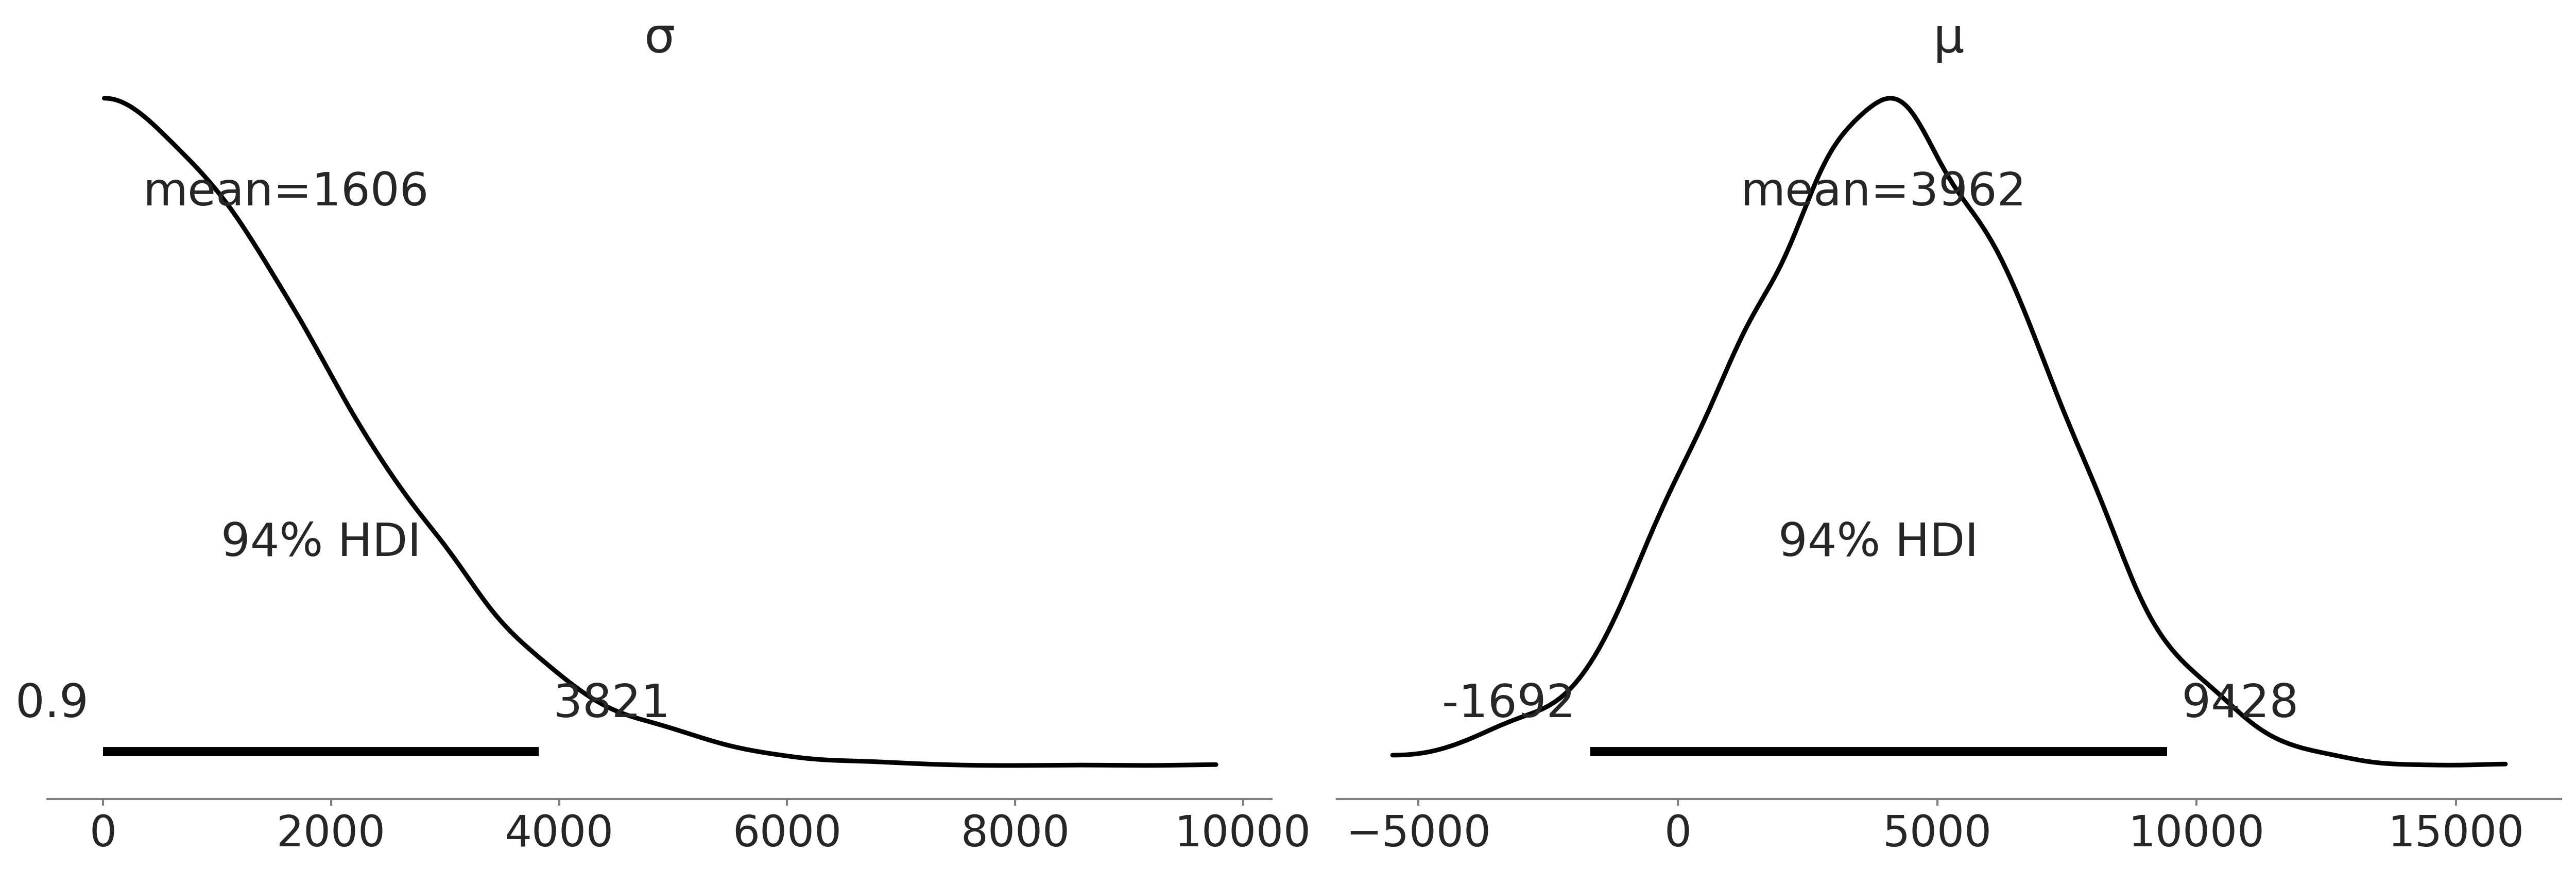

In [6]:
az.plot_posterior(prior, group="prior", textsize=20)

从先验样本本身来看，也许过于宽泛了，因为均值包含较大范围的负数，可以优化。但是作为一个简单示例，且我们有相当数量的观测结果，我们将继续进行后验分布评估。    

In [7]:
az.summary(inf_data_adelie_penguin_mass)

mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
μ  3705.420  37.763  3634.882  3775.517      0.576    0.407    4311.0   
σ   463.265  27.511   410.183   513.074      0.424    0.301    4238.0   

   ess_tail  r_hat  
μ    2465.0    1.0  
σ    2893.0    1.0

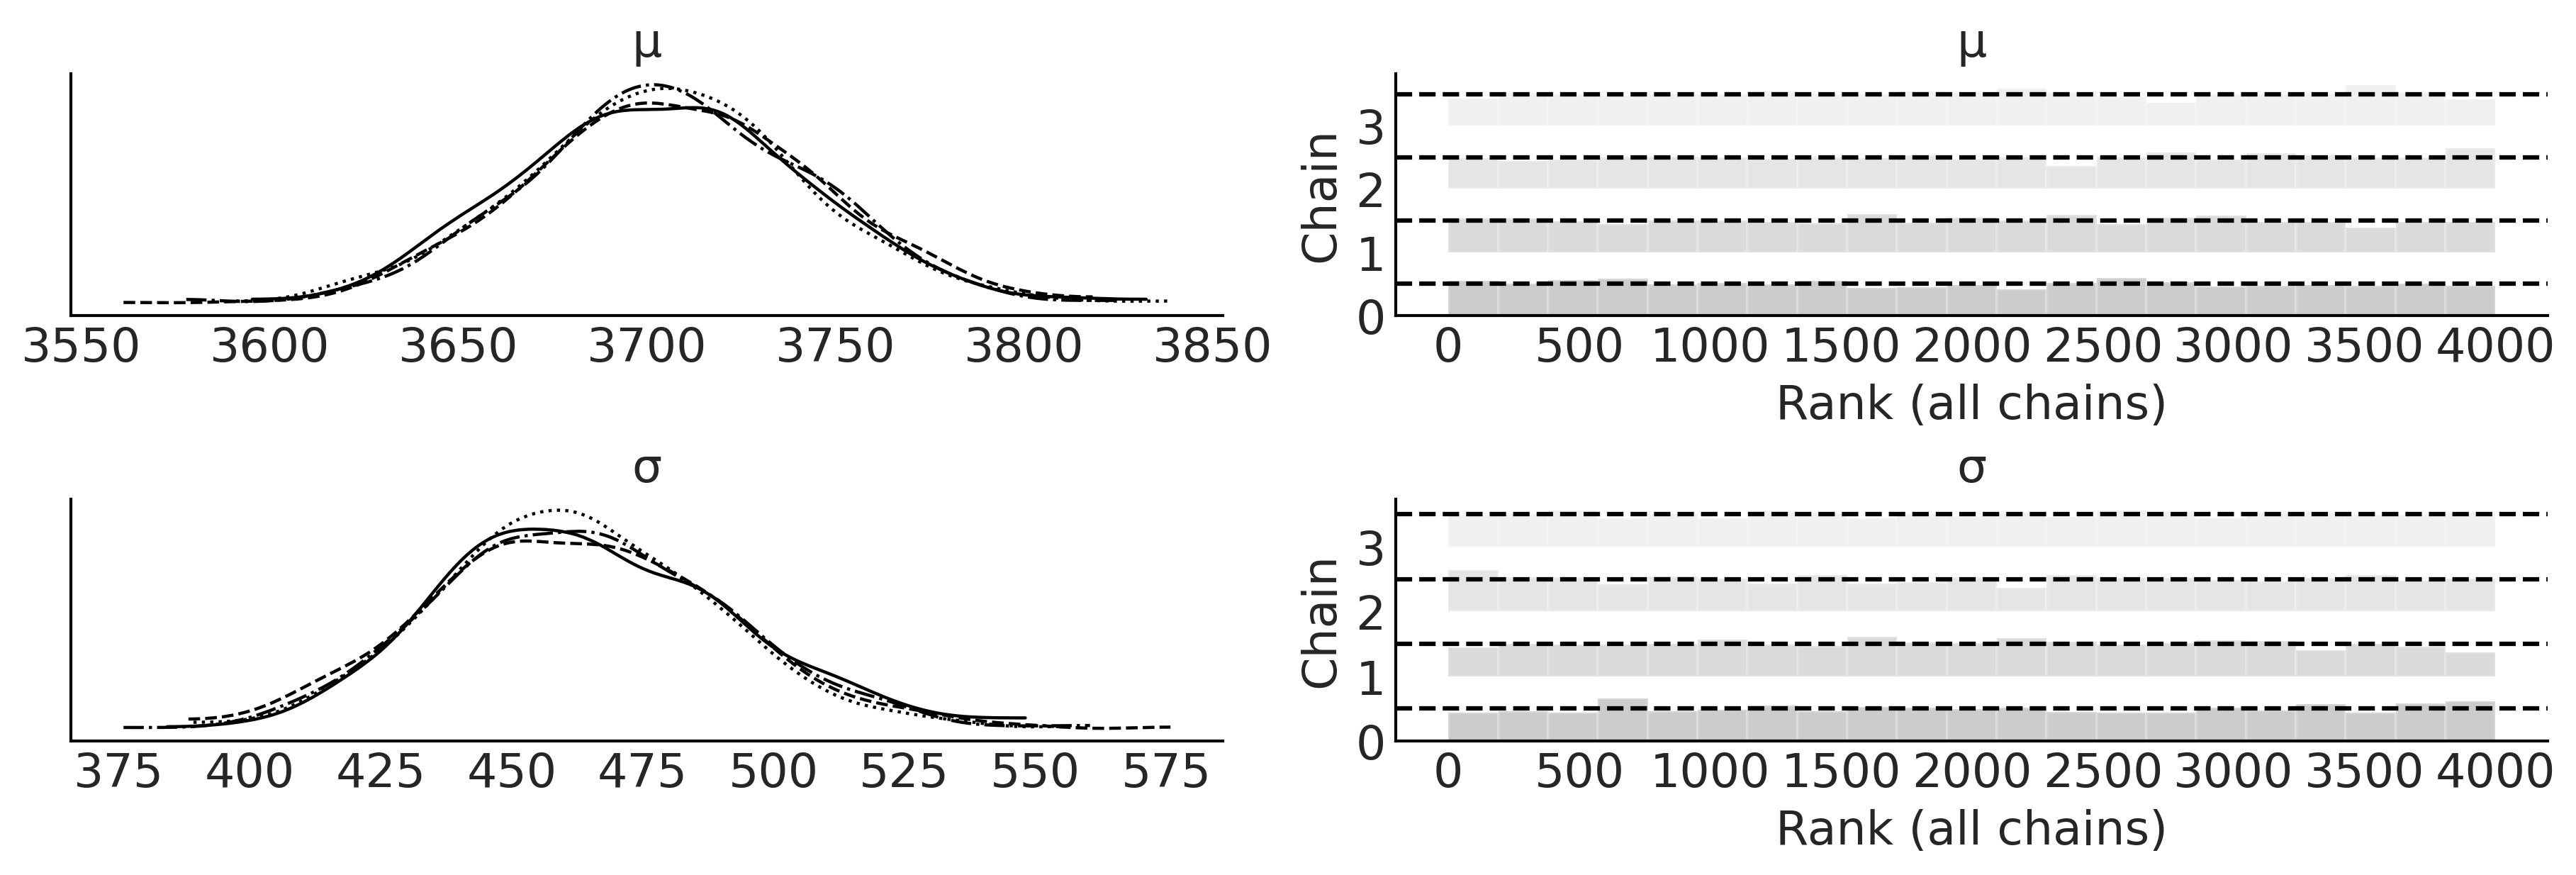

In [8]:
axes = az.plot_trace(inf_data_adelie_penguin_mass, divergences="bottom", kind="rank_bars");
plot_label_resizer(axes, fontsize=16)

在从模型抽样后，我们得到上面的4个子图，右边两个是Rank图（如果4个链来自相同后验分布，它们混合排序后，各自的排名应该是相似的），左边是 KDE 图。也可以通过表格来进行分析。    
从上来看，模型的拟合是可以接受的。

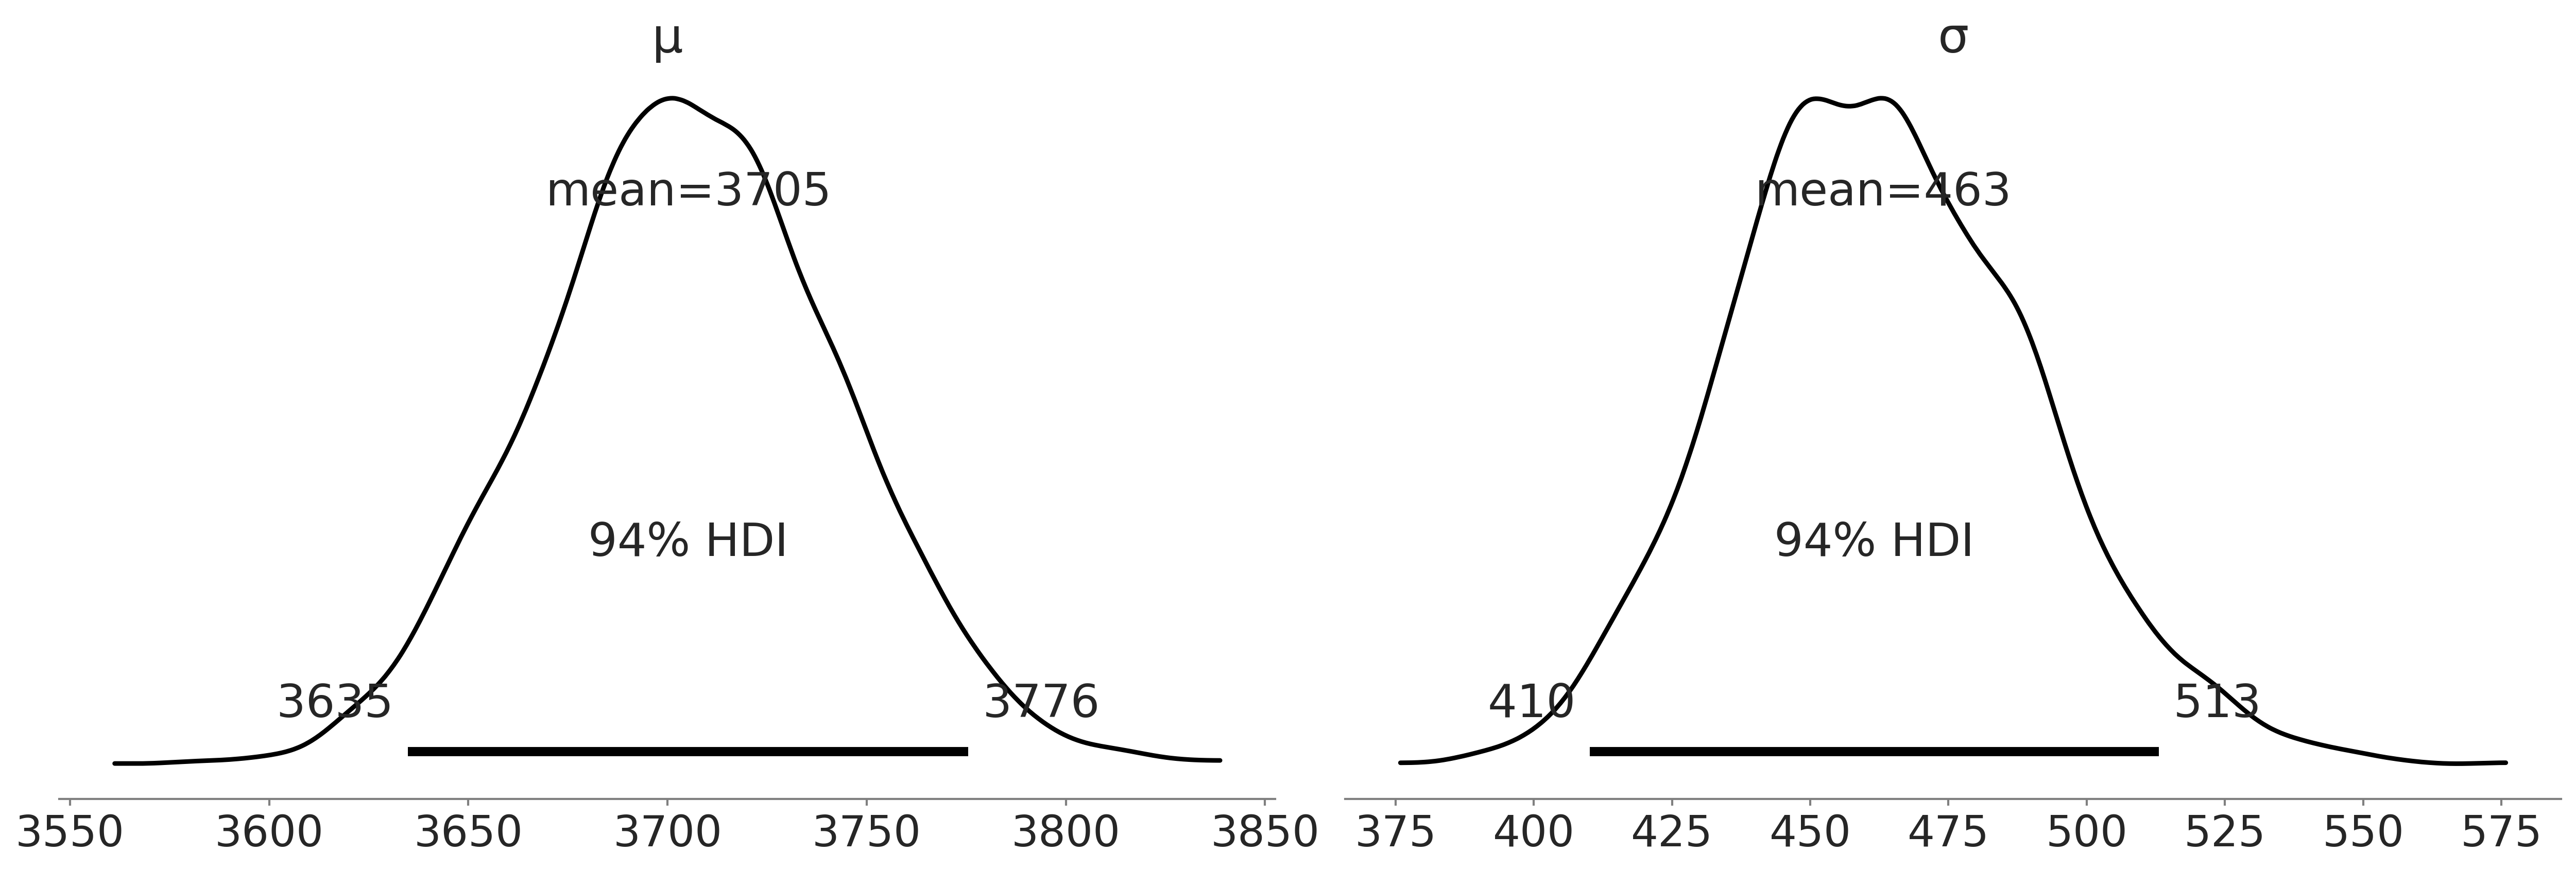

In [9]:
axes = az.plot_posterior(inf_data_adelie_penguin_mass, textsize=20);

通过上面的贝叶斯估计，我们得到了统计量的不确定性范围。    
   
我们可以用相同的方法评估其他两个种群。

In [10]:
# pd.categorical makes it easy to index species below
all_species = pd.Categorical(penguins["species"])

with pm.Model() as model_penguin_mass_all_species:
    # Note the addition of the shape parameter
    σ = pm.HalfStudentT("σ", 100, 2000, shape=3)
    μ = pm.Normal("μ", 4000, 3000, shape=3)
    mass = pm.Normal("mass",
                     mu=μ[all_species.codes],
                     sigma=σ[all_species.codes],
                     observed=penguins["body_mass_g"])

    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [11]:
trace = trace.assign_coords(coords={"μ_dim_0": all_species.categories,
                "σ_dim_0": all_species.categories})

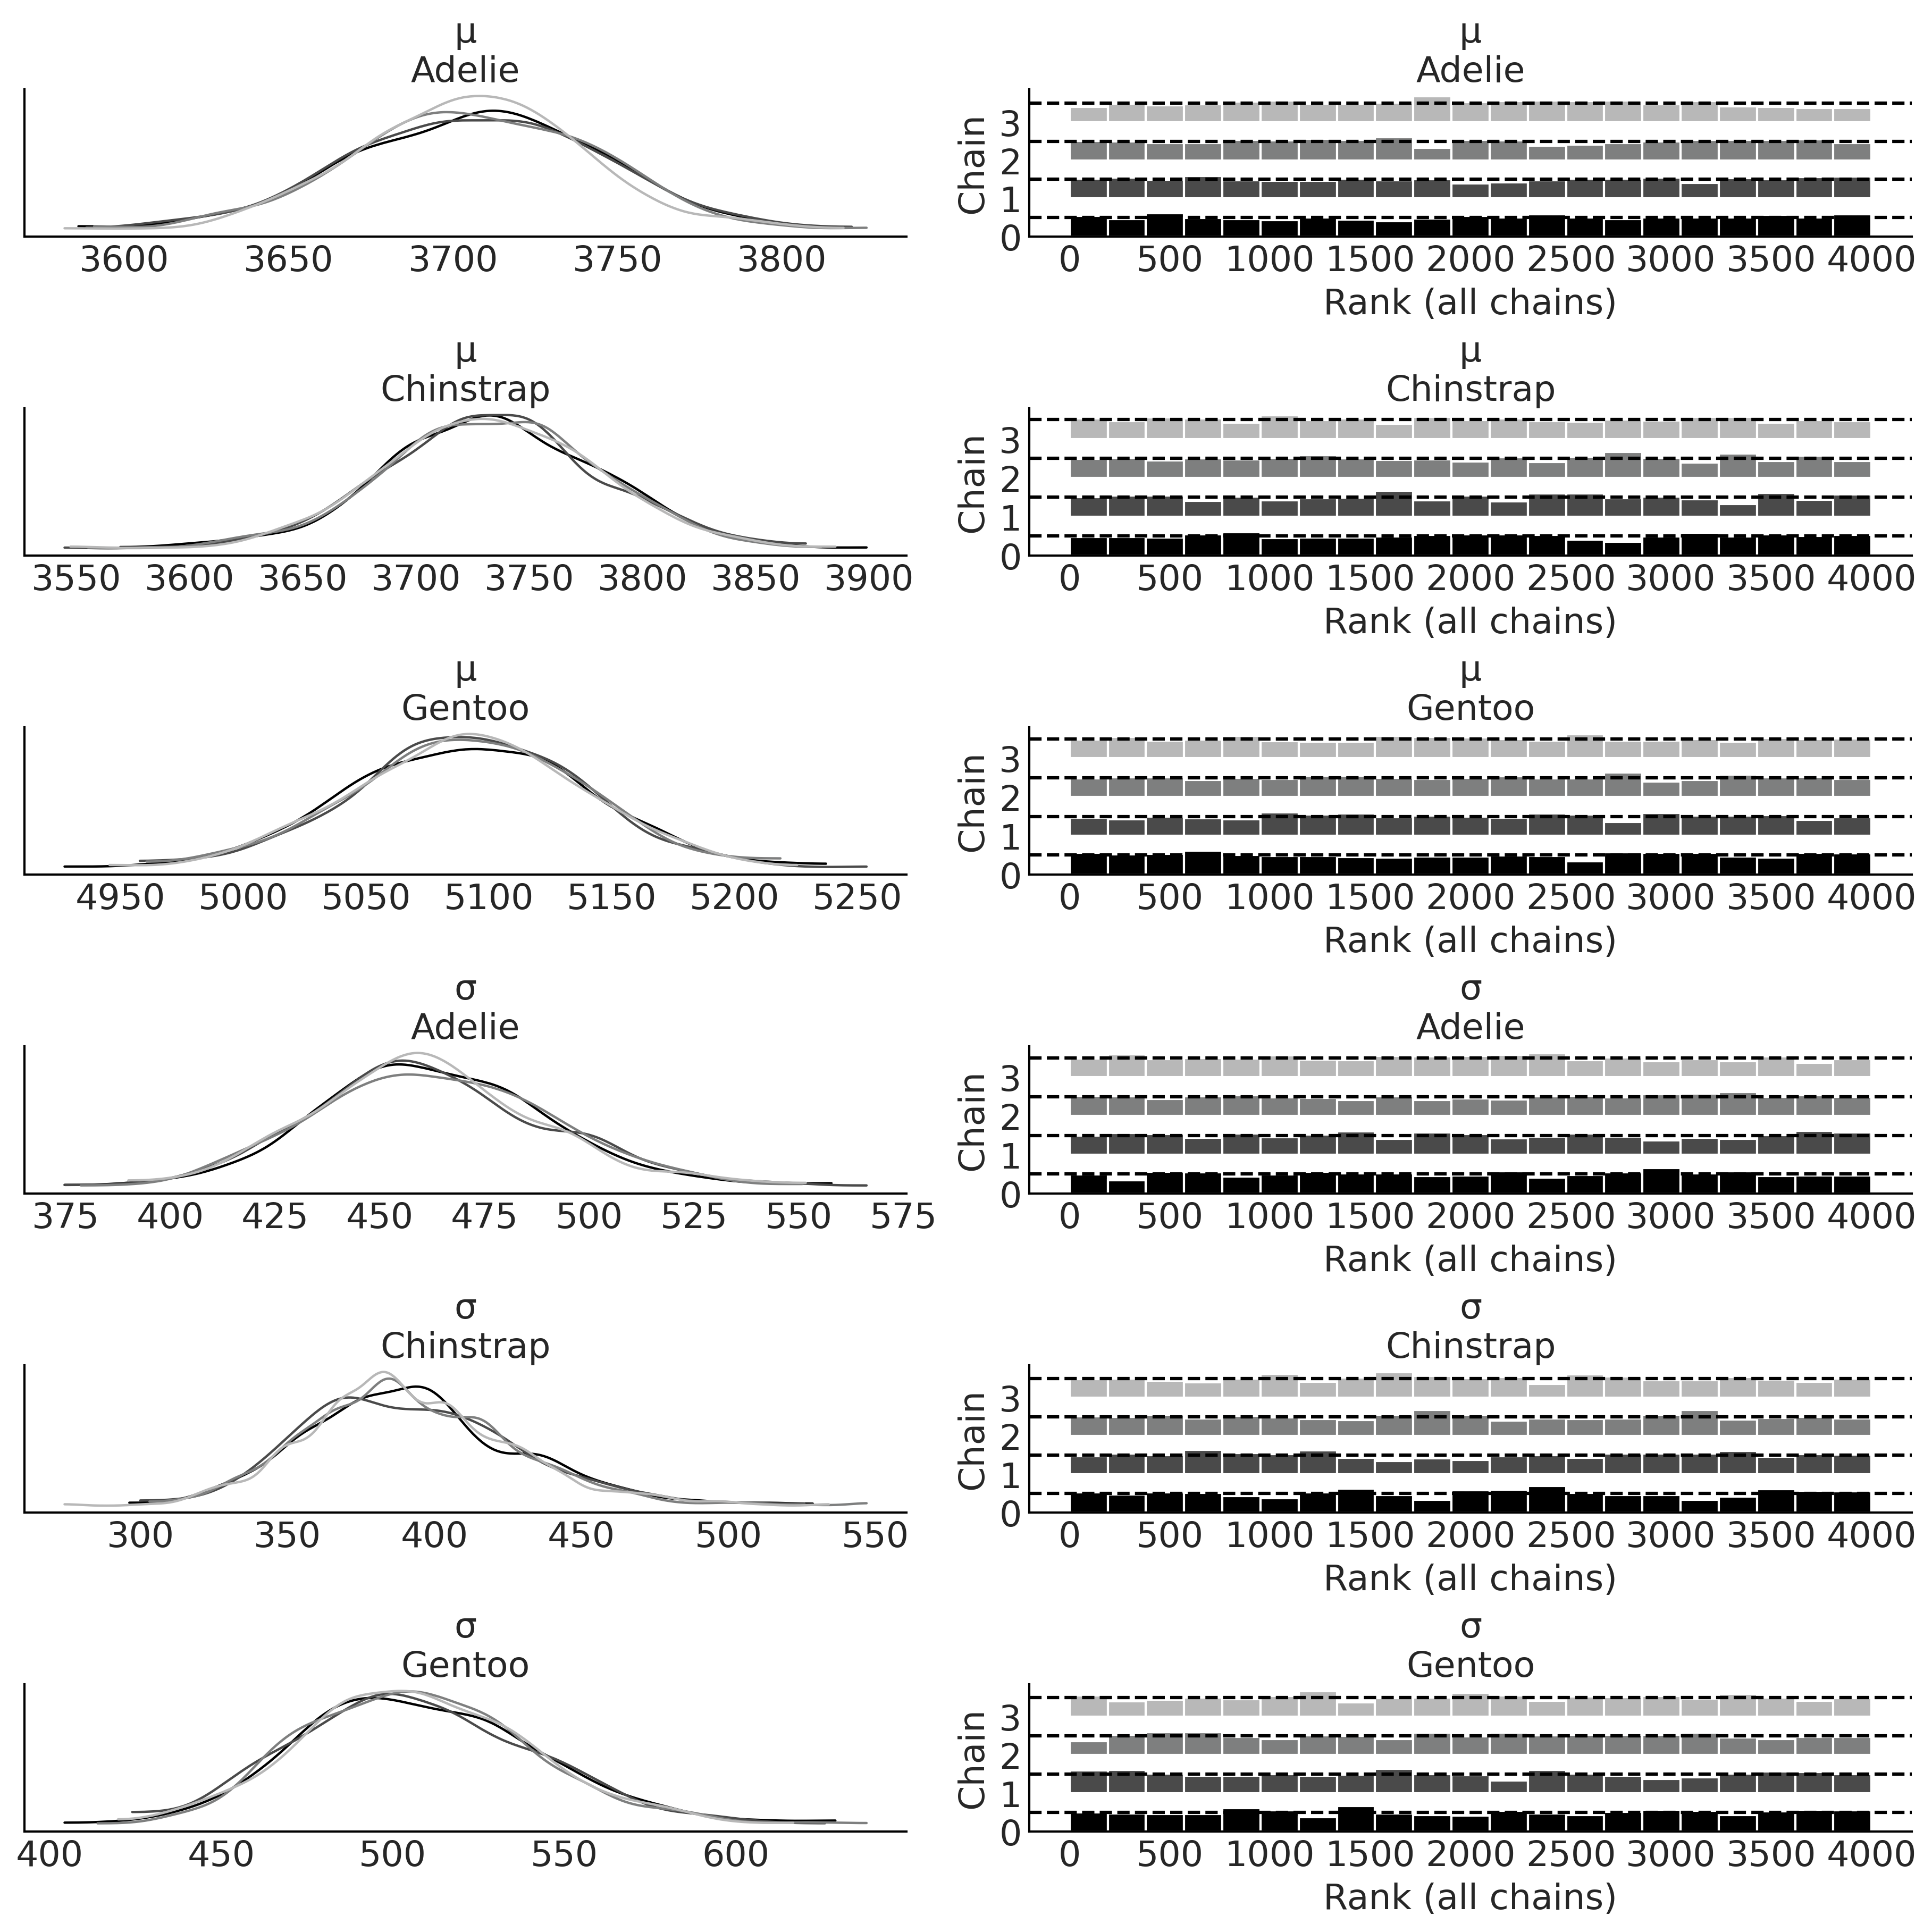

In [12]:
axes = az.plot_trace(trace, compact=False, divergences="bottom", kind="rank_bars");

plot_label_resizer(axes, fontsize=16)

可以通过 `az.plot_forest` 来更方便的比较不同种群的差异。

Text(0.5, 1.0, 'μ Mass Estimate: 94.0% HDI')

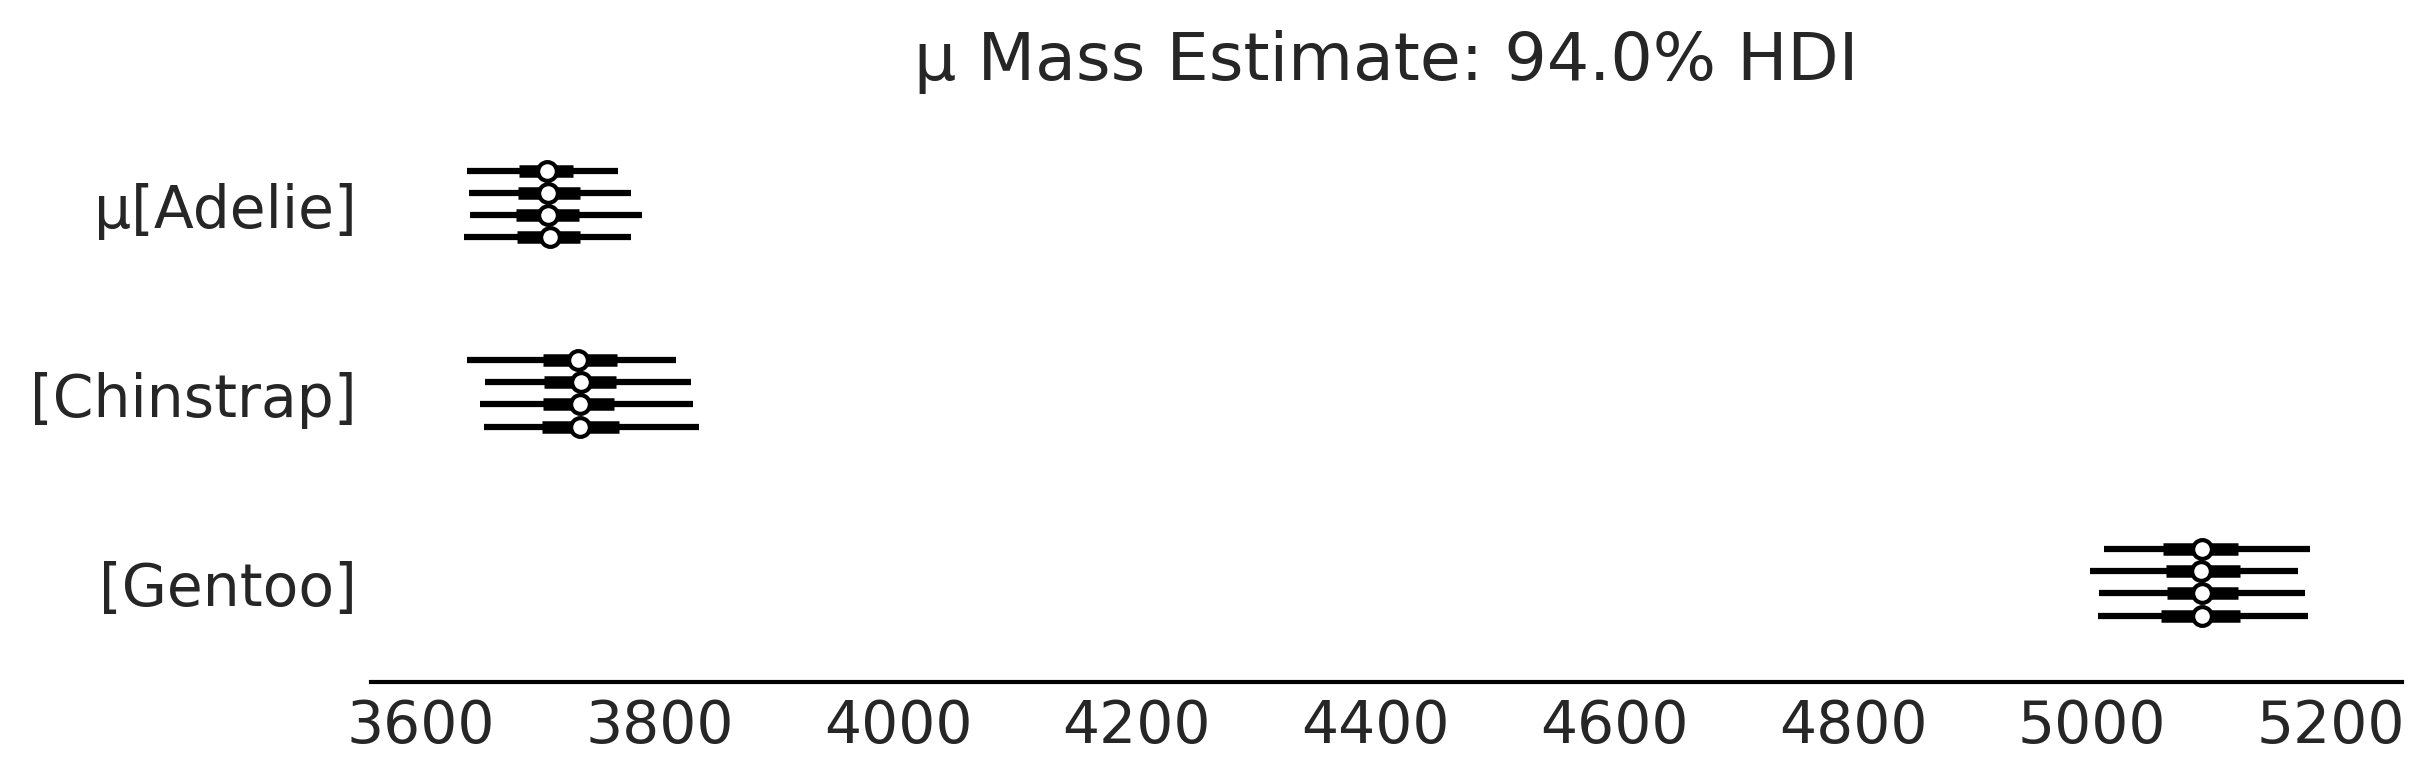

In [13]:
axes = az.plot_forest(trace, var_names=["μ"], figsize=(8, 2.5))
axes[0].set_title("μ Mass Estimate: 94.0% HDI")

从上图可知 Gentoo 有更大的均值。让我们来看看标准差。

Text(0.5, 1.0, 'σ Mass Estimate: 94.0% HDI')

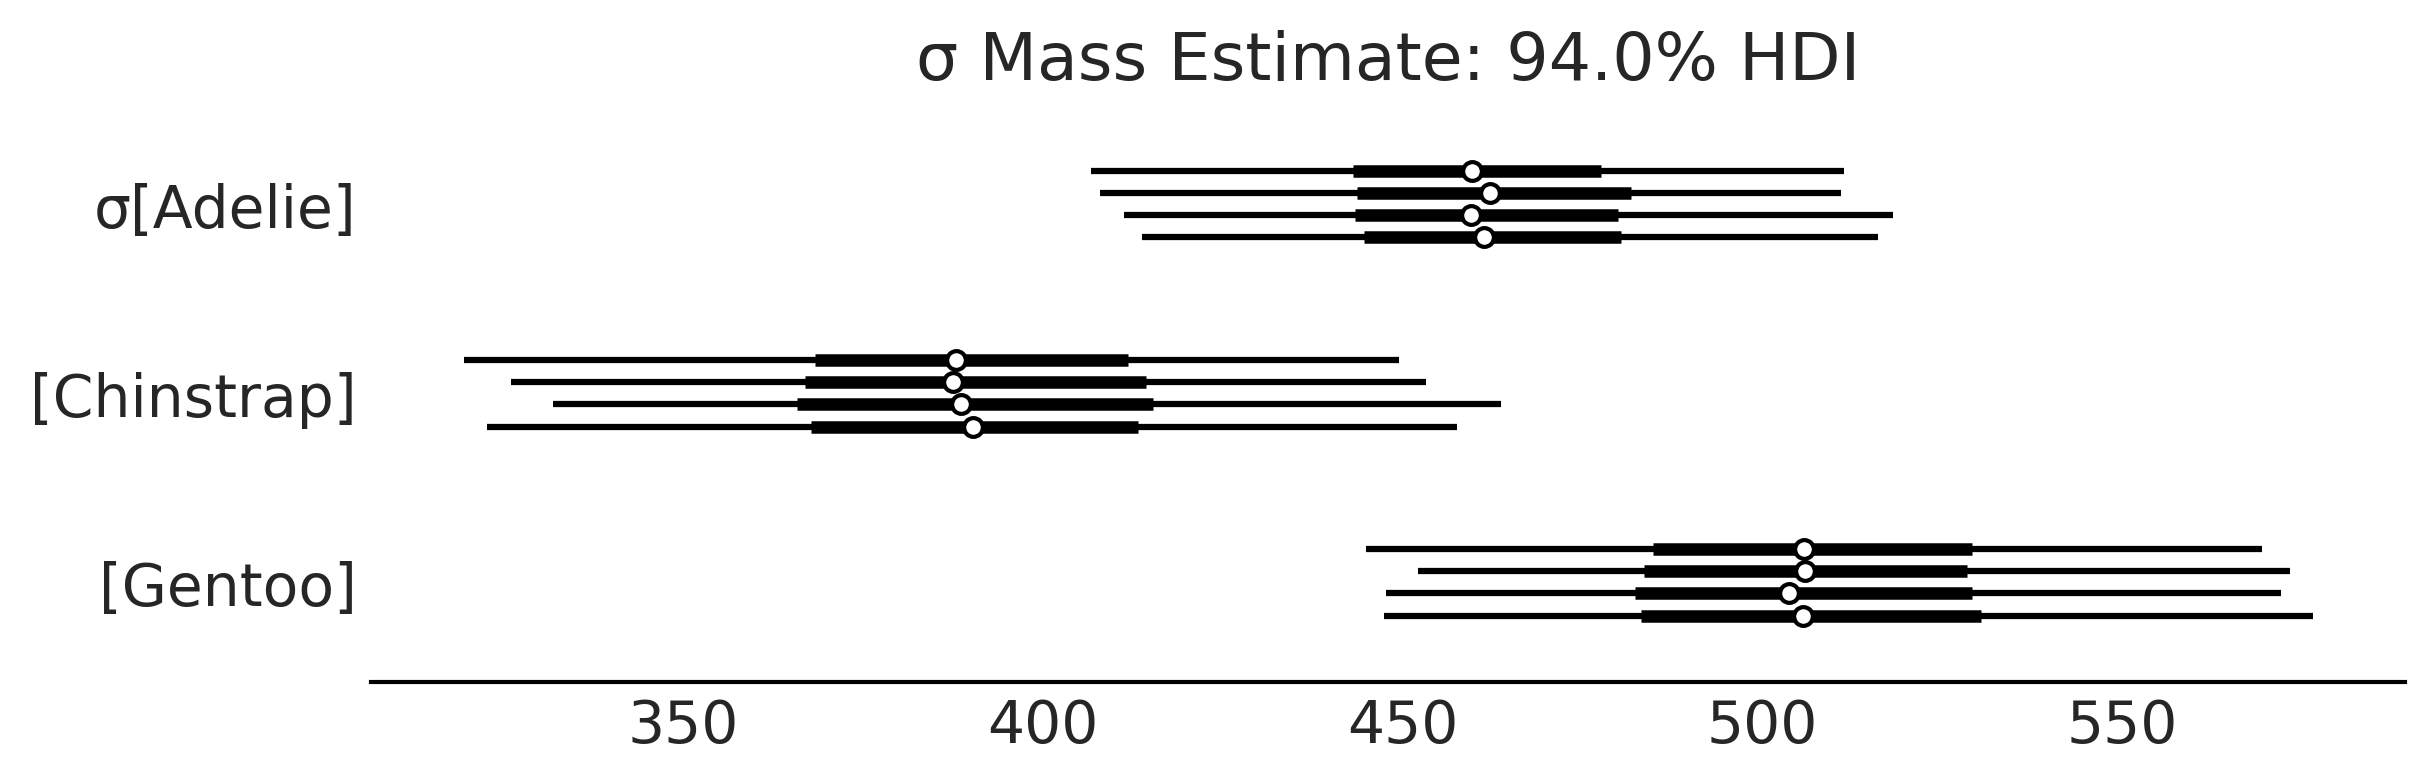

In [14]:
axes = az.plot_forest(trace, var_names=["σ"], figsize=(8, 2.5))
axes[0].set_title("σ Mass Estimate: 94.0% HDI")

### 3.1.1. 比较两种概率编程语言 PPLs

后续会使用 PyMC 与 TensorFlow Probability (TFP) 来进行编程。     
    
学习不同的 PPL 似乎没有必要。然而在本书中选择使用两个 PPL 而不是一个 PPL 是有特定原因的。在不同的 PPL 中看到相同的工作流程将使您对计算贝叶斯建模有更全面的了解，帮助您将计算细节与统计思想分开，并使您成为整体上更强大的建模者。而且，不同的PPL有不同的强度和侧重点。 PyMC3 是一种更高级别的 PPL，可以更轻松地用更少的代码表达模型，而 TFP 则为可组合建模和推理提供较低级别的 PPL。另一个问题是，并非所有 PPL 都能够像彼此一样轻松地表达所有模型。例如，时间序列模型（第 6 章）在 TFP 中更容易定义，而贝叶斯加法回归树在 PyMC（第 7 章）中更容易表达。通过接触多种语言，您将对贝叶斯建模的基本要素以及它们的计算实现方式有更深入的了解。 

## 3.2. 线性回归

上一节中我们评估了质量和种群的关系，但是还可以有很多其它数据与质量相关，比如脚蹼的长度等。一种最简单的方法是使用线性回归来评估它们间的关系。    
$$\begin{split}
    \mu =& \beta_0 + \beta_1 X_1 + \dots + \beta_m X_m \\
Y \sim& \mathcal{N}(\mu, \sigma)
\end{split}$$

其中每个 $\beta_i$ 参数都是一个随机变量。也可以通过矩阵来表示：
$$\mu = \mathbf{X}\boldsymbol{\beta}$$    

在非贝叶斯框架下，参数被认为是确定的，并单独讲噪音分开，因此表示为：
$$Y = \mathbf{X}\boldsymbol{\beta} + \epsilon,\; \epsilon \sim \mathcal{N}(0, \sigma)$$    



### 3.2.1. 线性的企鹅

我们没有什么先验知识，所以我们选择一个宽泛的先验分布，$\beta_i \sim \mathcal{N}(0, 4000)$。让我们在 adelie 上考虑脚蹼长度来建模：

In [15]:
adelie_flipper_length_obs = penguins.loc[adelie_mask, "flipper_length_mm"]

with pm.Model() as model_adelie_flipper_regression:
    # pm.Data allows us to change the underlying value in a later code block
    adelie_flipper_length = pm.Data("adelie_flipper_length",
                                    adelie_flipper_length_obs, mutable=True)
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 4000)
    β_1 = pm.Normal("β_1", 0, 4000)
    μ = pm.Deterministic("μ", β_0 + β_1 * adelie_flipper_length)

    mass = pm.Normal("mass", mu=μ, sigma=σ, observed = adelie_mass_obs)

    inf_data_adelie_flipper_regression = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_0, β_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


为了节省篇幅，这里不进行模型诊断，在真实应用场景下请一定注意诊断。

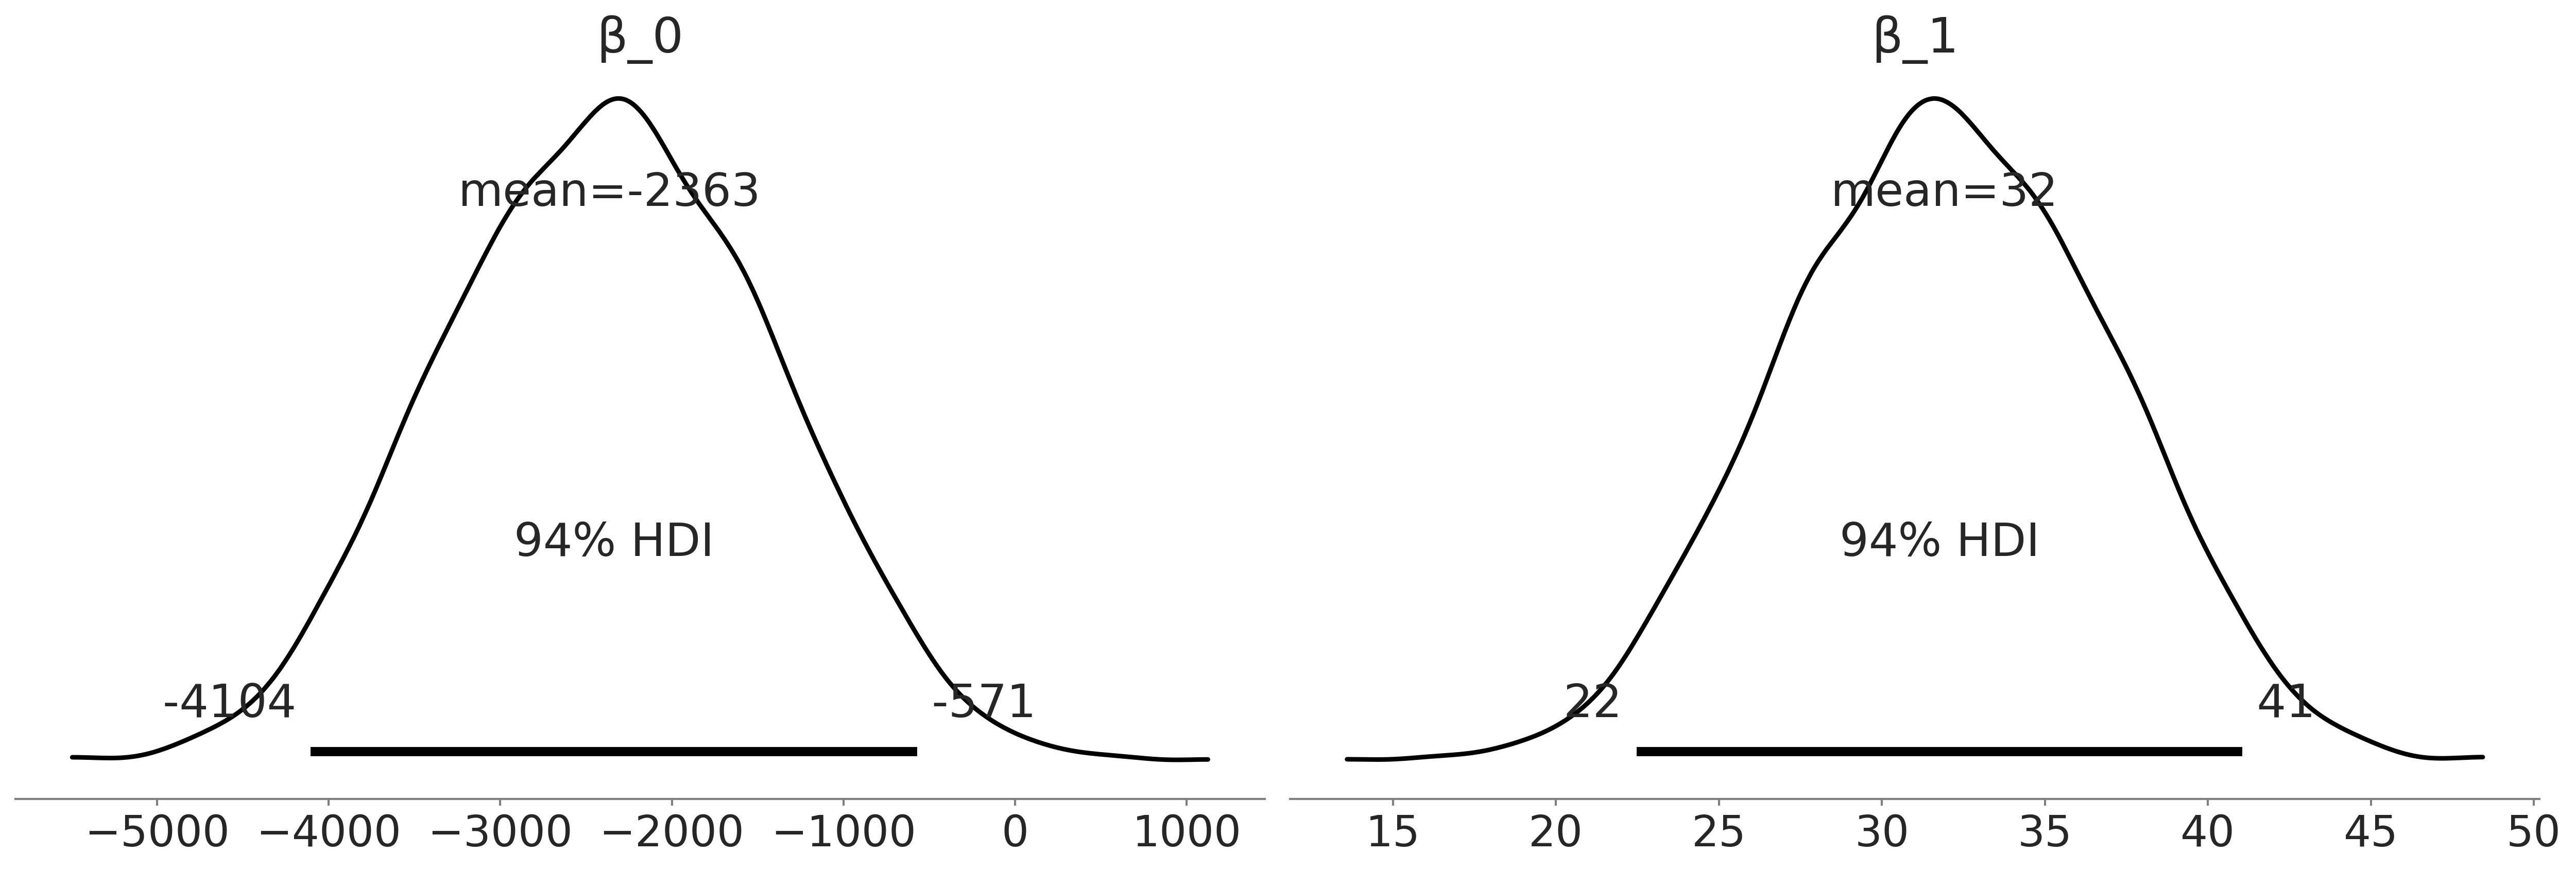

In [16]:
axes = az.plot_posterior(inf_data_adelie_flipper_regression, var_names = ["β_0", "β_1"], textsize=20);

从上可知，脚蹼长度与质量呈正相关，每增加1mm质量增加约32g，而且其 94% HDI 不包含0，这支持了脚蹼长度与质量有关的看法。请注意这不代表因果，例如人为手术增加脚蹼长度，质量不会增加。    
我们可以推测，增加脚蹼协变量将有助于更好地预测企鹅的质量。我们可以通过 $\sigma$ 来验证，对比固定均值模型和线性模型，$\sigma$ 变小了

Text(0.5, 1.0, 'σ Comparison 94.0 HDI')

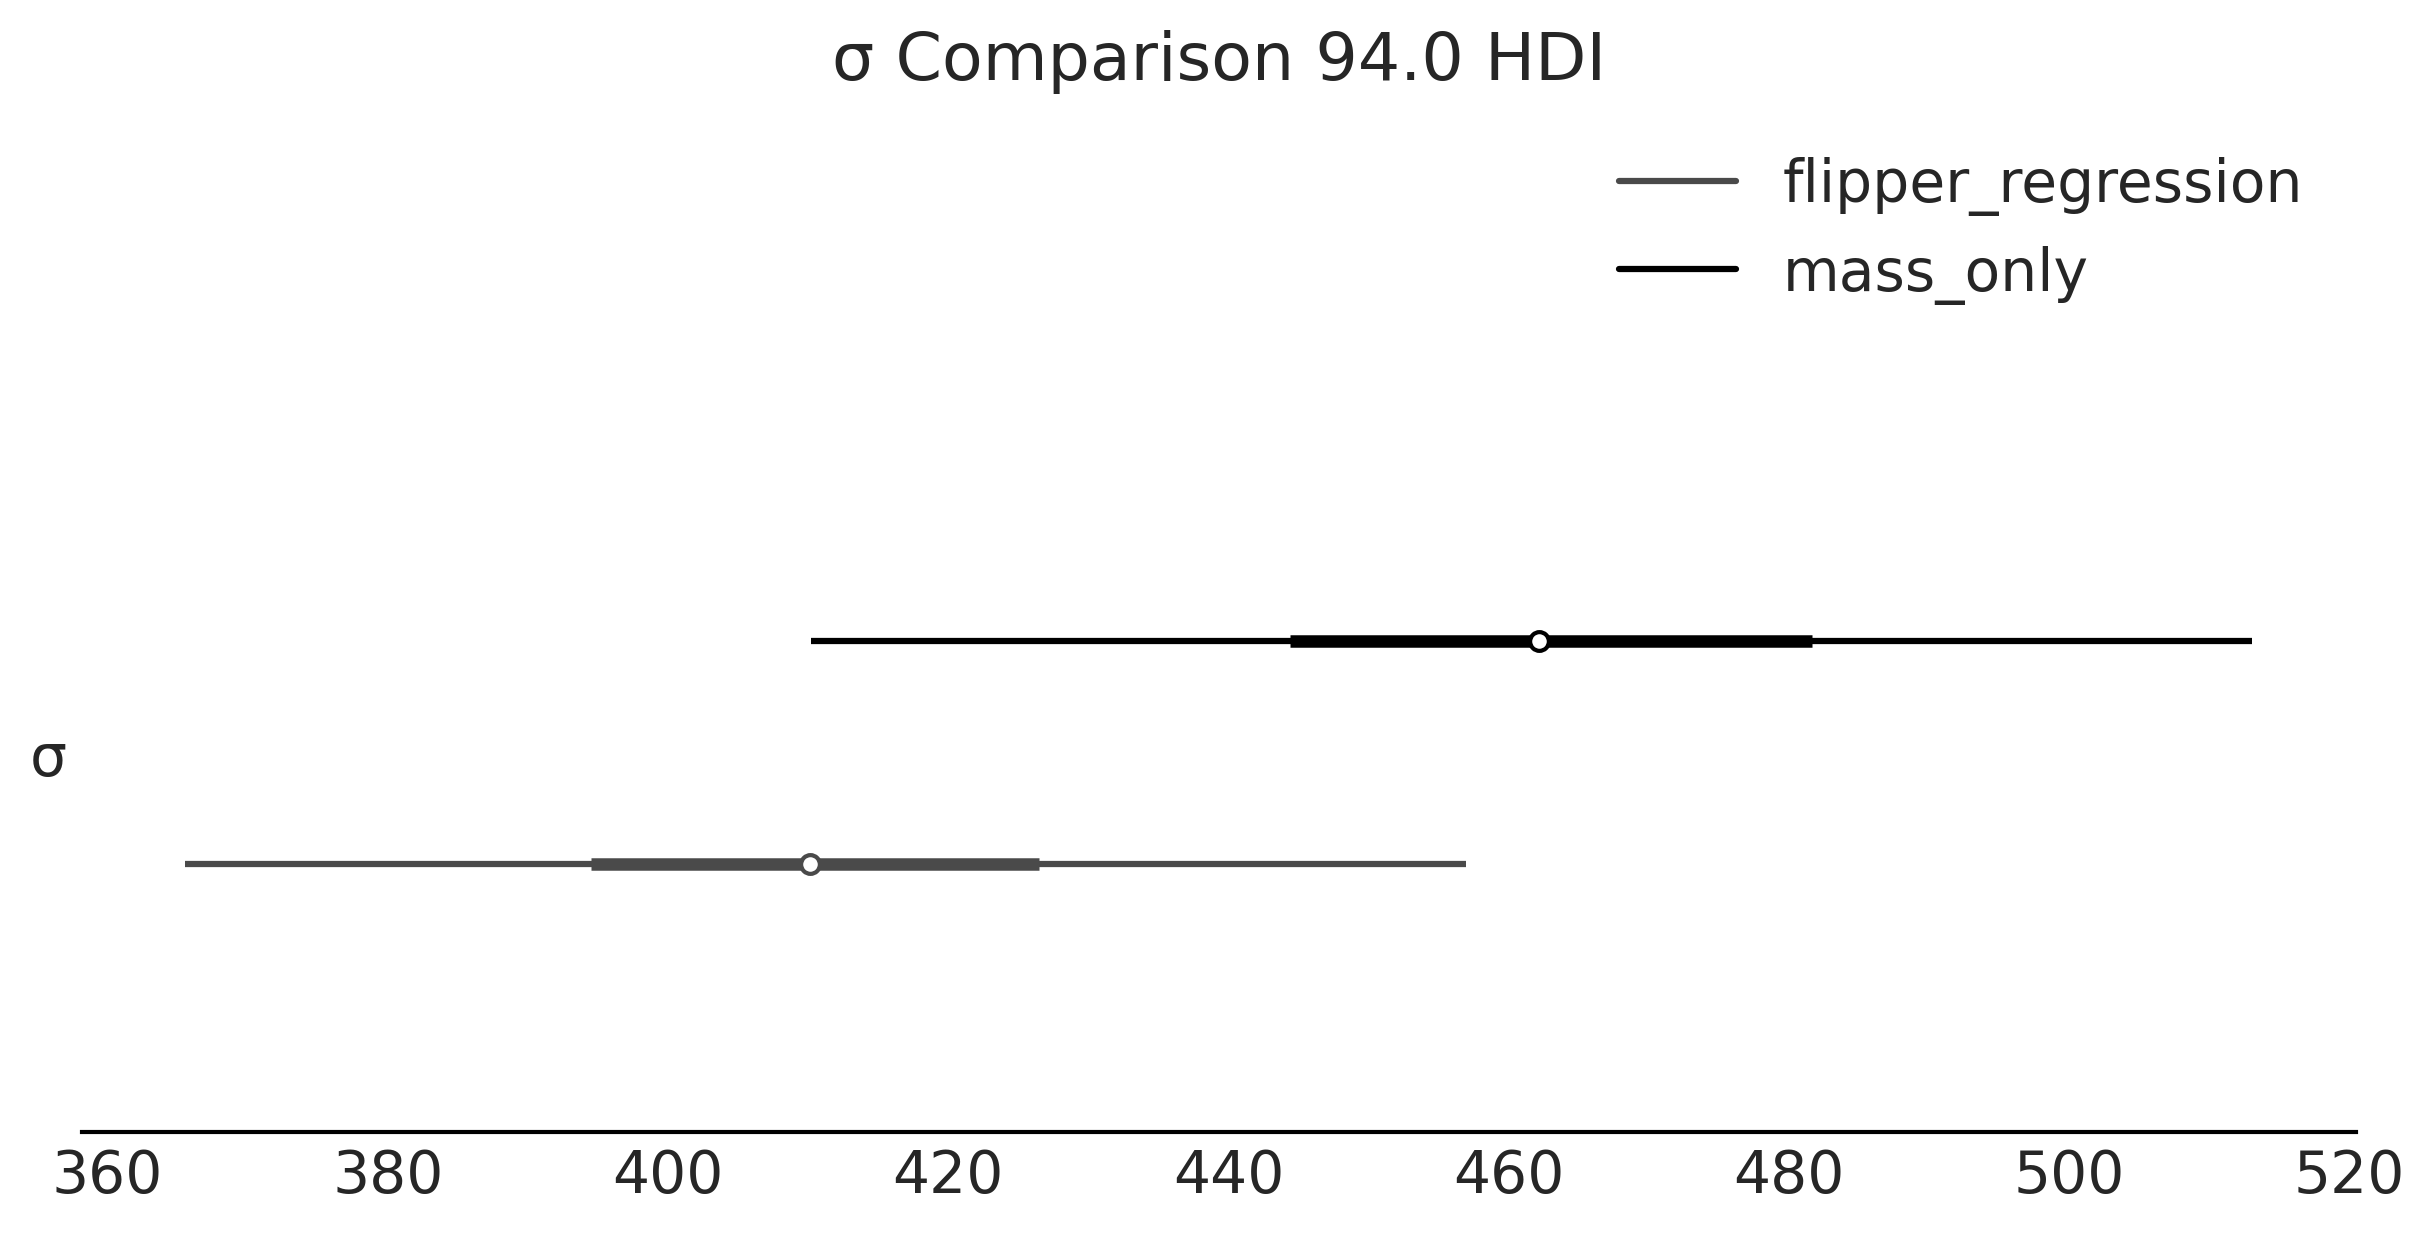

In [17]:
axes = az.plot_forest(
    [inf_data_adelie_penguin_mass, inf_data_adelie_flipper_regression],
    model_names=["mass_only", "flipper_regression"],
    var_names=["σ"], combined=True, figsize=(8,4))

axes[0].set_title("σ Comparison 94.0 HDI")

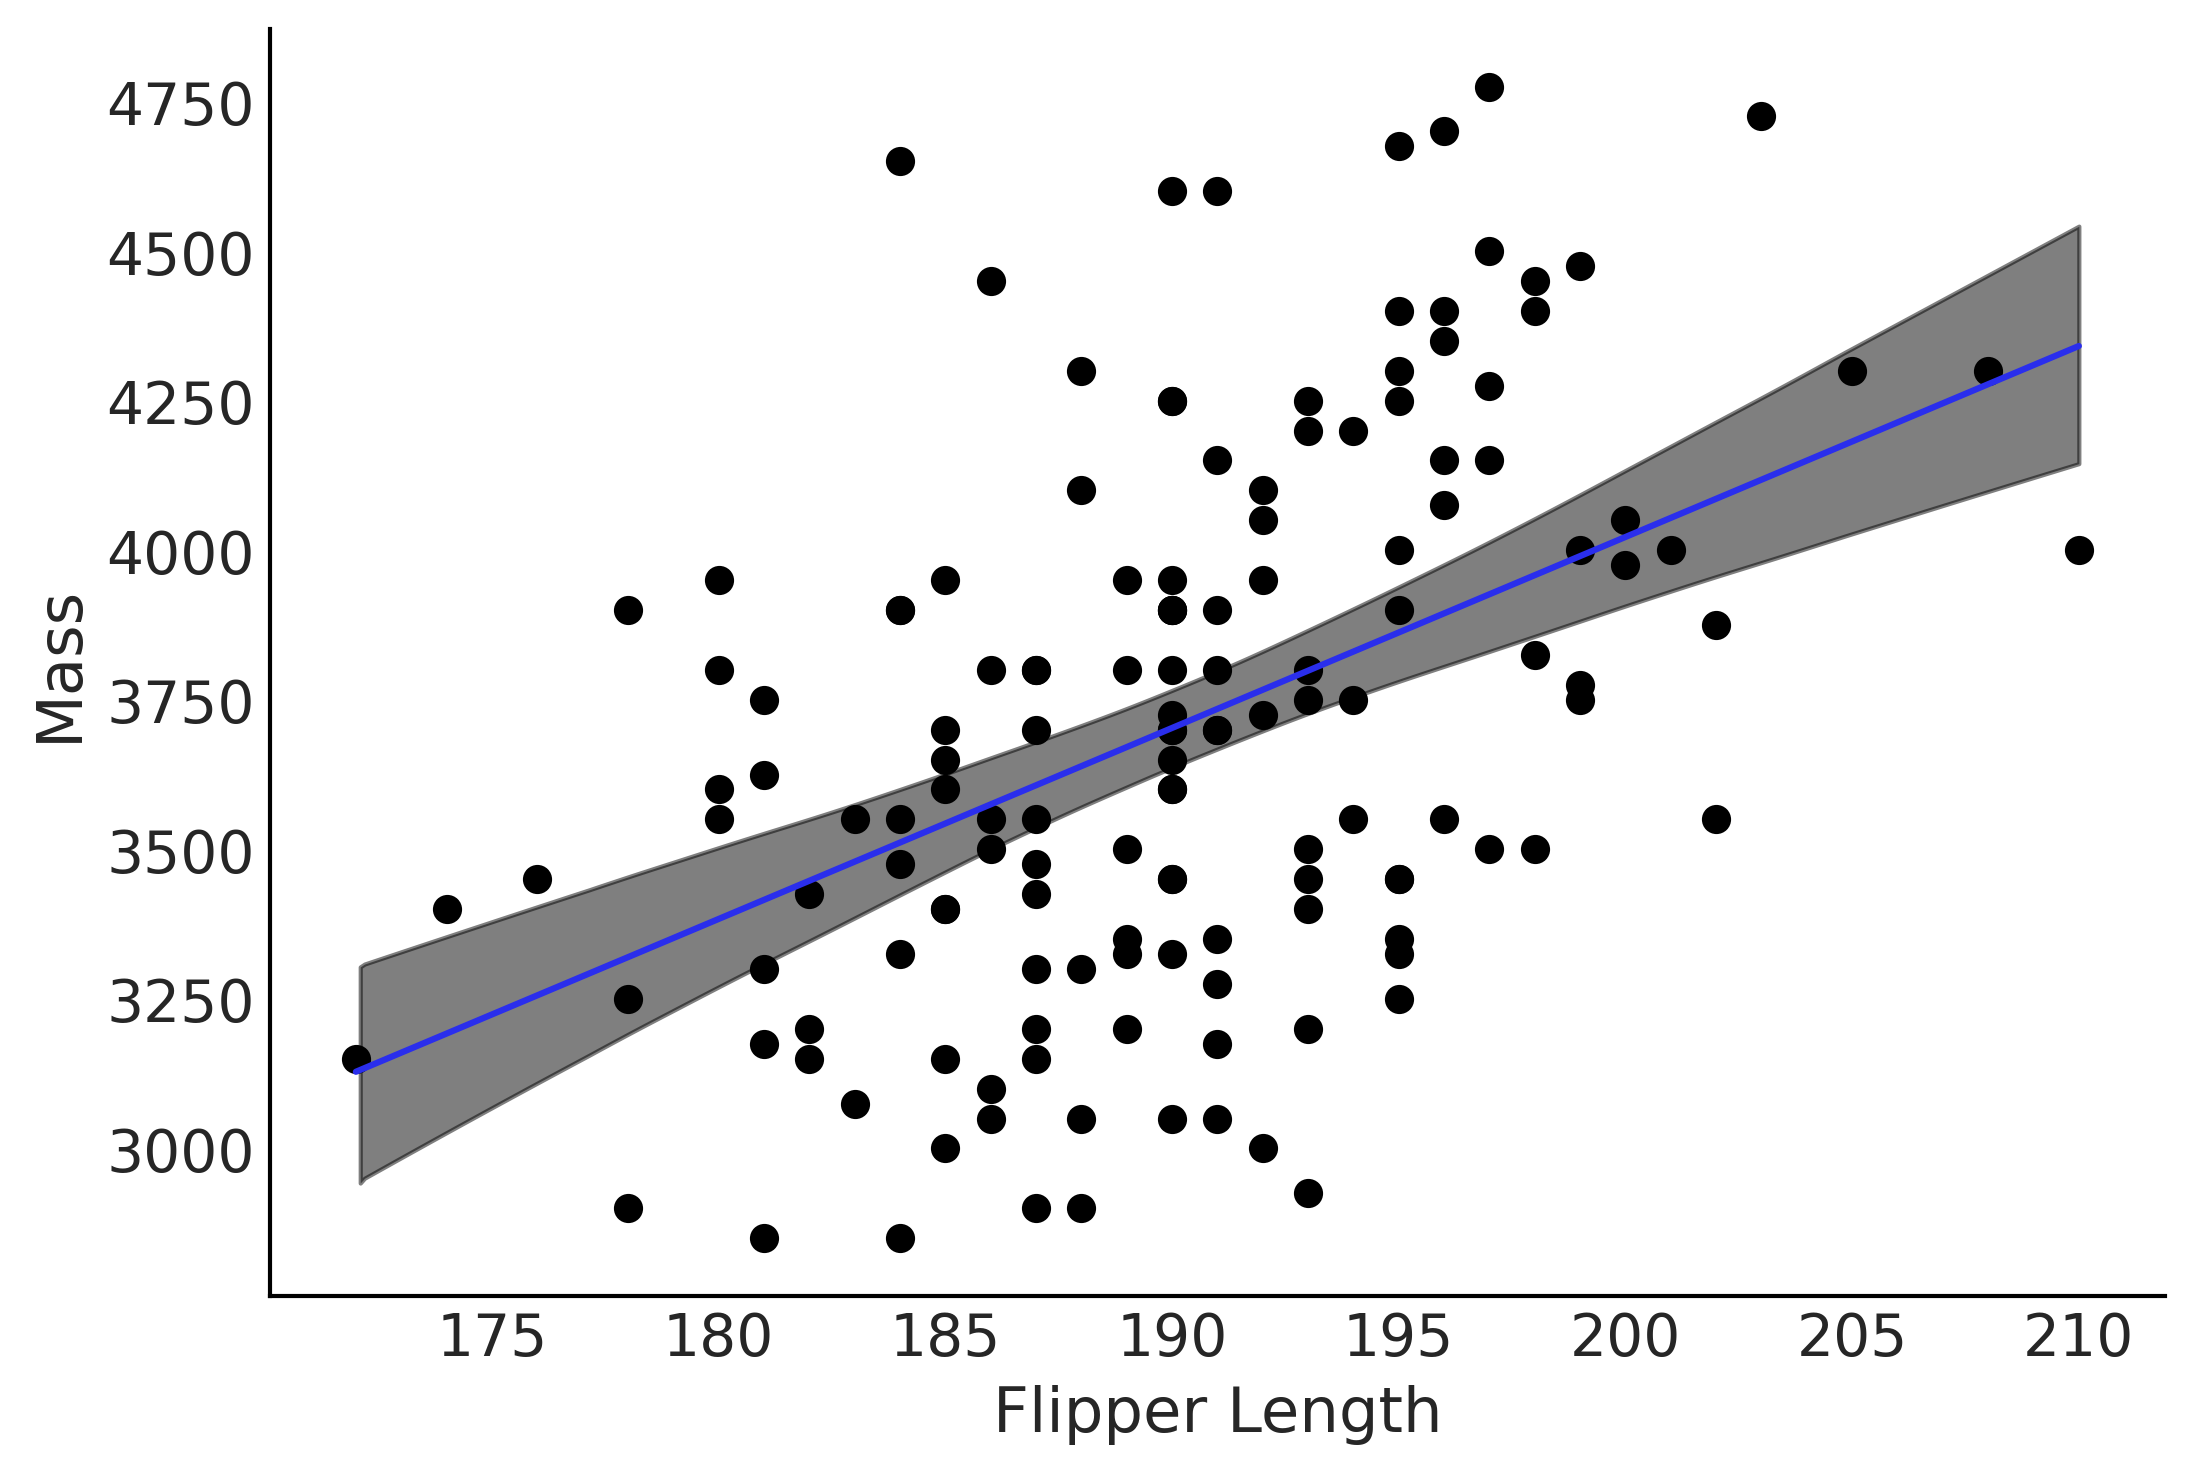

In [18]:
fig, ax = plt.subplots()
alpha_m = inf_data_adelie_flipper_regression.posterior.mean().to_dict()["data_vars"]["β_0"]["data"]
beta_m = inf_data_adelie_flipper_regression.posterior.mean().to_dict()["data_vars"]["β_1"]["data"]

flipper_length = np.linspace(adelie_flipper_length_obs.min(), adelie_flipper_length_obs.max(), 100)

flipper_length_mean = alpha_m + beta_m * flipper_length
ax.plot(flipper_length, flipper_length_mean, c='C4',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

ax.scatter(adelie_flipper_length_obs, adelie_mass_obs)

# Figure out how to do this from inference data
az.plot_hdi(adelie_flipper_length_obs, inf_data_adelie_flipper_regression.posterior['μ'], hdi_prob=0.94, color='k', ax=ax)

ax.set_xlabel('Flipper Length')
ax.set_ylabel('Mass');

### 3.2.2. 预测

上面建立了脚蹼和质量的模型，因此根据脚蹼长度，我们可以预测企鹅的质量。比如我们知道一个企鹅的脚蹼长度为均值，可以预测其后验均值和观测值。

In [19]:
with model_adelie_flipper_regression:
    # Change the underlying value to the mean observed flipper length
    # for our posterior predictive samples
    pm.set_data({"adelie_flipper_length": [adelie_flipper_length_obs.mean()]})
    posterior_predictions = pm.sample_posterior_predictive(
        inf_data_adelie_flipper_regression.posterior, var_names=["mass", "μ"])

Sampling: [mass]


[]

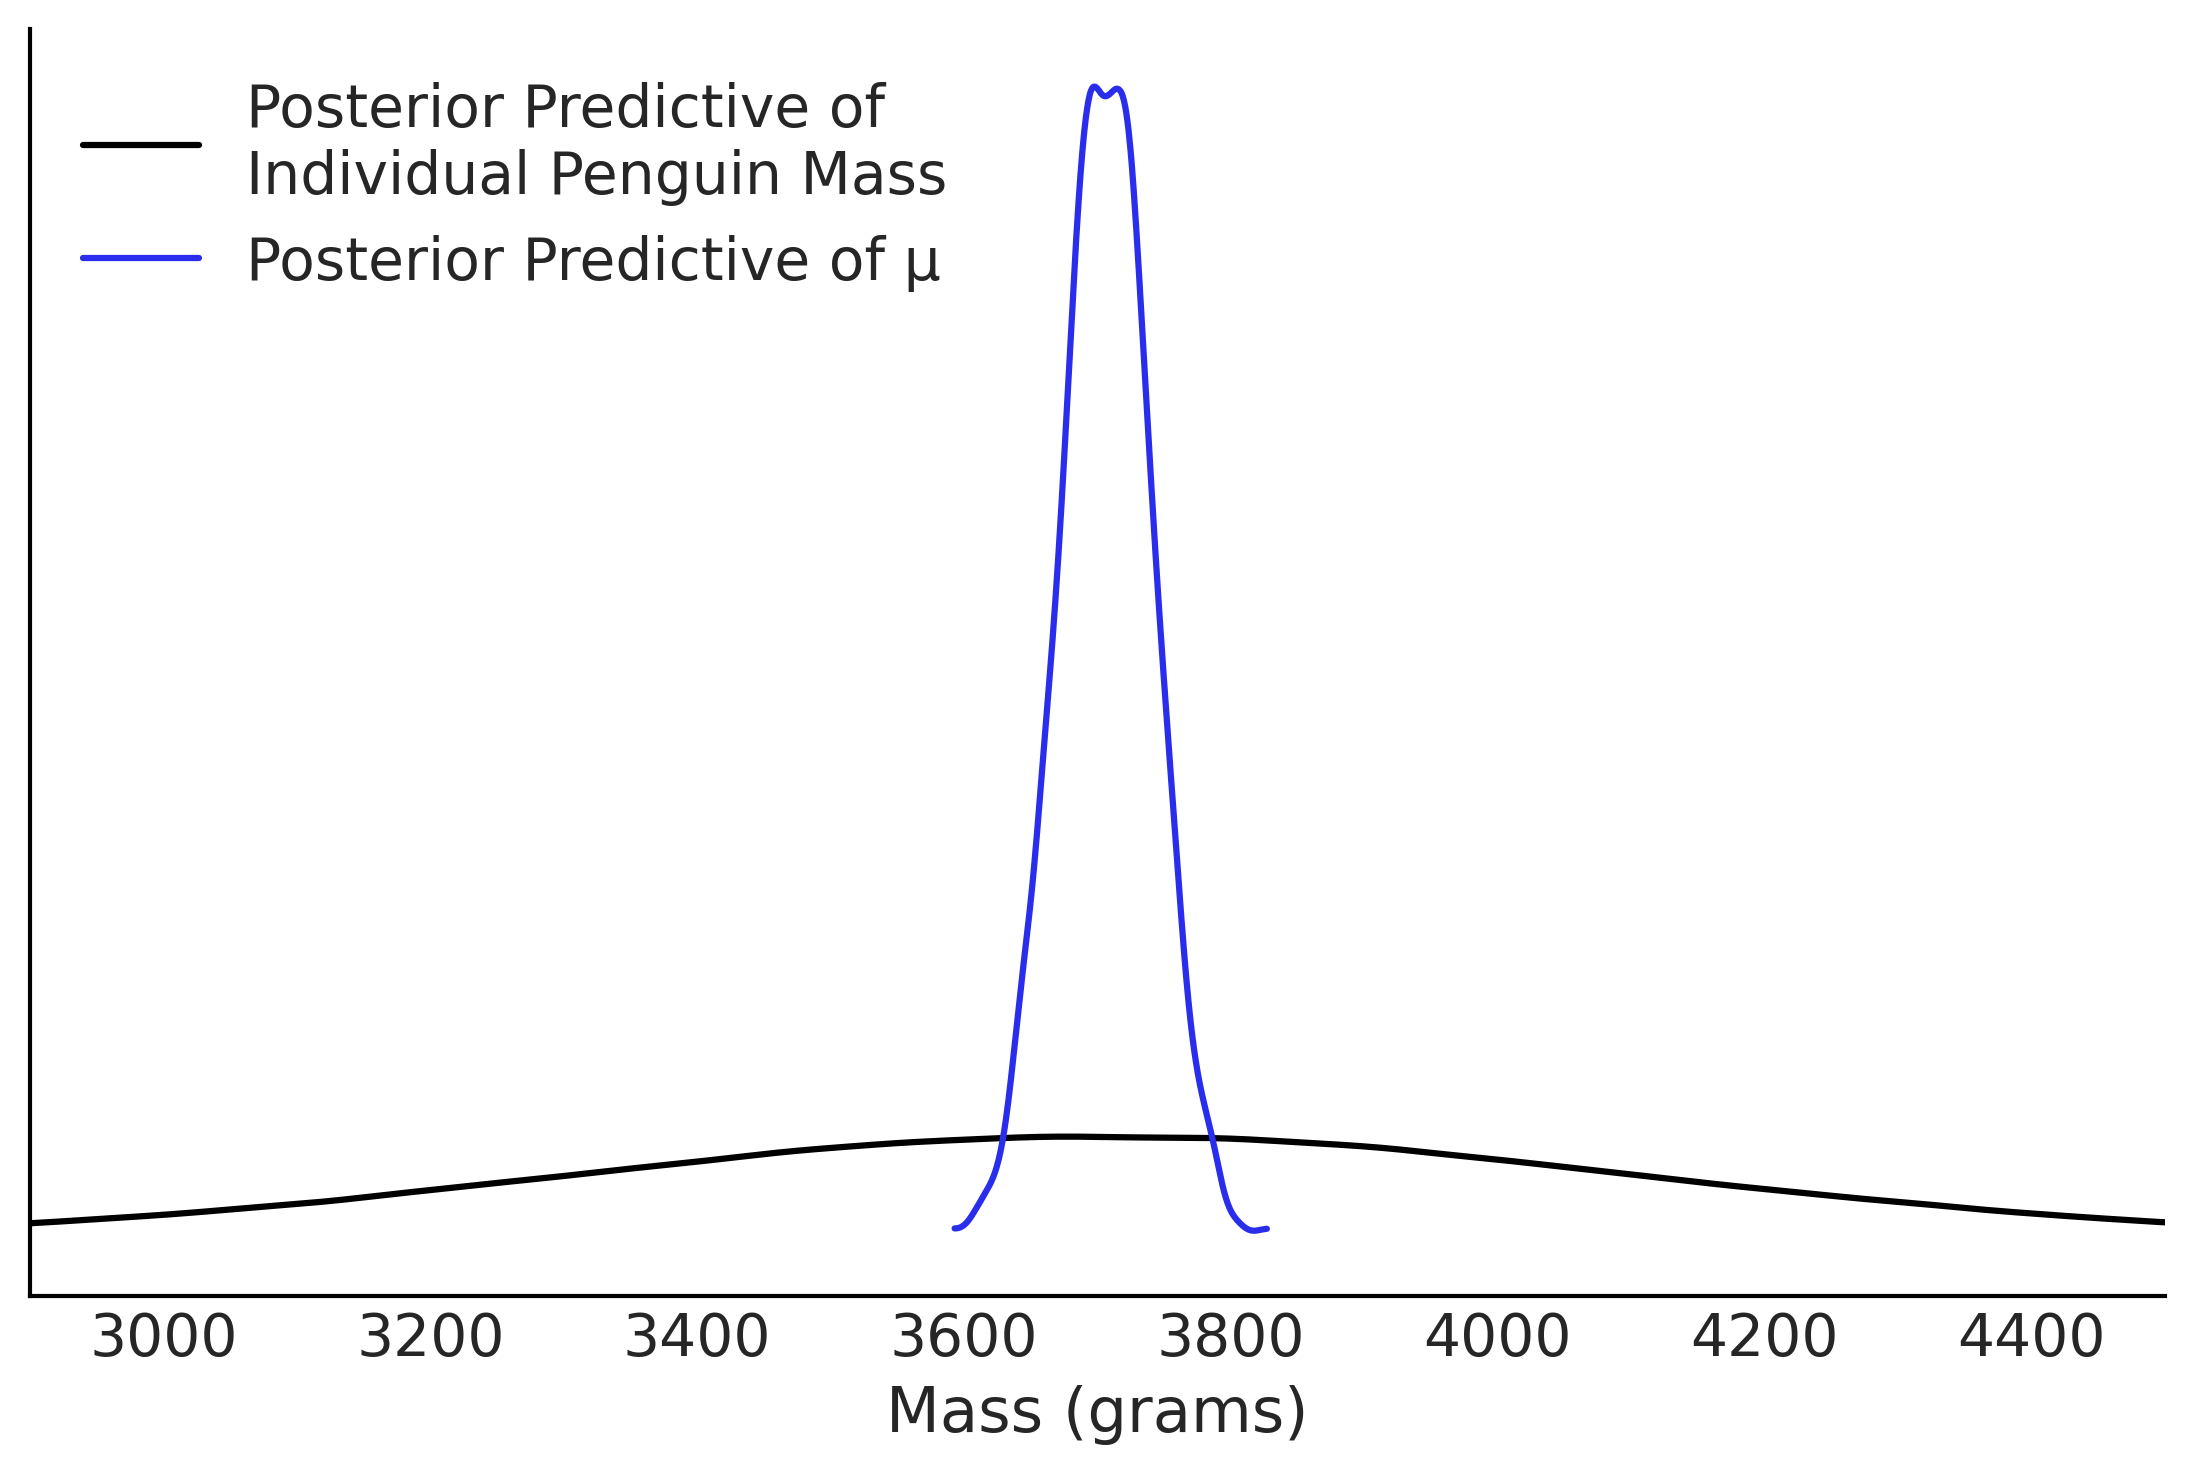

In [20]:
fig, ax = plt.subplots()
az.plot_dist(posterior_predictions.posterior_predictive["mass"], label="Posterior Predictive of \nIndividual Penguin Mass", ax=ax)
az.plot_dist(posterior_predictions.posterior_predictive["μ"],label="Posterior Predictive of μ", color="C4", ax=ax)
ax.set_xlim(2900, 4500);
ax.legend(loc=2)
ax.set_xlabel("Mass (grams)")
ax.set_yticks([])

后验预测分布在贝叶斯背景下是一个特别强大的工具，因为它不仅让我们预测最可能的值，还让我们预测包含我们估计的不确定性的合理值的分布。

### 3.2.3. Centering

上面的模型效果不错，但可惜的是其 $\beta_0$ 不是很有实际意义。可以通过变换让它更可解释。

In [21]:
adelie_flipper_length_c = (adelie_flipper_length_obs -
                           adelie_flipper_length_obs.mean())

In [22]:
with pm.Model() as model_adelie_flipper_regression_c:
    # pm.Data allows us to change the underlying value in a later code block
    adelie_flipper_length = pm.Data("adelie_flipper_length",
                                    adelie_flipper_length_c, mutable=True)
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 4000)
    β_1 = pm.Normal("β_1", 0, 4000)
    μ = pm.Deterministic("μ", β_0 + β_1 * adelie_flipper_length)

    mass = pm.Normal("mass", mu=μ, sigma=σ, observed = adelie_mass_obs)

    inf_data_adelie_flipper_regression_c = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_0, β_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


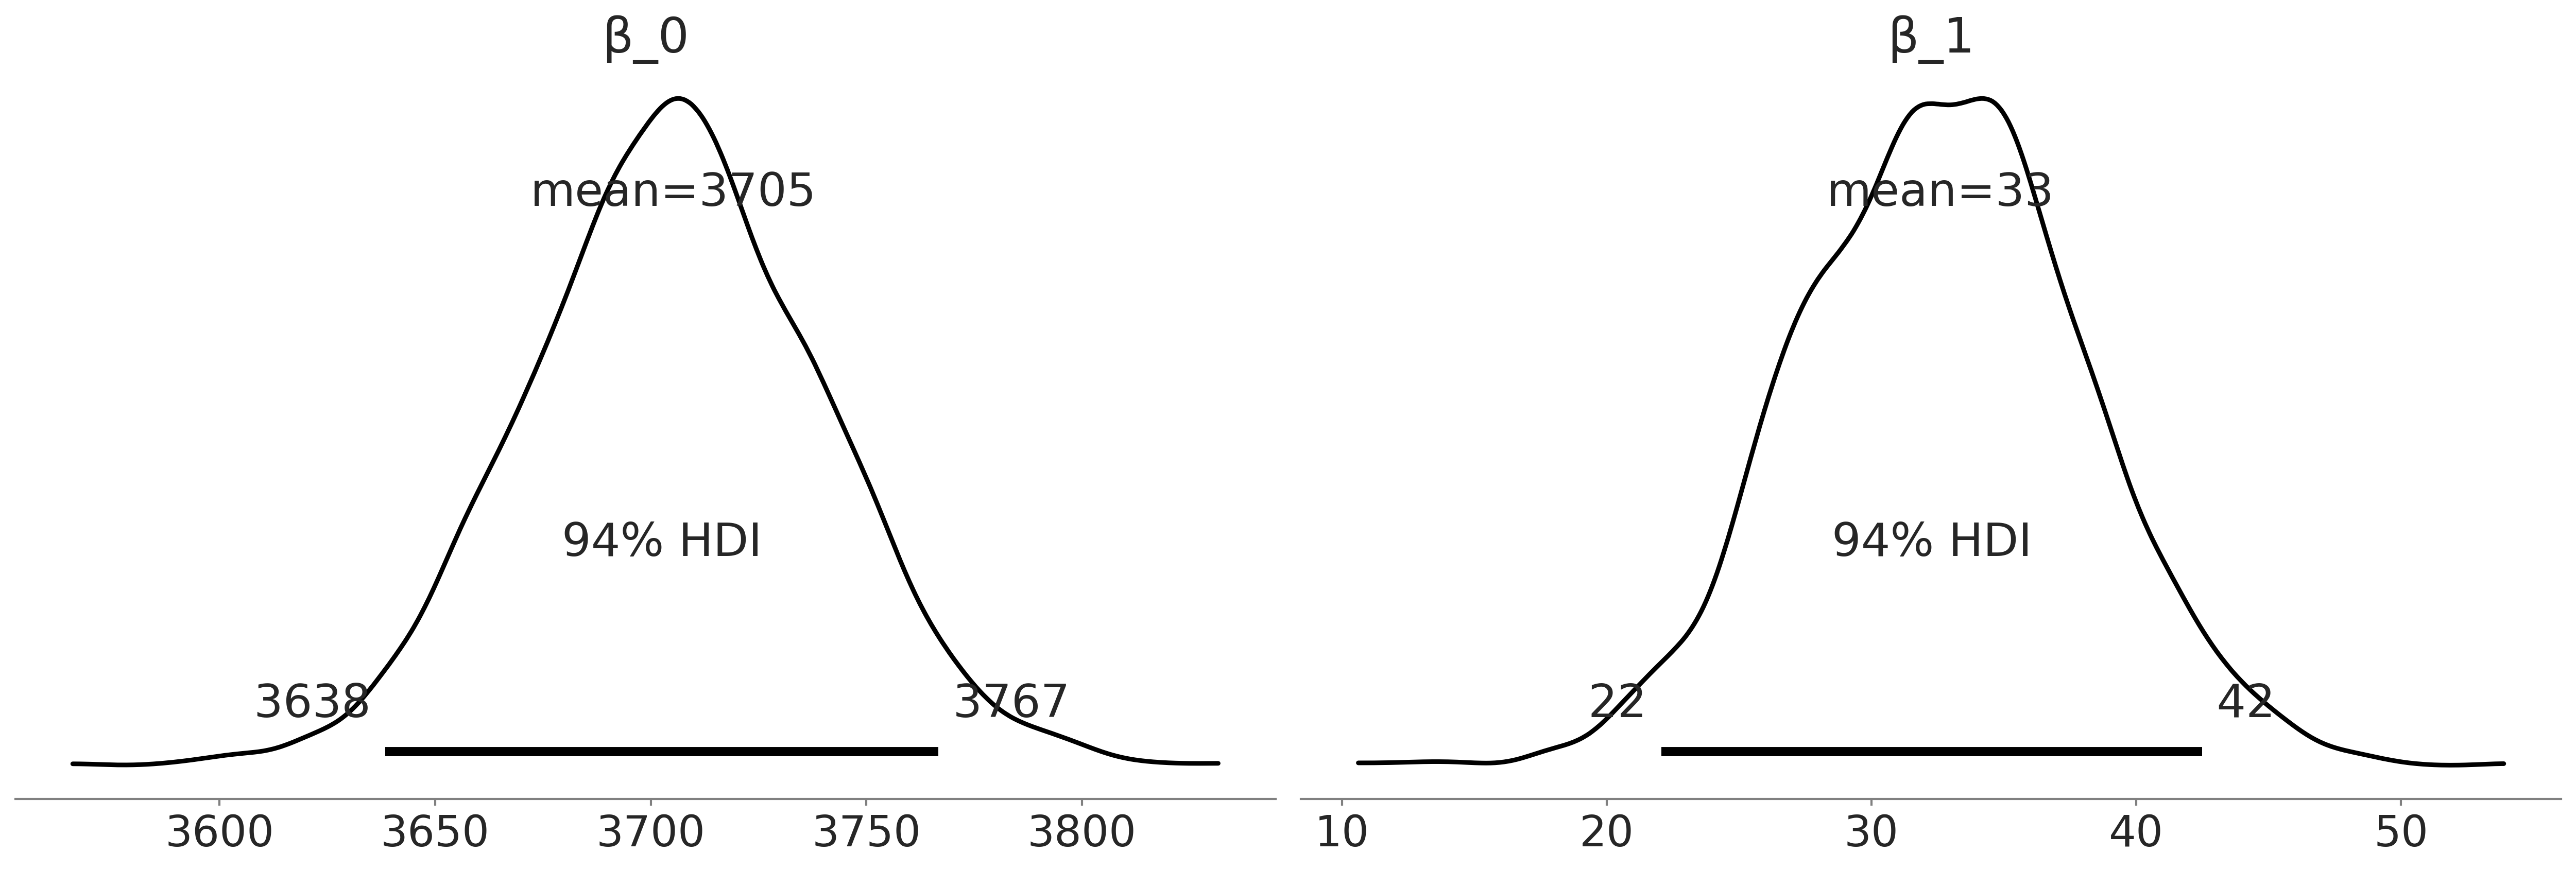

In [23]:
axes = az.plot_posterior(inf_data_adelie_flipper_regression_c, var_names = ["β_0", "β_1"], textsize=20);

重新绘制参数，此时 $\beta_1$ 无变化， $\beta_0$ 有了意义，表示种群的平均质量。

## 3.3. 多变量线性回归

很多物种中不同性别的体型有很大差异，因此我们可以考虑性别作为一个协变量，然后看我们的评估能否更加精确。

In [24]:
# Binary encoding of the categorical predictor
sex_obs = penguins.loc[adelie_mask ,"sex"].replace({"male":0, "female":1})

with pm.Model() as model_penguin_mass_categorical:
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 3000)
    β_1 = pm.Normal("β_1", 0, 3000)
    β_2 = pm.Normal("β_2", 0, 3000)

    μ = pm.Deterministic(
        "μ", β_0 + β_1 * adelie_flipper_length_obs + β_2 * sex_obs)

    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    inf_data_penguin_mass_categorical = pm.sample(
        target_accept=.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_0, β_1, β_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.


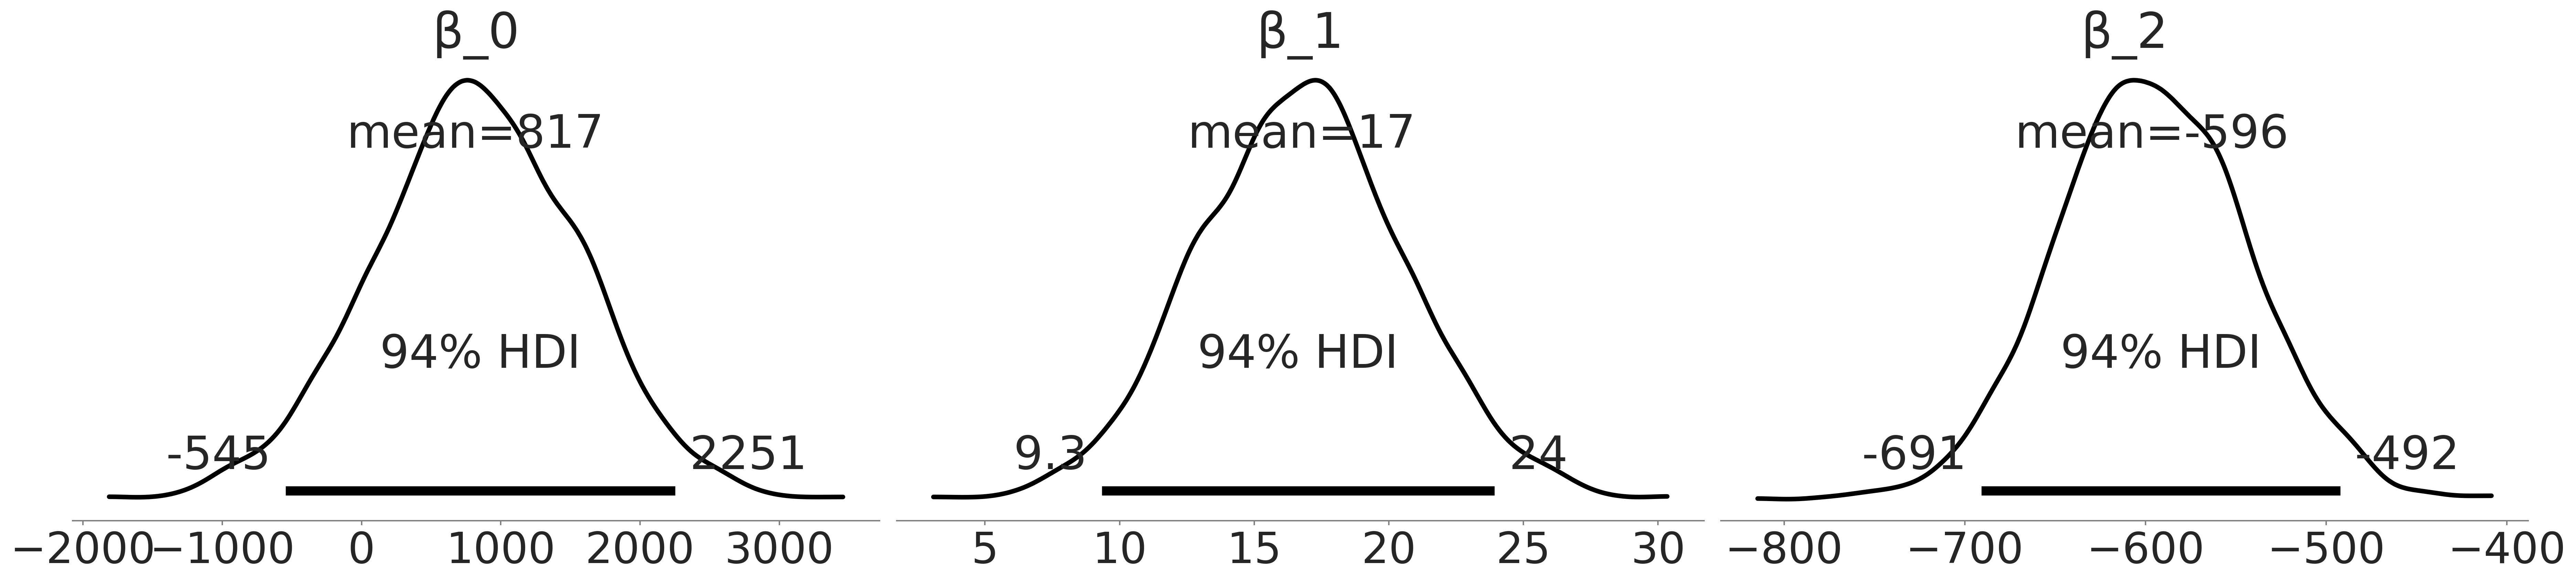

In [25]:
az.plot_posterior(inf_data_penguin_mass_categorical, var_names =["β_0", "β_1", "β_2"], textsize=30);

由于我们将雄性编码为 0，因此后验估计了与具有相同鳍状肢长度的雌性阿德利企鹅相比的质量差异。在解释系数时必须更加小心，如果所有其他协变量保持不变，则系数提供了协变量与响应变量的关系。

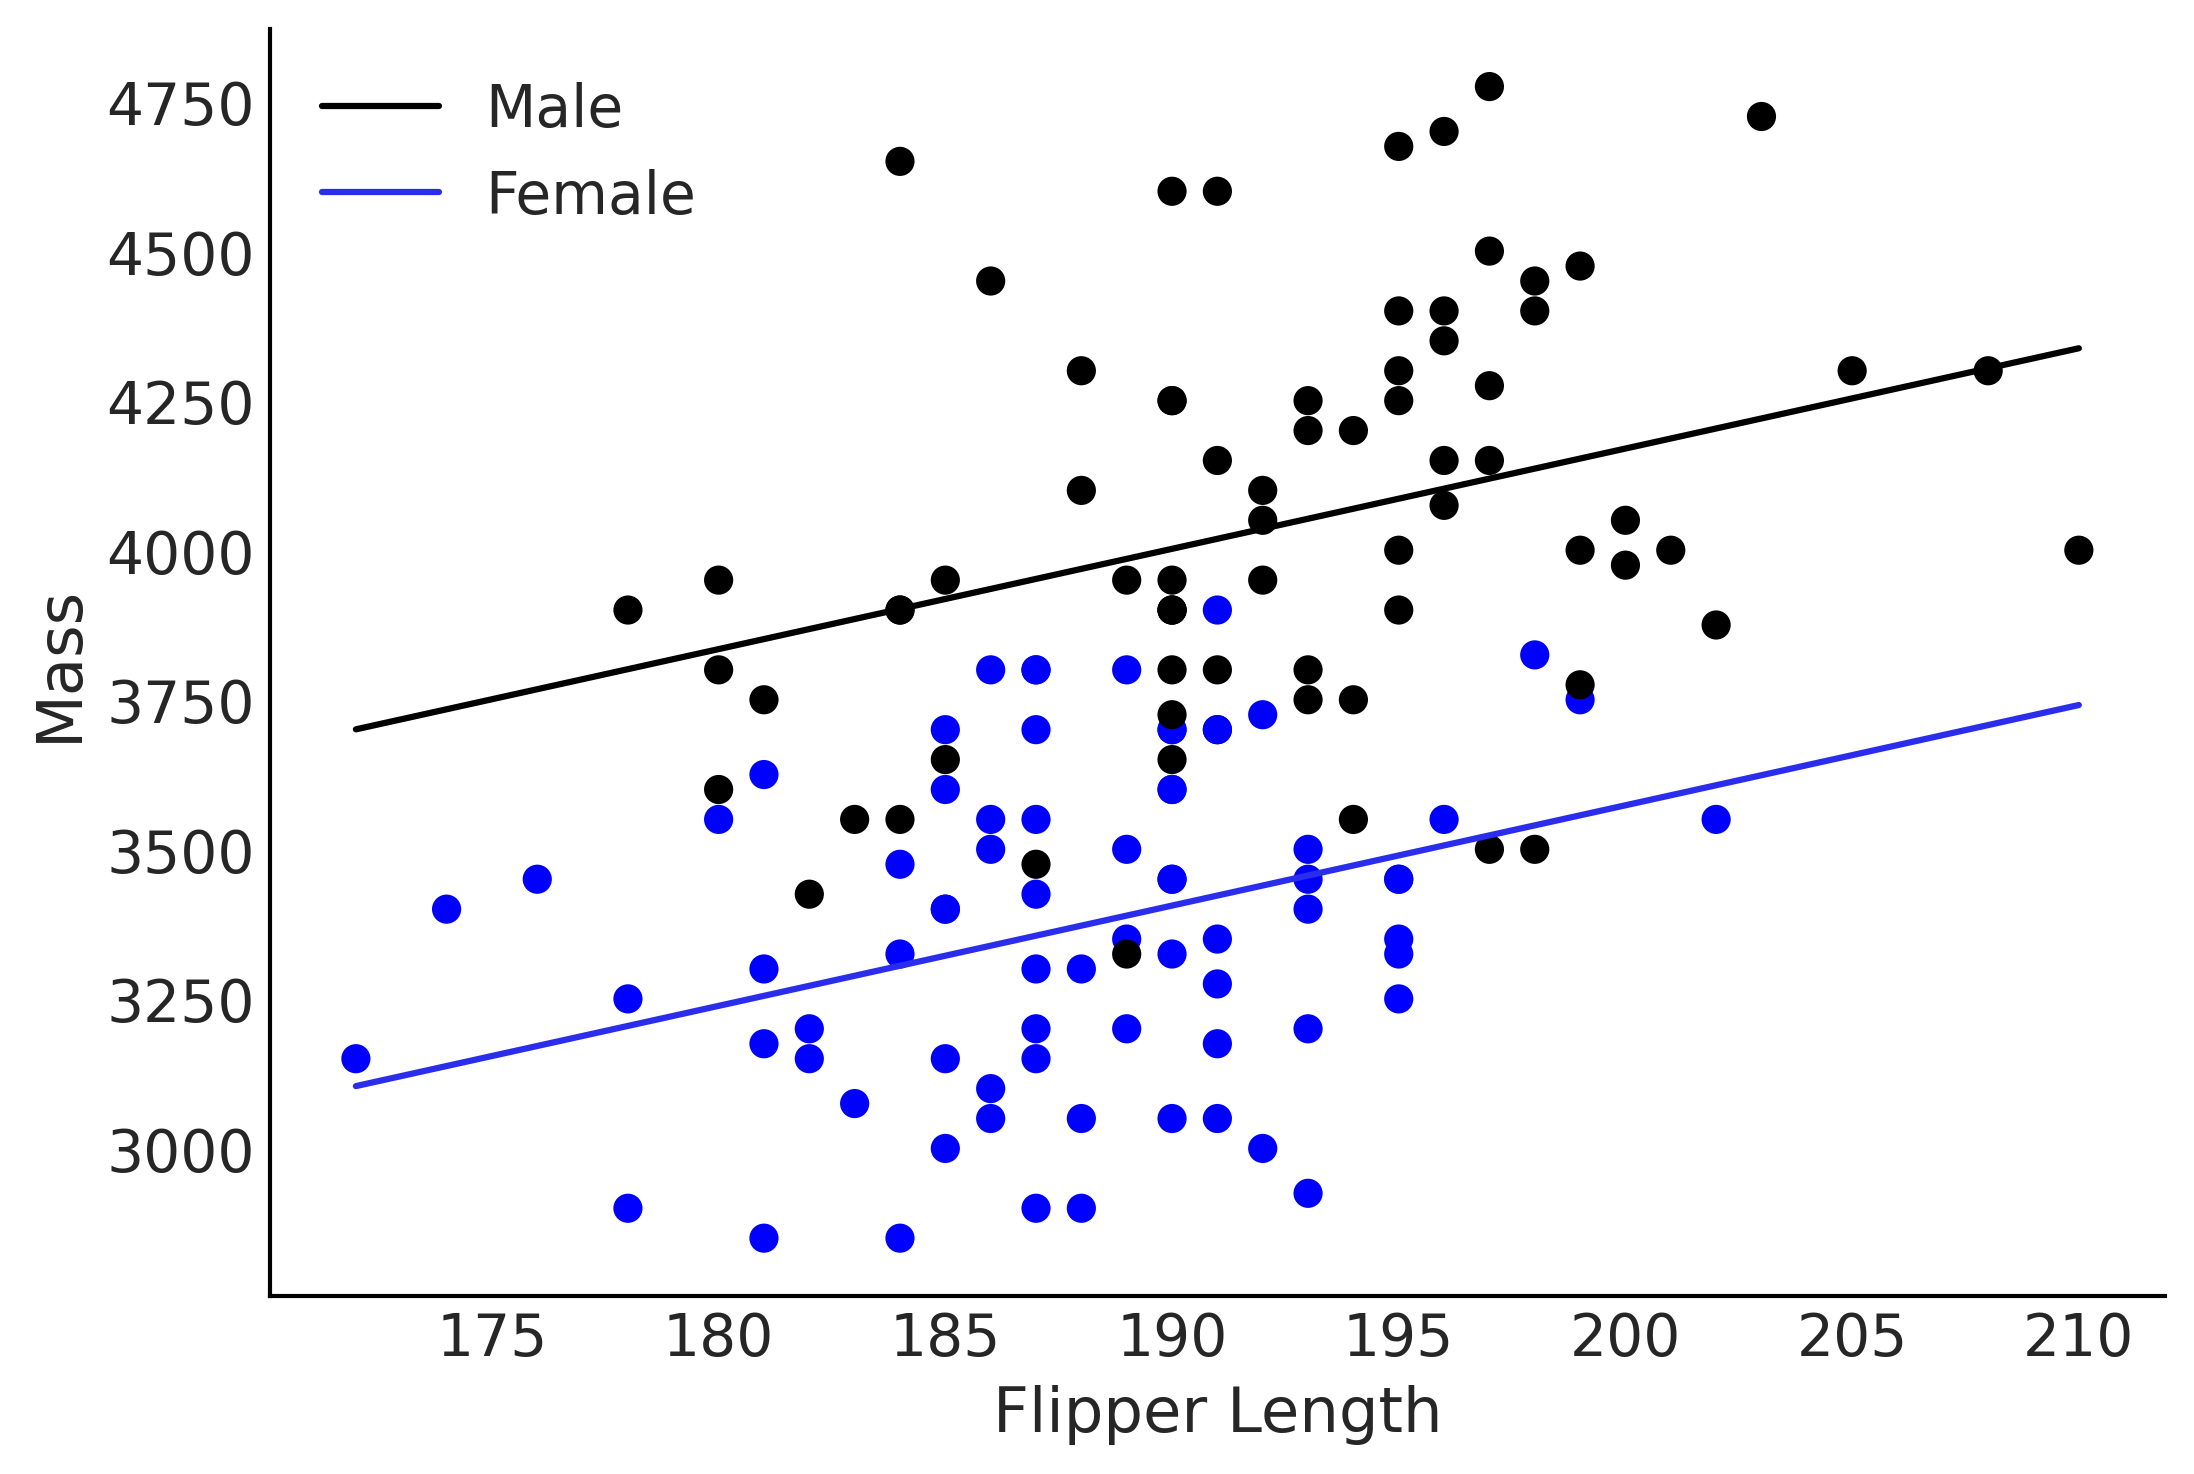

In [26]:
fig, ax = plt.subplots()
alpha_1 = inf_data_penguin_mass_categorical.posterior.mean().to_dict()["data_vars"]["β_0"]["data"]
beta_1 = inf_data_penguin_mass_categorical.posterior.mean().to_dict()["data_vars"]["β_1"]["data"]
beta_2 = inf_data_penguin_mass_categorical.posterior.mean().to_dict()["data_vars"]["β_2"]["data"]


flipper_length = np.linspace(adelie_flipper_length_obs.min(), adelie_flipper_length_obs.max(), 100)

mass_mean_male = alpha_1 + beta_1 * flipper_length
mass_mean_female = alpha_1 + beta_1 * flipper_length + beta_2

ax.plot(flipper_length, mass_mean_male,
         label="Male")

ax.plot(flipper_length, mass_mean_female, c='C4',
         label="Female")

ax.scatter(adelie_flipper_length_obs, adelie_mass_obs, c=[{0:"k", 1:"b"}[code] for code in sex_obs.values])

# Figure out how to do this from inference data
#az.plot_hpd(adelie_flipper_length, trace.get_values(varname="μ"), credible_interval=0.94, color='k', ax=ax)

ax.set_xlabel('Flipper Length')
ax.set_ylabel('Mass');
ax.legend()

验证可发现标准差是否变小了。这种不确定性的减少表明，性别确实为估计企鹅的质量提供了有用信息。

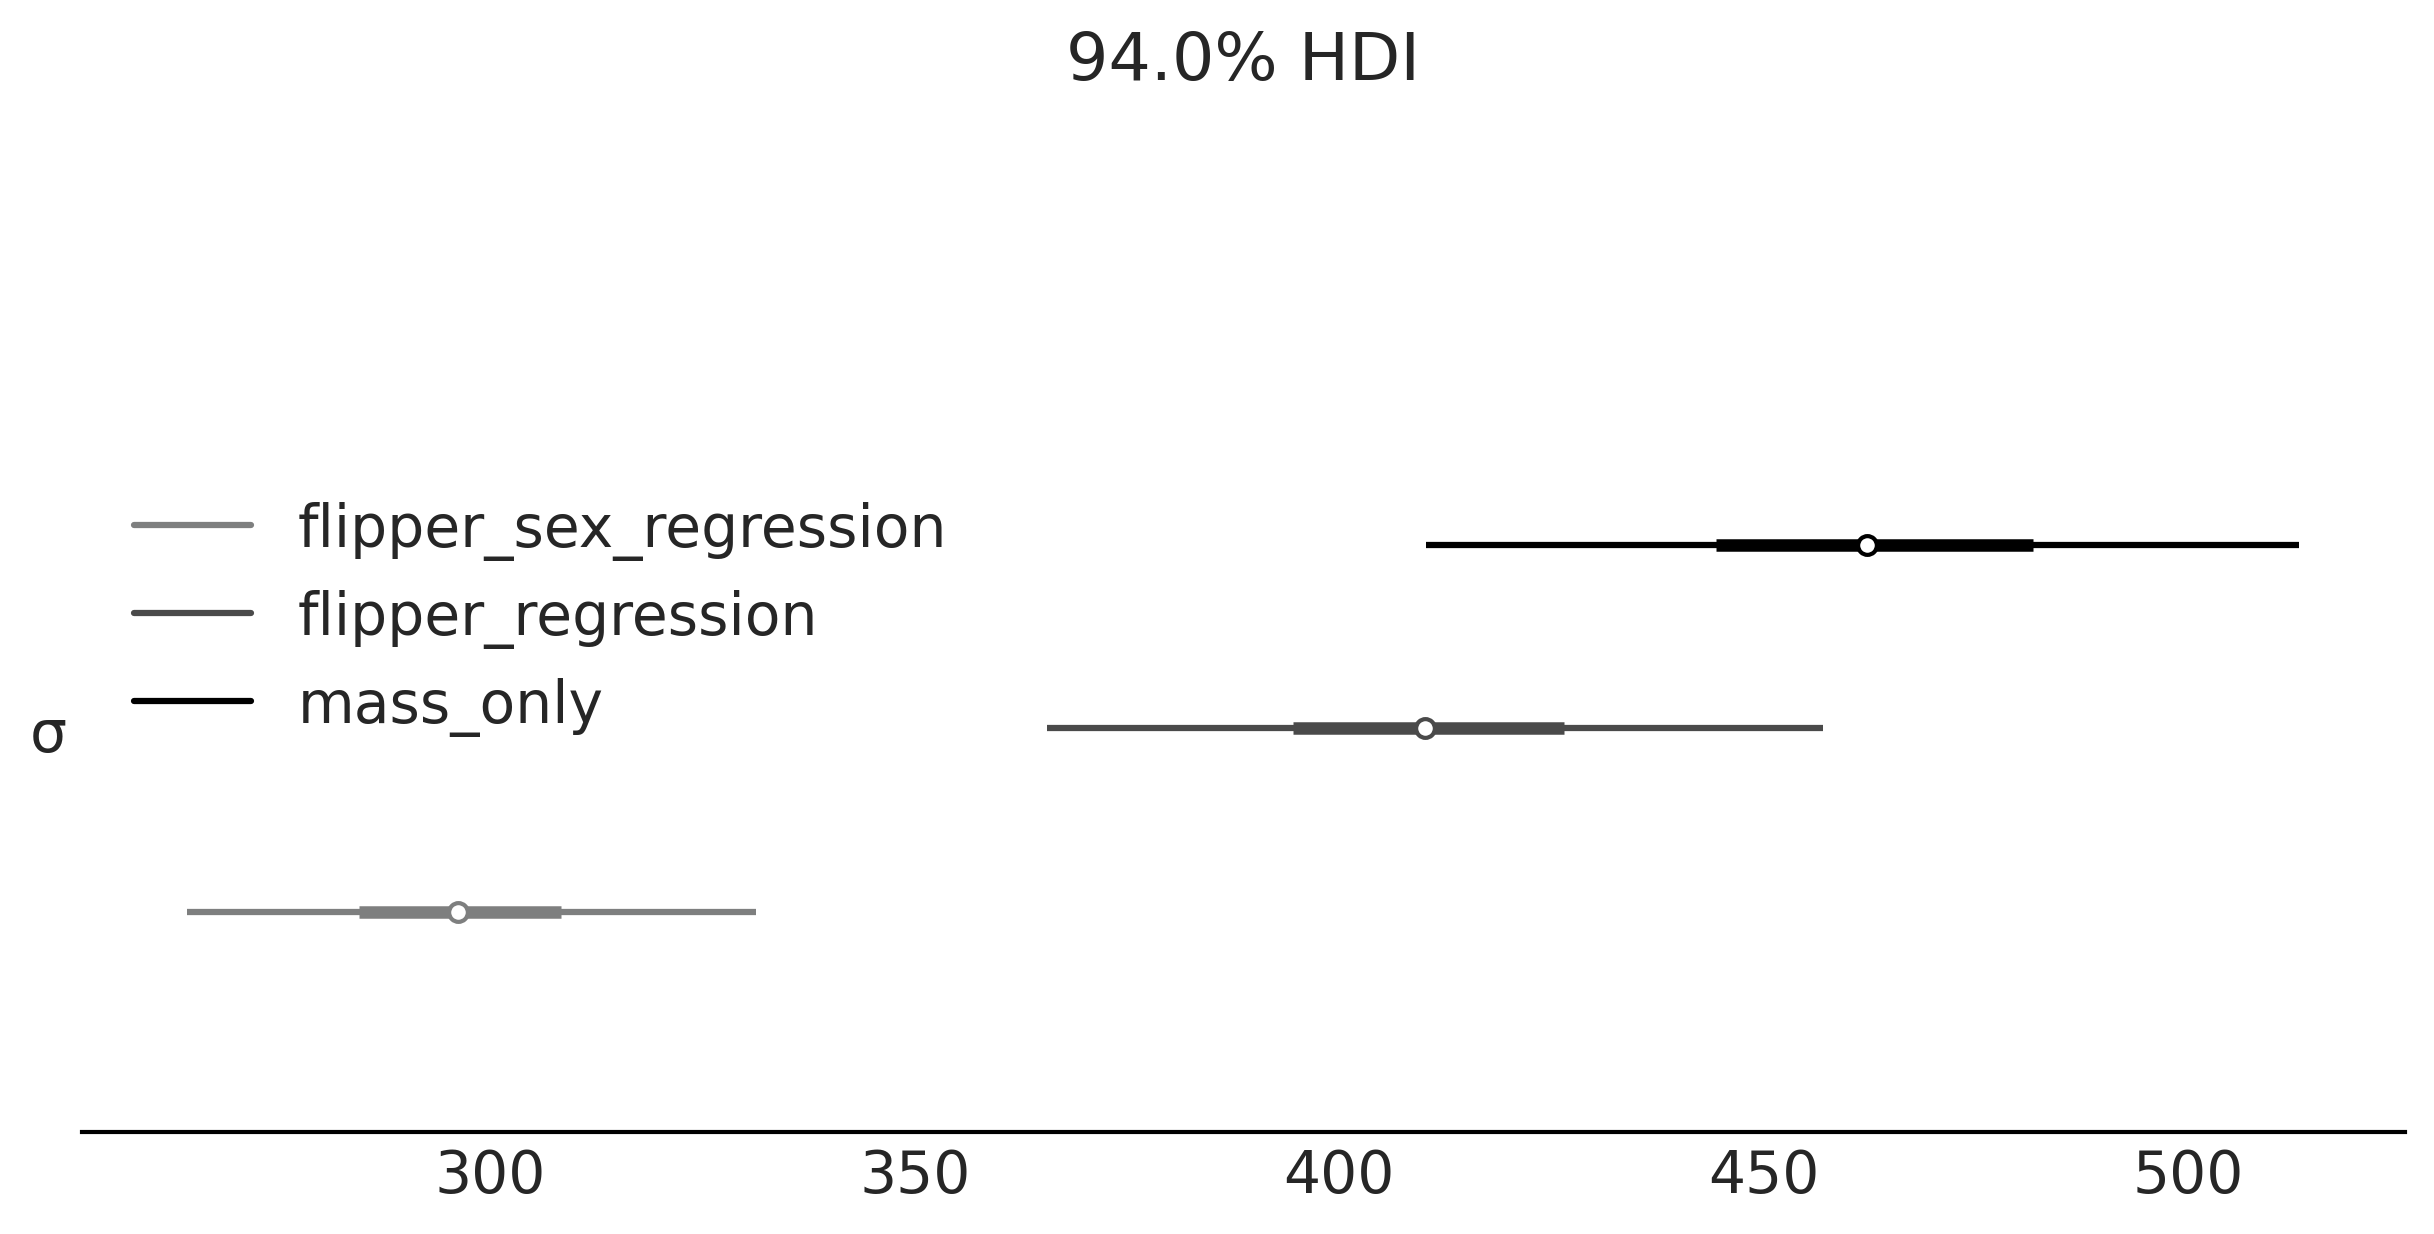

In [27]:
az.plot_forest([inf_data_adelie_penguin_mass,
        inf_data_adelie_flipper_regression,
        inf_data_penguin_mass_categorical],
        model_names=["mass_only", "flipper_regression", "flipper_sex_regression"],
        var_names=["σ"], combined=True, figsize=(8,4))

axes[0].set_title("σ Comparison 94.0 HDI");

<mark>注意：协变量不是越多越好</mark>

> 所有模型拟合算法都会找到信号，即使它是随机噪声。这种现象称为过度拟合，它描述了一种情况，即算法可以轻松地将协变量映射到所见案例中的结果，但无法推广到新的观察结果。在线性回归中，我们可以通过生成 100 个随机协变量用它们拟合随机模拟数据集。即使没有关系，我们的线性模型表现得也会很好。

### 3.3.1. 反事实

可以保持其他协变量不变，然后分析单个变量的影响，这称为反事实分析。下面增加喙长度建立多元线性回归模型，并进行反事实分析。

## 3.4. 广义线性模型

以上所有线性模型都假设观测值的分布是条件高斯分布，但是有时候需要其它分布。比如，对 [0,1] 范围内的概率建模，对 {1, 2, 3,...} 数字建模。    
我们可以继续采用线性函数 $\mathbf{X} \mathit{\beta}$，并且用逆链接函数 $\phi$ 对它进行处理：
$$
\begin{split}
\mu =& \phi(\mathbf{X} \beta) \\
Y \sim& \Psi (\mu, \theta)

\end{split}
$$

逆链接函数的具体目的是映射实数范围的输出到限制区间范围。换句话说，逆链接函数是我们需要采用线性模型并将其推广到更多模型架构的特定“技巧”。

### 3.4.1. 逻辑回归

逻辑回归是一种使用最广泛的广义线性模型之一，用于建模二元分类问题。它通过逆链接函数 logistic 将实数范围的输入映射到 [0,1] 范围的输出。
$$p = \frac{1}{1+e^{-\mathbf{X}\beta}}$$

![](logistic.png)

通过逻辑回归，我们能够使用线性模型来估计事件的概率。我们可以使用决策边界来在集合中进行预测 0 或 1 。如果决策边界设置为 0.5 ，对于具有截距和一个协变量的模型，我们有：
$$
\begin{split}
0.5 &= logistic(\beta_{0} + \beta_{1}*x) \\
logit(0.5) &= \beta_{0} + \beta_{1}*x \\
0 &= \beta_{0} + \beta_{1}*x \\
x &= -\frac{\beta_{0}}{\beta_{1}} \\
\end{split}
$$

其中 logit 是 logistic 的逆函数，也就是说模型训练后，我们也可以通过 $\beta_0$ 和 $\beta_1$ 来计算 $x$ 的决策边界。

### 3.4.2. 企鹅分类

如果给出企鹅的质量、性别、喙长度和脚蹼长度，我们能否预测其种类么？下面用 Adelie 和 Chinstrap 企鹅做二分类任务

In [57]:
species_filter = penguins["species"].isin(["Adelie", "Chinstrap"])
bill_length_obs = penguins.loc[species_filter, "bill_length_mm"].values
species = pd.Categorical(penguins.loc[species_filter, "species"])

with pm.Model() as model_logistic_penguins_bill_length:
    β_0 = pm.Normal("β_0", mu=0, sigma=10)
    β_1 = pm.Normal("β_1", mu=0, sigma=10)

    μ = β_0 + pm.math.dot(bill_length_obs, β_1)

    # Application of our sigmoid  link function
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))

    # Useful for plotting the decision boundary later
    bd = pm.Deterministic("bd", -β_0/β_1)

    # Note the change in likelihood
    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)
    
    loglik = pm.Deterministic('log_likelihood', pm.logp(yl, species.codes))

    prior_predictive_logistic_penguins_bill_length = pm.sample_prior_predictive(samples=10000)
    trace_logistic_penguins_bill_length = pm.sample(5000, random_seed=0, chains=2)
    posterior_predictive_logistic_penguins_bill_length = pm.sample_posterior_predictive(trace_logistic_penguins_bill_length)
    trace_logistic_penguins_bill_length.extend(posterior_predictive_logistic_penguins_bill_length)

Sampling: [yl, β_0, β_1]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [β_0, β_1]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [yl]


在泛化线性模型中，先验模型参数与结果的关系更难理解了。我们可以利用先验的预测样本来可视化预期的观察结果。

[Text(0.0, 0, 'Adelie: 0'), Text(1.0, 0, 'Chinstrap: 1')]

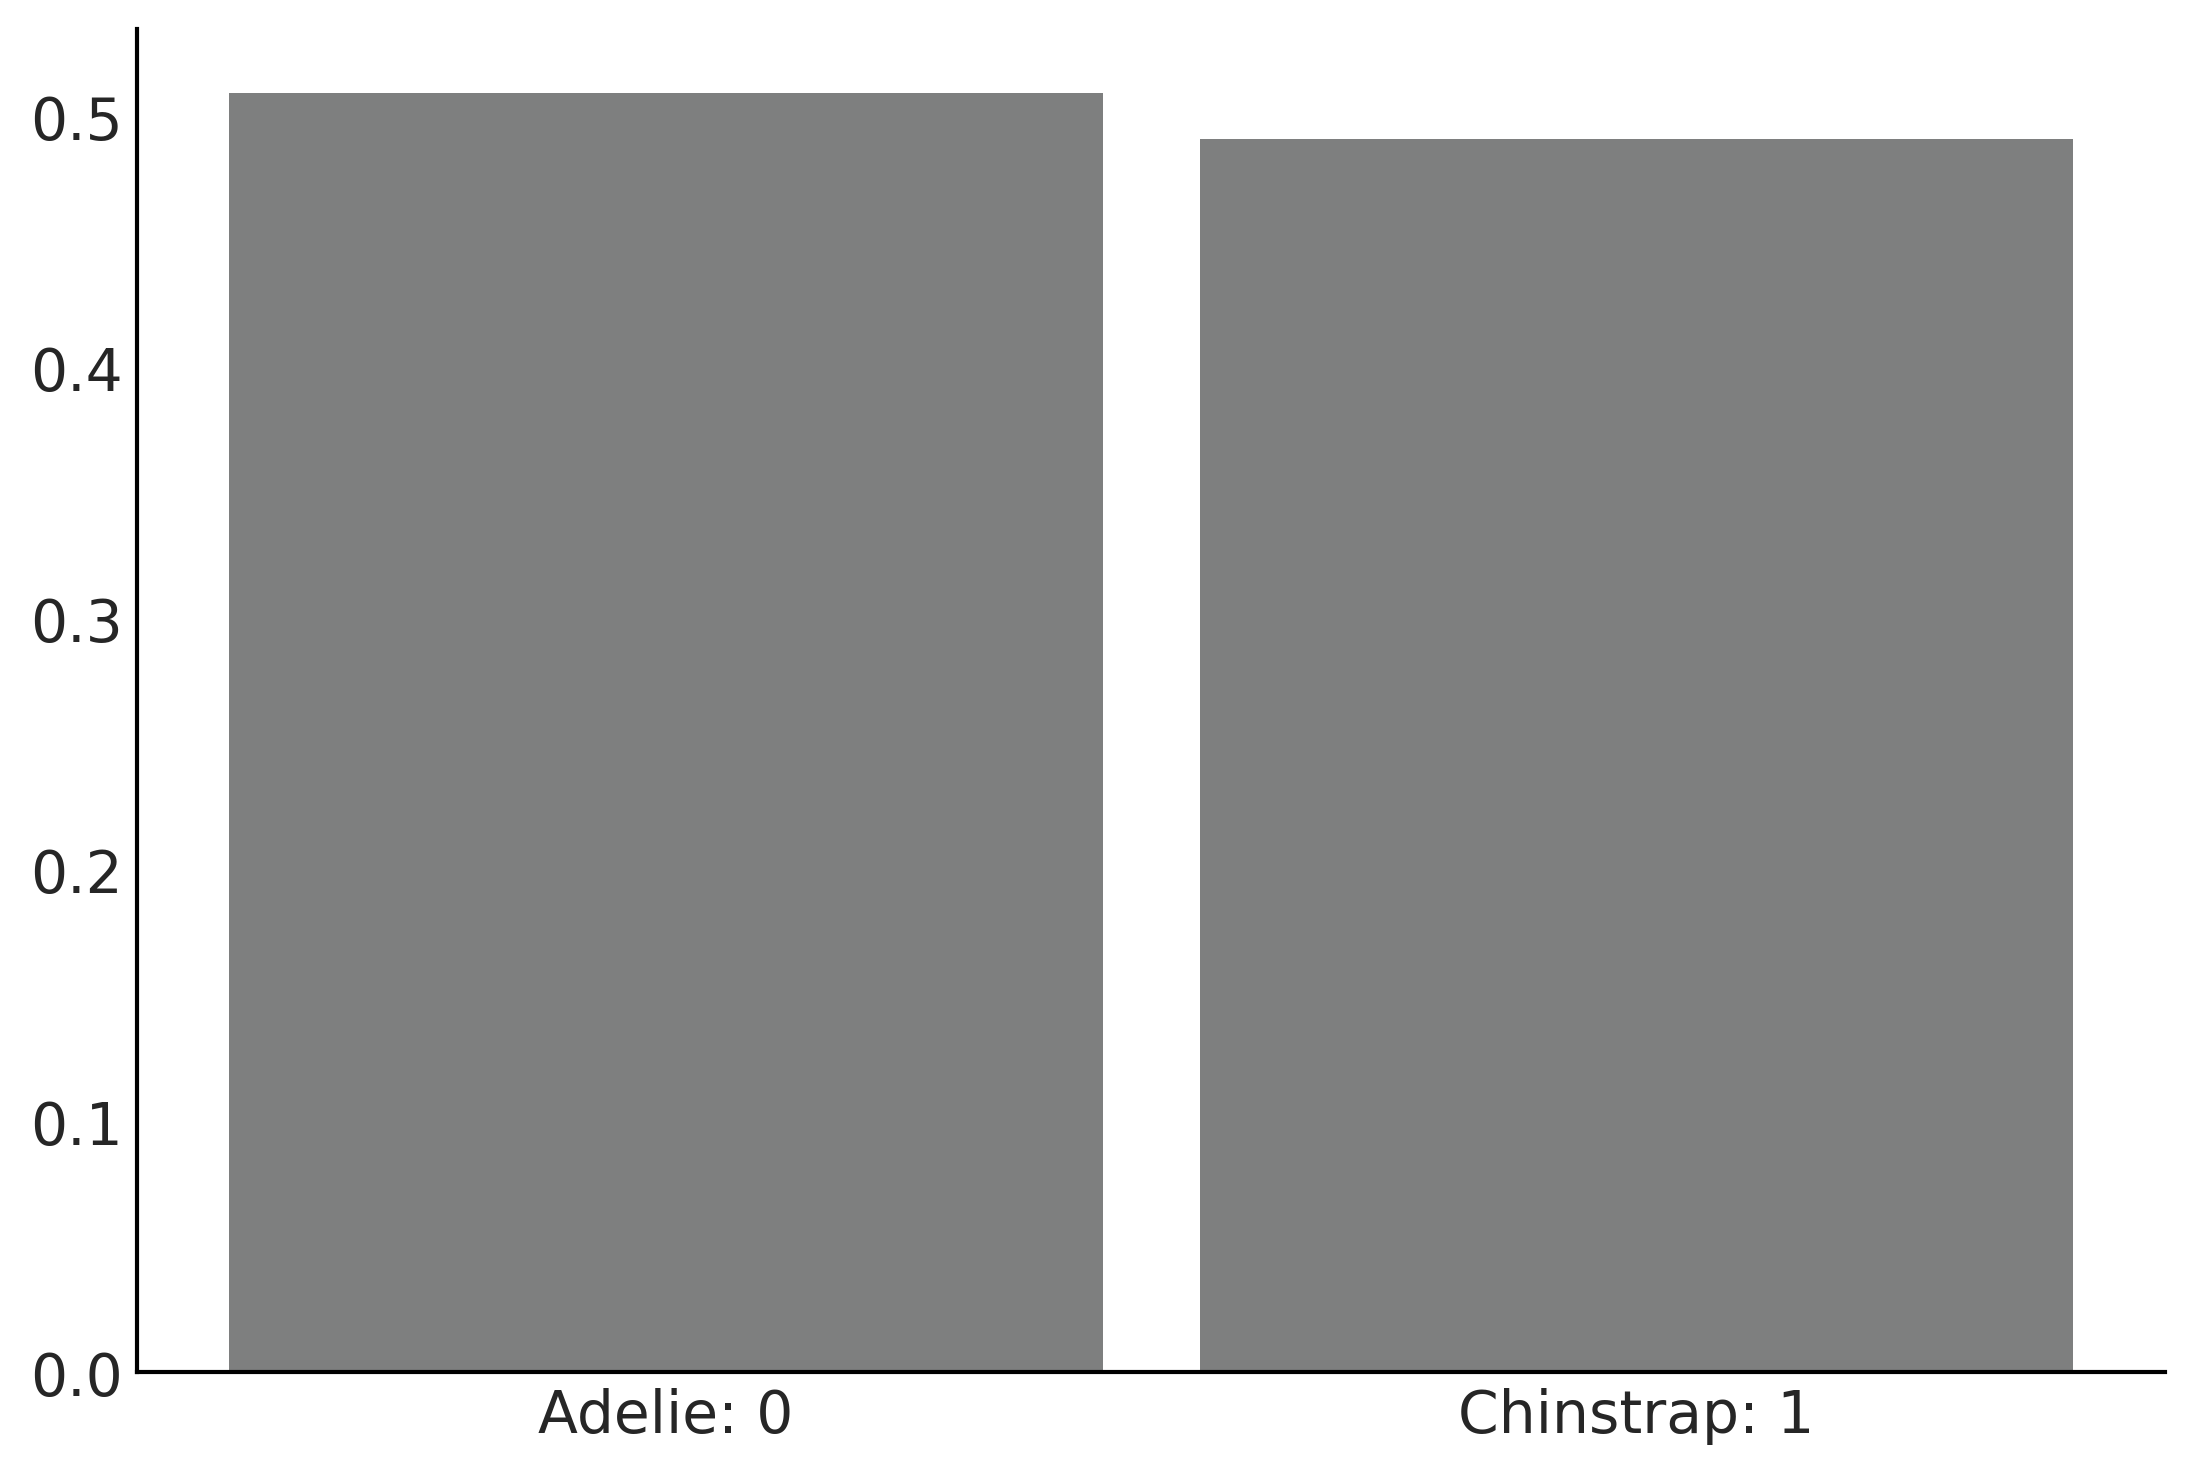

In [34]:
ax = az.plot_dist(prior_predictive_logistic_penguins_bill_length.prior_predictive.data_vars['yl'], color="C2")
ax.set_xticklabels(["Adelie: 0", "Chinstrap: 1"] )

从上图看，先验中认为两种企鹅可能性差不多，这是符合预期的。     

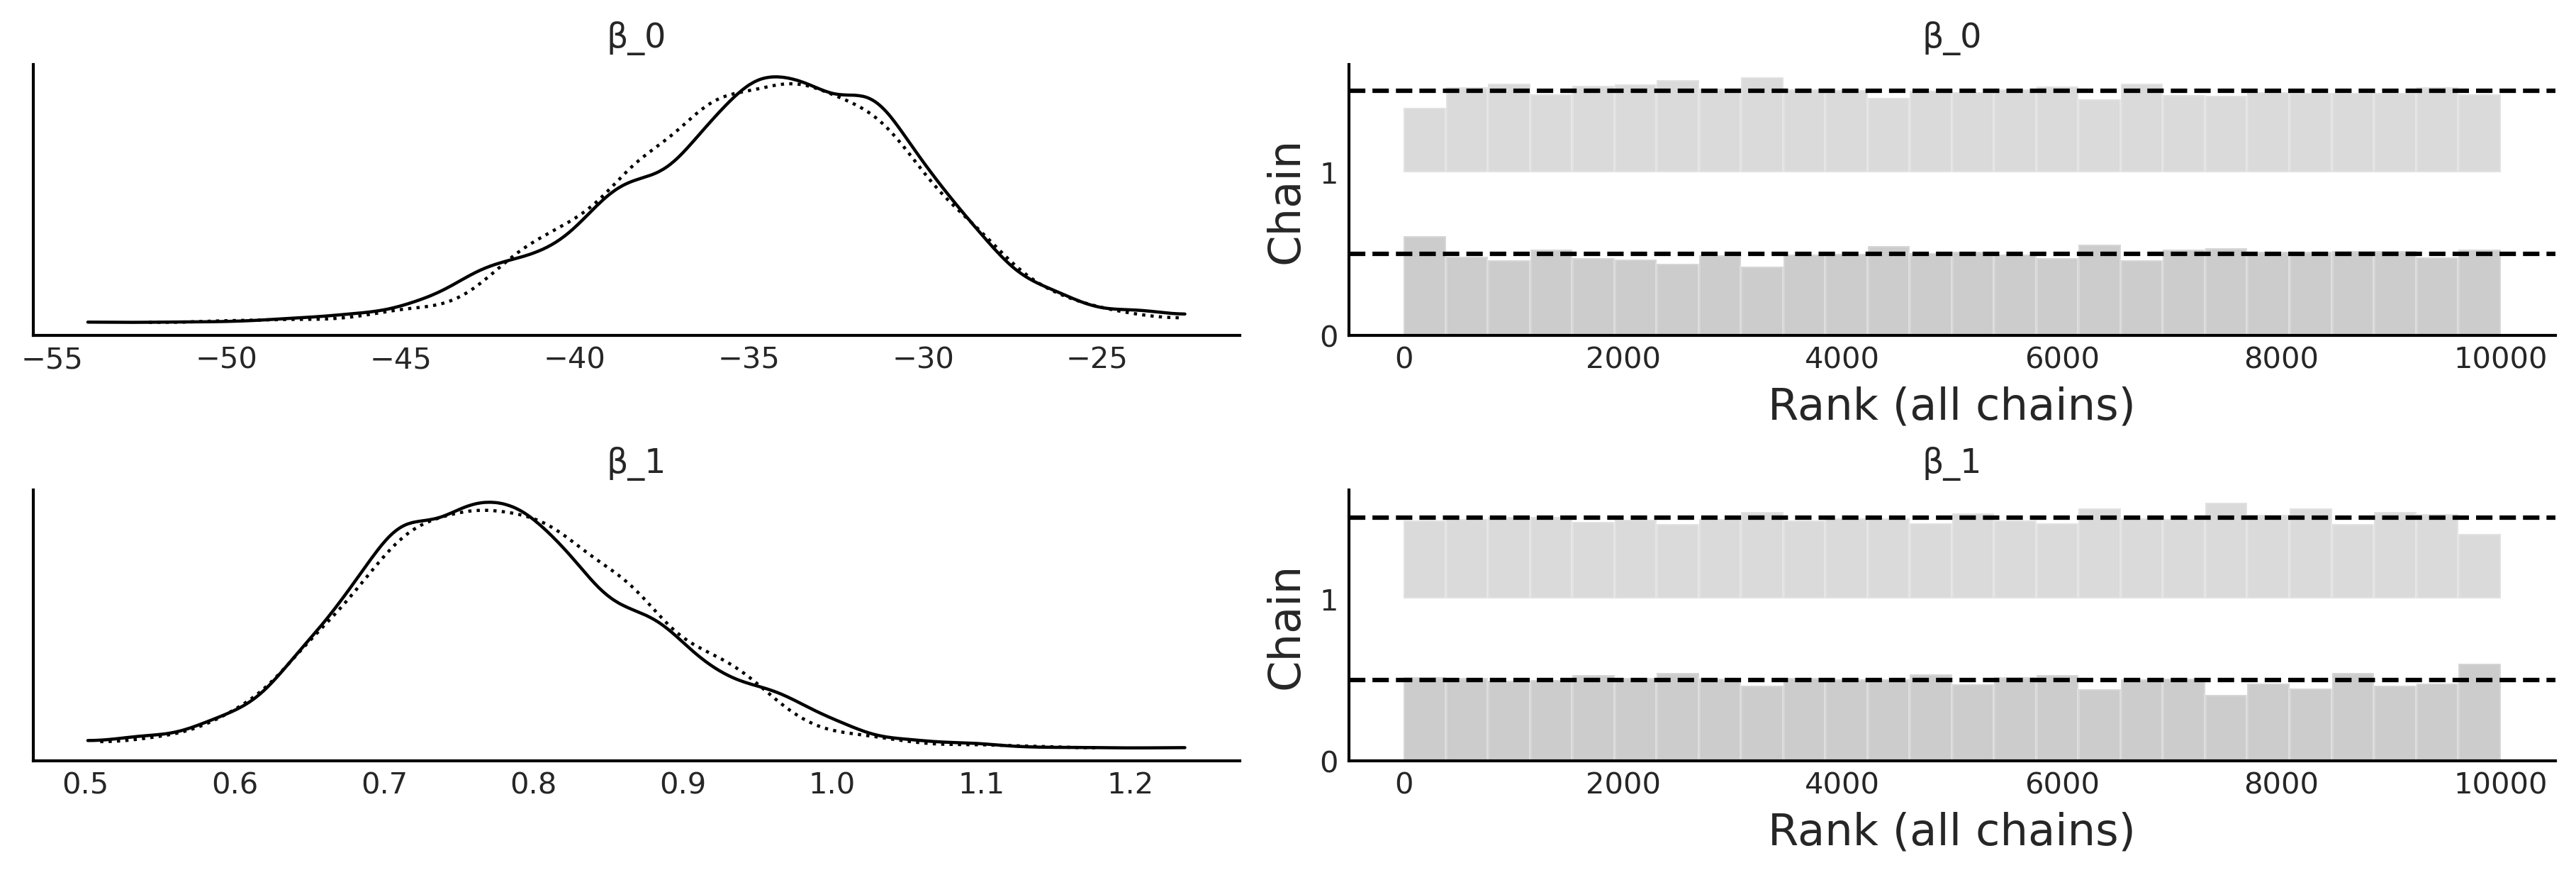

In [35]:
az.plot_trace(trace_logistic_penguins_bill_length, var_names=["β_0", "β_1"], kind="rank_bars");

在训练模型后，可以通过 `az.summary` 来查看参数的后验分布。可以发现 $\beta_1$ 的 HDI 不包含0，并且44mm的喙长度大概是分类边界。

In [36]:
az.summary(trace_logistic_penguins_bill_length, var_names=["β_0", "β_1"], kind="stats")

mean     sd  hdi_3%  hdi_97%
β_0 -34.557  4.315 -43.199  -27.244
β_1   0.781  0.099   0.606    0.974

用下图展示更加直接。

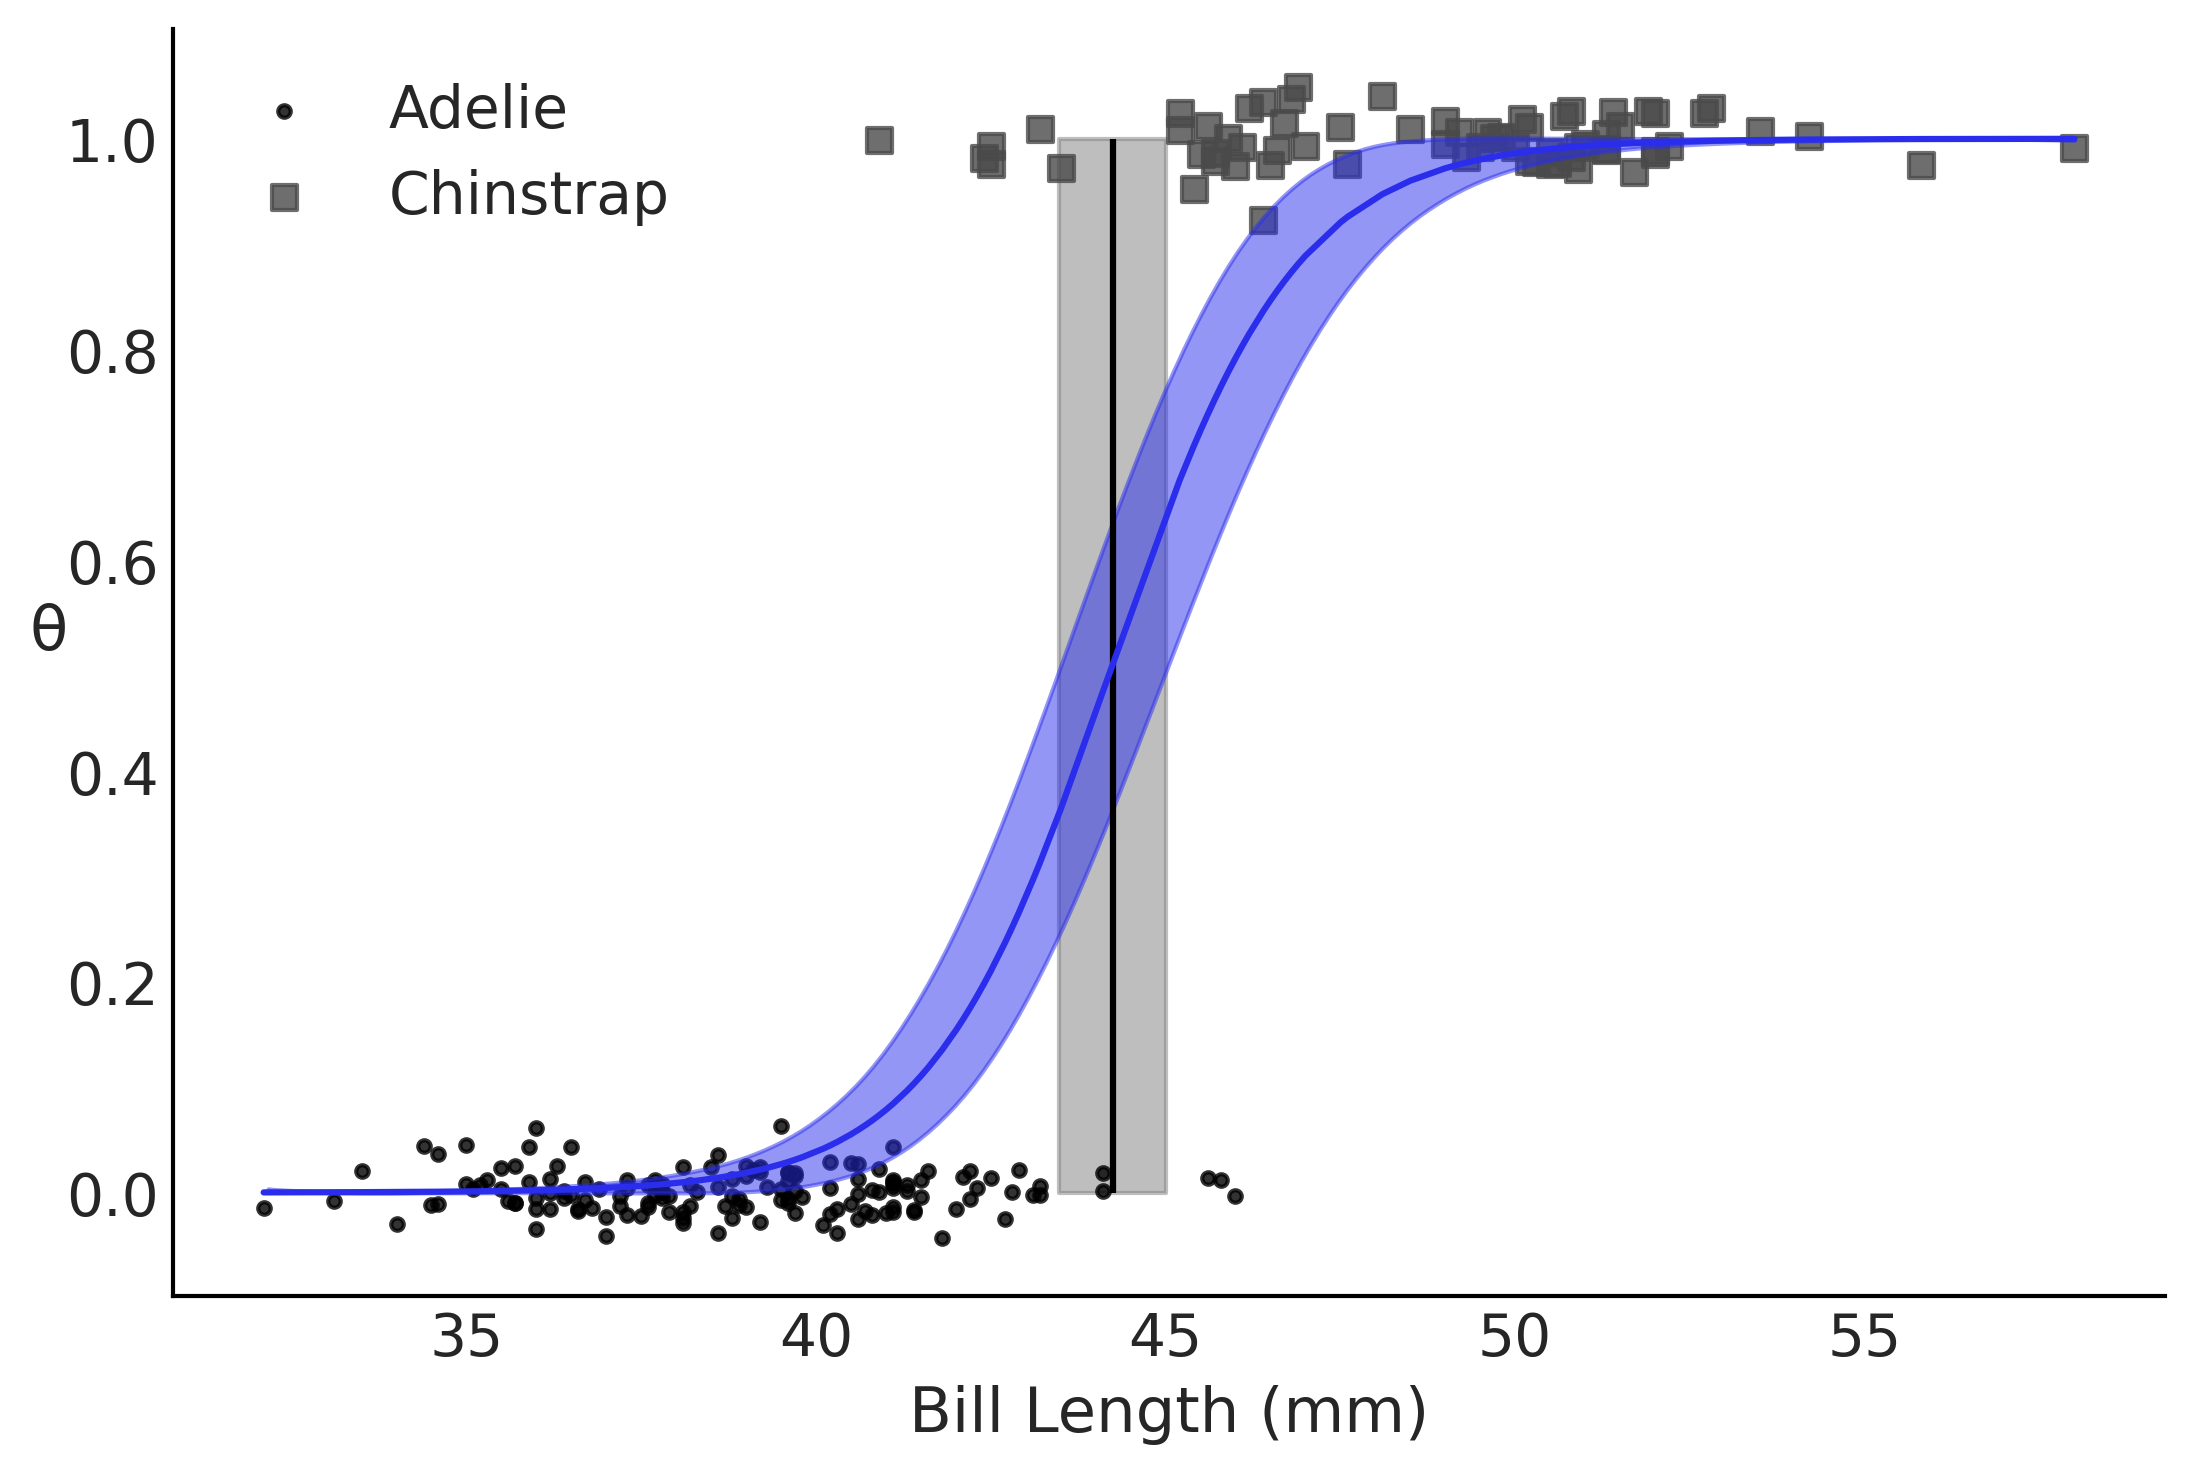

In [37]:
fig, ax = plt.subplots()

theta = trace_logistic_penguins_bill_length.posterior["θ"].values.reshape((-1,214)).mean(axis=0)


idx = np.argsort(bill_length_obs)

# Decision Boundary
ax.vlines(trace_logistic_penguins_bill_length.posterior["bd"].values.mean(), 0, 1, color='k')
bd_hpd = az.hdi(trace_logistic_penguins_bill_length.posterior["bd"].values.flatten(), ax=ax)
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C2', alpha=0.5)


for i, (label, marker) in enumerate(zip(species.categories, (".", "s"))):
    _filter = (species.codes == i)
    x = bill_length_obs[_filter]
    y = np.random.normal(i, 0.02, size=_filter.sum())
    ax.scatter(bill_length_obs[_filter], y, marker=marker, label=label, alpha=.8)

az.plot_hdi(bill_length_obs, trace_logistic_penguins_bill_length.posterior["θ"].values, color='C4', ax=ax, plot_kwargs={"zorder":10})
ax.plot(bill_length_obs[idx], theta[idx], color='C4', zorder=10)

ax.set_xlabel("Bill Length (mm)")
ax.set_ylabel('θ', rotation=0)
plt.legend()

如果用重量来预测呢？

In [39]:
mass_obs = penguins.loc[species_filter, "body_mass_g"].values

with pm.Model() as model_logistic_penguins_mass:
    β_0 = pm.Normal("β_0", mu=0, sigma=10)
    β_1 = pm.Normal("β_1", mu=0, sigma=10)

    μ = β_0 + pm.math.dot(mass_obs, β_1)
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    bd = pm.Deterministic("bd", -β_0/β_1)

    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)

    inf_data_logistic_penguins_mass = pm.sample(
        5000, target_accept=.9, return_inferencedata=True)
    
    loglik = pm.Deterministic('log_likelihood', pm.logp(yl, species.codes))
    
    trace_logistic_penguins_mass = pm.sample(
        5000, random_seed=0, chains=2, target_accept=.9)
    posterior_predictive_logistic_penguins_mass = pm.sample_posterior_predictive(
        trace_logistic_penguins_mass)
    trace_logistic_penguins_mass.extend(posterior_predictive_logistic_penguins_mass)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_0, β_1]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 33 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 5000 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [β_0, β_1]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [yl]


In [40]:
az.summary(inf_data_logistic_penguins_mass, var_names=["β_0", "β_1"], kind="stats")

mean     sd  hdi_3%  hdi_97%
β_0 -1.145  1.111  -3.532    0.911
β_1  0.081  0.140  -0.000    0.324

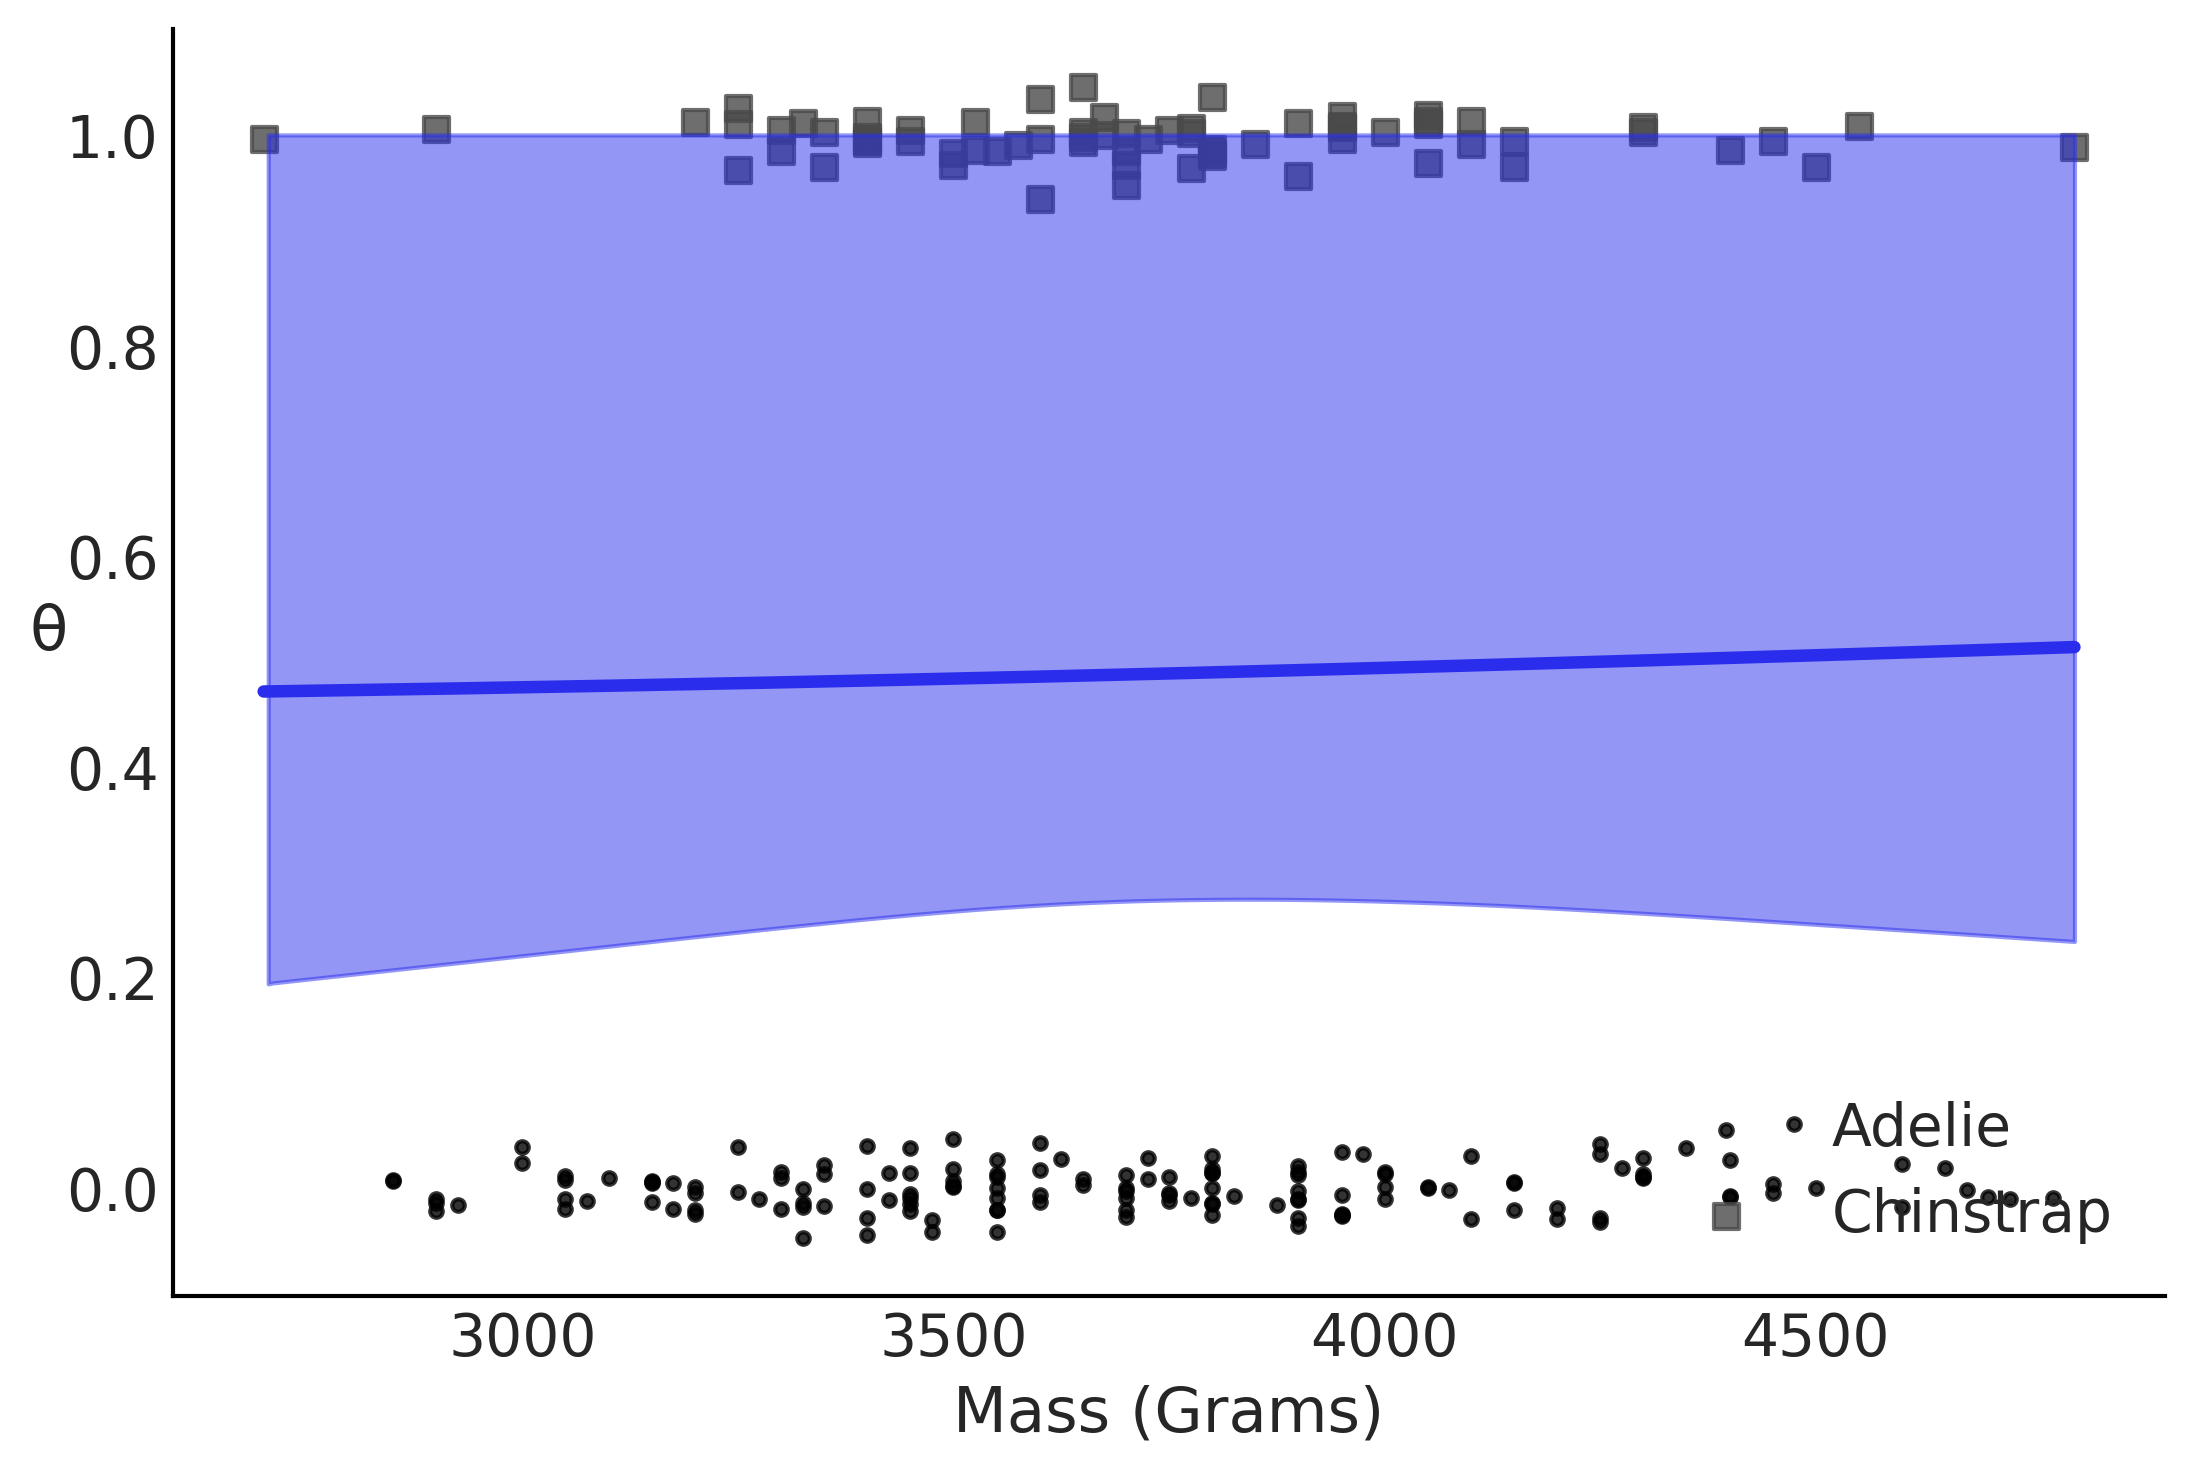

In [41]:
theta = inf_data_logistic_penguins_mass.posterior['θ'].values
bd = inf_data_logistic_penguins_mass.posterior['bd'].values


fig, ax = plt.subplots()
theta = theta.reshape(-1,214).mean(axis=0)
idx = np.argsort(mass_obs)

ax.plot(mass_obs[idx], theta[idx], color='C4', lw=3)
for i, (label, marker) in enumerate(zip(species.categories, (".", "s"))):
    _filter = (species.codes == i)
    x = mass_obs[_filter]
    y = np.random.normal(i, 0.02, size=_filter.sum())
    ax.scatter(mass_obs[_filter], y, marker=marker, label=label, alpha=.8)

az.plot_hdi(mass_obs, inf_data_logistic_penguins_mass.posterior['θ'], color='C4', ax=ax)

ax.set_xlabel("Mass (Grams)")
ax.set_ylabel('θ', rotation=0)
plt.legend()

通过以上统计结果及图可知，重量无法对分类提供有效的信息。试试结合喙长度和重量一起。

In [42]:
X = penguins.loc[species_filter, ["bill_length_mm", "body_mass_g"]]

# Add a column of 1s for the intercept
X.insert(0,"Intercept", value=1)
X = X.values

with pm.Model() as model_logistic_penguins_bill_length_mass:
    β = pm.Normal("β", mu=0, sigma=20, shape=3)

    μ = pm.math.dot(X, β)

    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    bd = pm.Deterministic("bd", -β[0]/β[2] - β[1]/β[2] * X[:,1])

    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)
    loglik = pm.Deterministic('log_likelihood', pm.logp(yl, species.codes))

    trace_logistic_penguins_bill_length_mass = pm.sample(
        5000, random_seed=0, chains=2, target_accept=.9)
    posterior_predictive_logistic_penguins_bill_length_mass = pm.sample_posterior_predictive(
        trace_logistic_penguins_bill_length_mass)
    trace_logistic_penguins_bill_length_mass.extend(posterior_predictive_logistic_penguins_bill_length_mass)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [β]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 49 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [yl]


In [43]:
az.summary(trace_logistic_penguins_bill_length_mass, var_names=["β"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
β[0] -46.301  9.632 -64.668  -28.973      0.218    0.159    2039.0    2089.0   
β[1]   1.887  0.406   1.123    2.623      0.010    0.007    1598.0    1717.0   
β[2]  -0.010  0.003  -0.015   -0.005      0.000    0.000    1786.0    2106.0   

      r_hat  
β[0]    1.0  
β[1]    1.0  
β[2]    1.0

/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


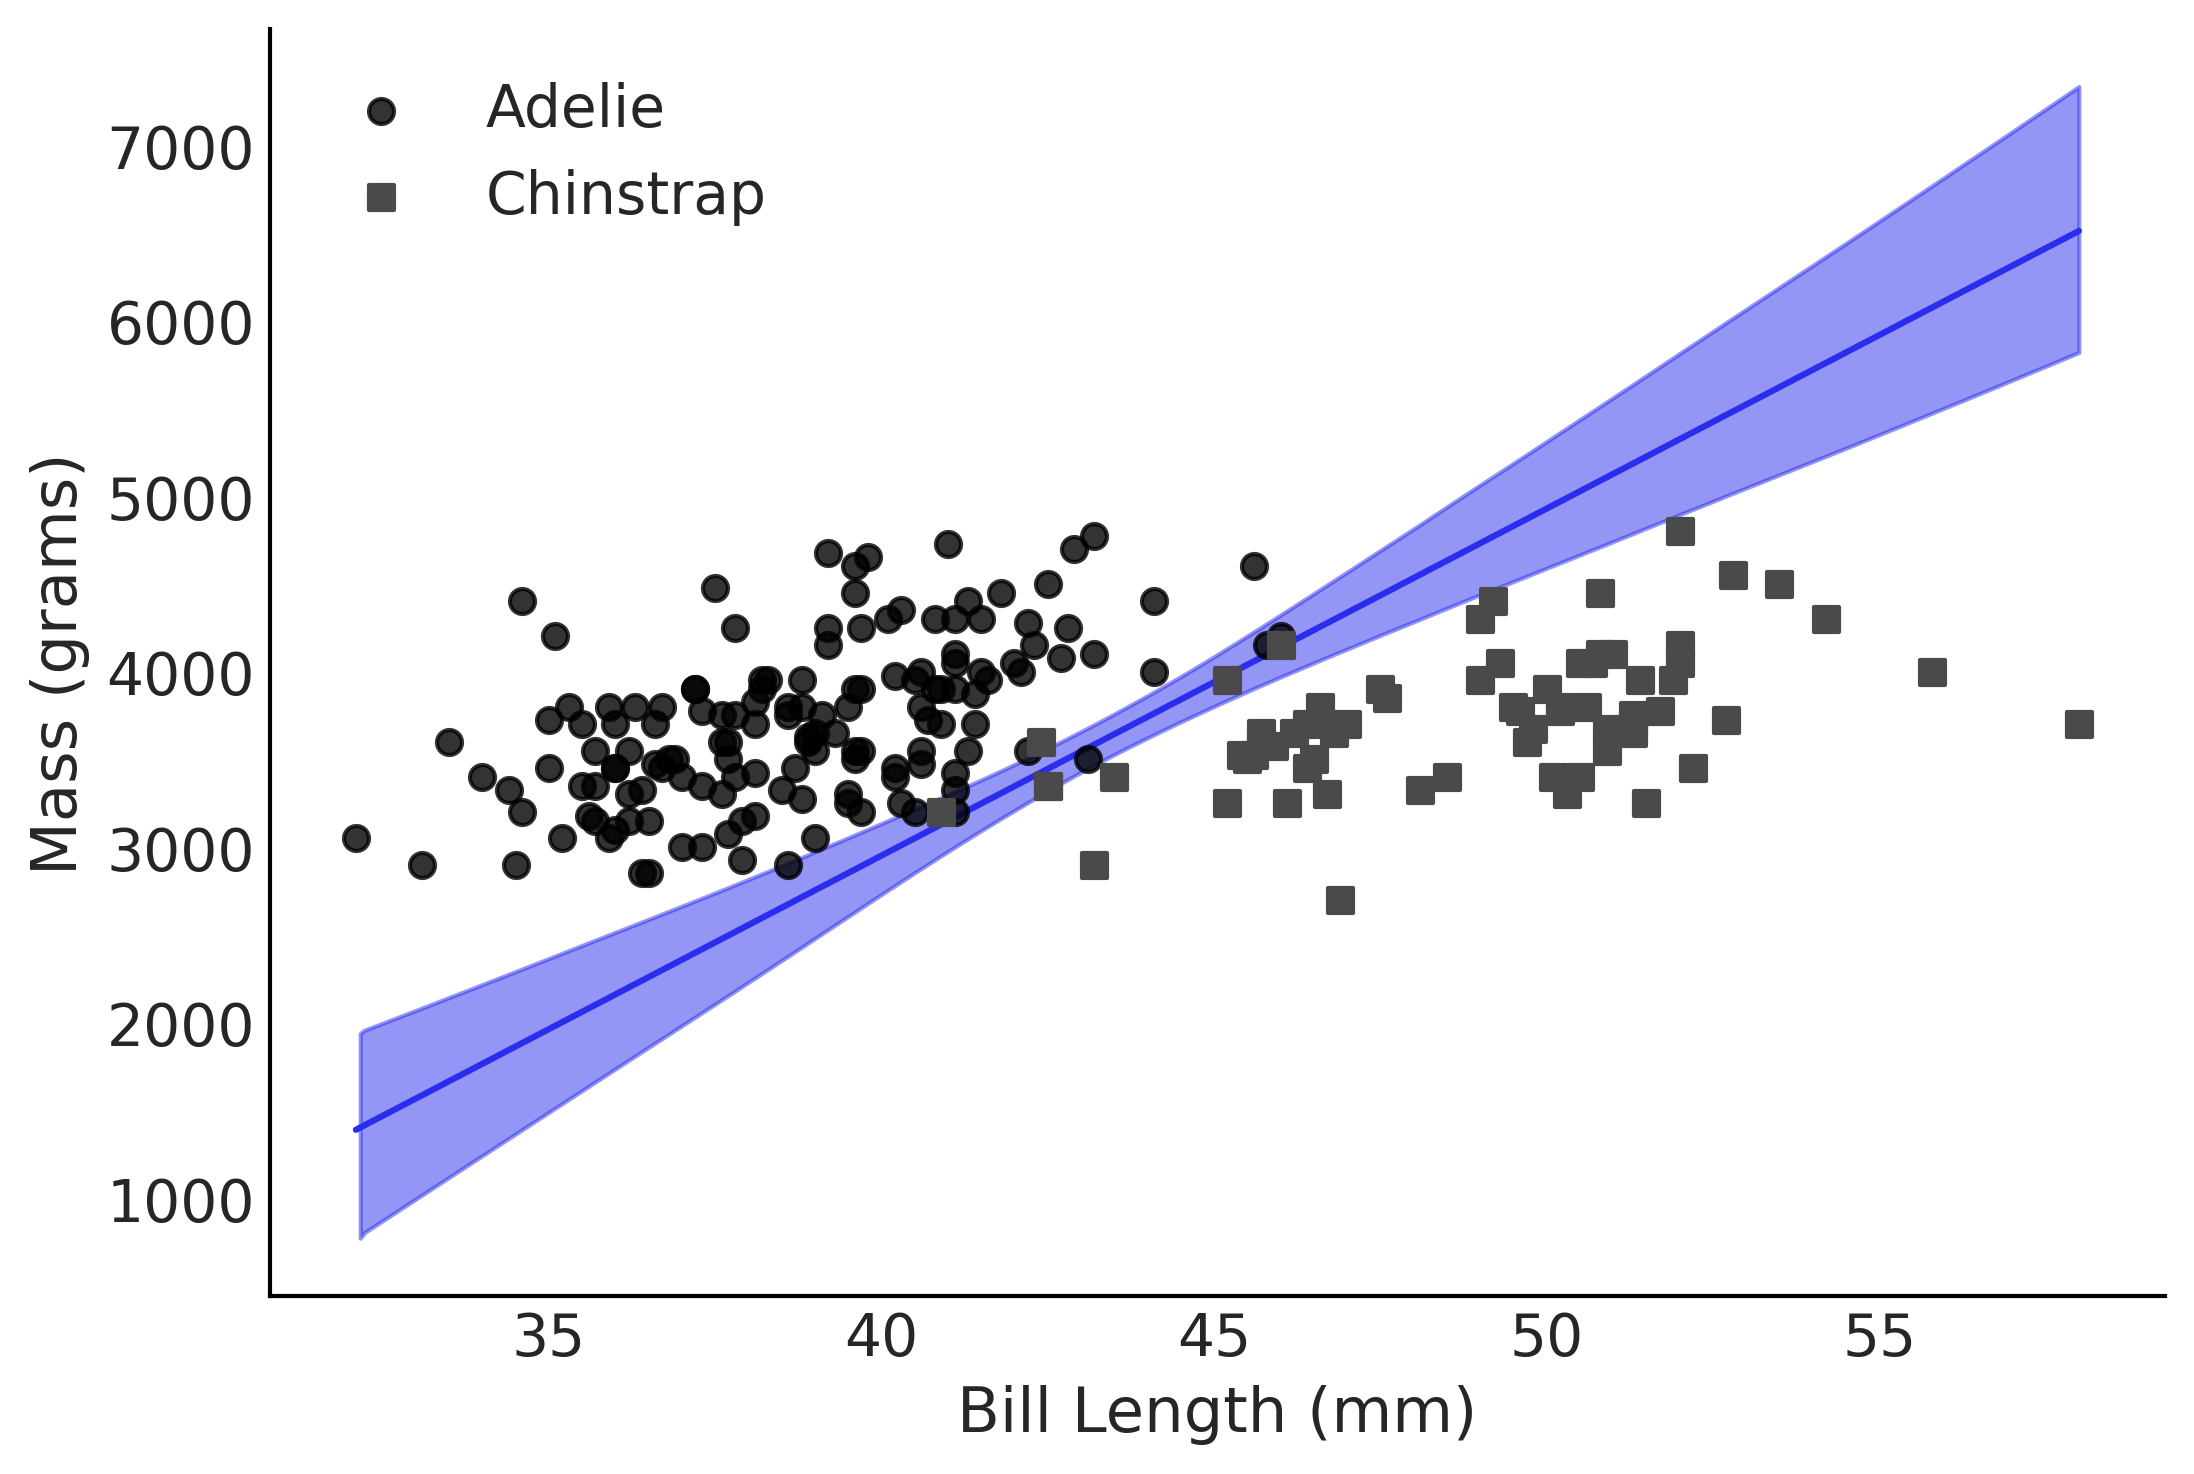

In [44]:
fig,ax  = plt.subplots()
idx = np.argsort(X[:,1])
bd = trace_logistic_penguins_bill_length_mass.posterior["bd"].values.reshape((-1,214)).mean(axis=0)[idx]

species_filter = species.codes.astype(bool)

# Linear fit
ax.plot(X[:,1][idx], bd, color='C4');
az.plot_hdi(X[:,1], trace_logistic_penguins_bill_length_mass.posterior["bd"].values.reshape((-1,214)), color='C4', ax=ax)

# Scatter
ax.scatter(X[~species_filter,1], X[~species_filter,2], alpha=.8,  label="Adelie", zorder=10)
ax.scatter(X[species_filter,1], X[species_filter,2], marker="s", label="Chinstrap", zorder=10)

ax.set_ylabel("Mass (grams)")
ax.set_xlabel("Bill Length (mm)")

ax.legend()

可以通过 separation plot 来更直观的看到分类效果。如果模型分类特别好，图形会是两个分离的长方体。

In [ ]:
trace_logistic_penguins_bill_length.add_groups({"log_likelihood": {"y":trace_logistic_penguins_bill_length.posterior.log_likelihood}})
trace_logistic_penguins_mass.add_groups({"log_likelihood": {"y":trace_logistic_penguins_mass.posterior.log_likelihood}})
trace_logistic_penguins_bill_length_mass.add_groups({"log_likelihood": {"y":trace_logistic_penguins_bill_length_mass.posterior.log_likelihood}})

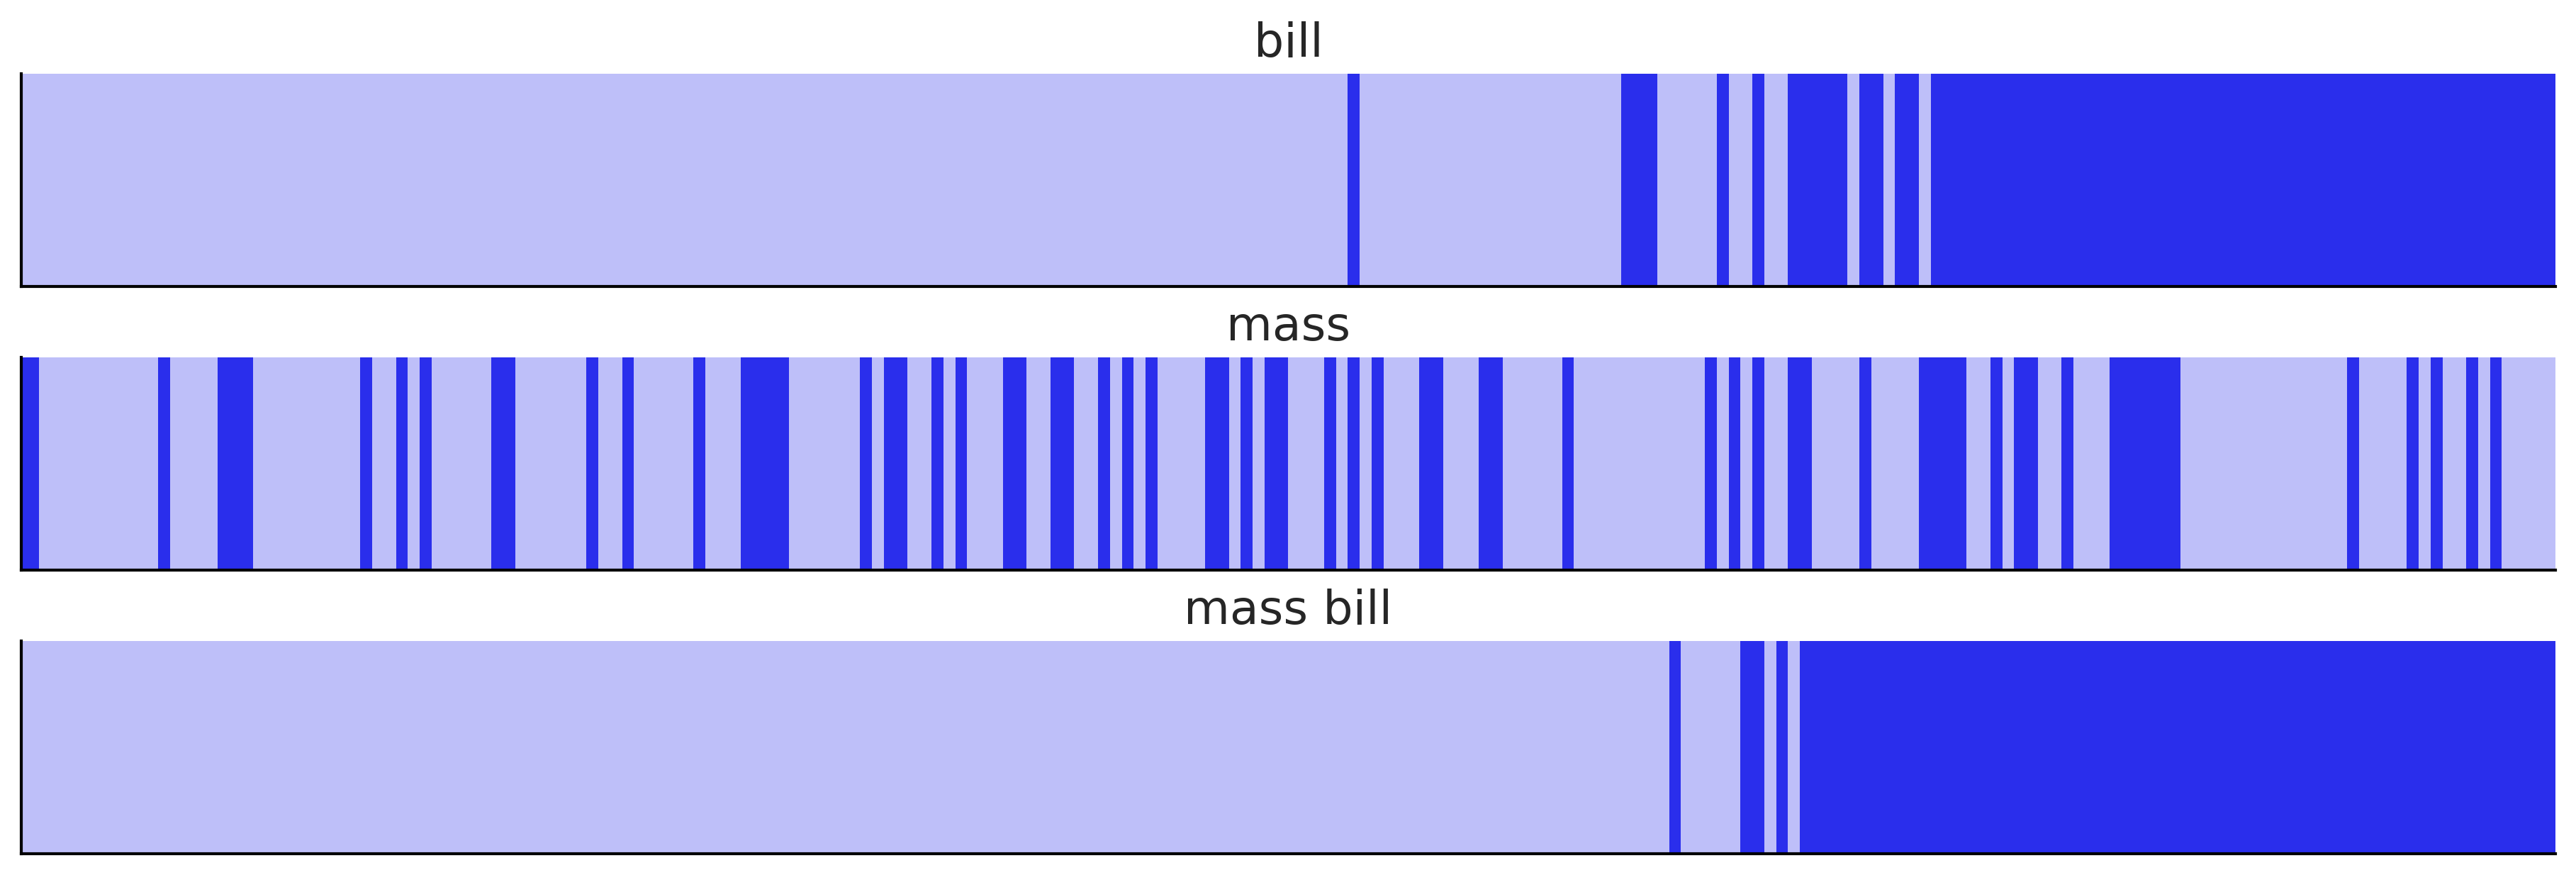

In [59]:
models = {"bill": trace_logistic_penguins_bill_length,
          "mass": trace_logistic_penguins_mass,
          "mass bill": trace_logistic_penguins_bill_length_mass}

_, axes = plt.subplots(3, 1, figsize=(12, 4), sharey=True)
for (label, model), ax in zip(models.items(), axes):
    az.plot_separation(model, y="yl", y_hat="yl", ax=ax, color="C4")
    ax.set_title(label)

也可以通过 LOO 来比较模型的分类效果。

In [60]:
az.compare({"mass": trace_logistic_penguins_mass,
            "bill": trace_logistic_penguins_bill_length,
            "mass_bill": trace_logistic_penguins_bill_length_mass}).round(1)

/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Va

rank  elpd_loo  p_loo  elpd_diff  weight   se  dse  warning scale
mass_bill     0     -11.2    1.6        0.0     1.0  3.1  0.0     True   log
bill          1     -28.0    1.0       16.7     0.0  5.0  3.9    False   log
mass          2    -135.7    1.9      124.5     0.0  5.3  5.8    False   log

### 3.4.3. 对数比率 Log Odds 的解释

在逻辑回归中，斜率告诉您当 x 增加一个单位时对数比率的增加。最简单的赔率是发生概率与不发生概率之间的比率。比如，我们从 Adelie 和 Chinstrap 企鹅中随机抽取一个企鹅，它是 Chinstrap 的概率是0.68。

In [61]:
# Class counts of each penguin species
counts = penguins["species"].value_counts()
adelie_count = counts["Adelie"],
chinstrap_count = counts["Chinstrap"]
adelie_count / (adelie_count + chinstrap_count)

array([0.68224299])

同一事件的比率是：

In [62]:
adelie_count / chinstrap_count

array([2.14705882])

利用我们对比率的了解，我们可以定义 logit。 logit 是赔率的自然对数。则：
$$p = \frac{1}{1+e^{-\mathbf{X}\beta}}$$
$$\log \left(\frac{p}{1-p} \right) = \boldsymbol{X} \beta$$

这种替代公式让我们将逻辑回归的系数解释为对数比率的变化。

## 3.5. 为回归模型选择先验

现在我们已经熟悉了广义线性模型，让我们关注先验及其对后验估计的影响。我们将借用一项研究，其探讨了父母的吸引力与这些父母生下女孩的百分比之间的关系。在这项研究中，研究人员按照五分制评估了美国青少年的吸引力。最终，这些受试者中的许多人有了孩子，计算了每个吸引力类别的性别比例。然而，这一次，要特别关注如何一起评估先验和可能性，而不是独立评估。        
     
先选择一个非常宽的先验（近似无信息先验）：

In [63]:
x = np.arange(-2, 3, 1)
y = np.asarray([50, 44, 50, 47, 56])

with pm.Model() as model_uninformative_prior_sex_ratio:
    σ = pm.Exponential("σ", .5)
    β_1 = pm.Normal("β_1", 0, 20)
    β_0 = pm.Normal("β_0", 50, 20)

    μ = pm.Deterministic("μ", β_0 + β_1 * x)

    ratio = pm.Normal("ratio", mu=μ, sigma=σ, observed=y)

    prior_predictive_uninformative_prior_sex_ratio = pm.sample_prior_predictive(
        samples=10000
    )
    trace_uninformative_prior_sex_ratio = pm.sample()
    trace_uninformative_prior_sex_ratio.extend(prior_predictive_uninformative_prior_sex_ratio)

Sampling: [ratio, β_0, β_1, σ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_1, β_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


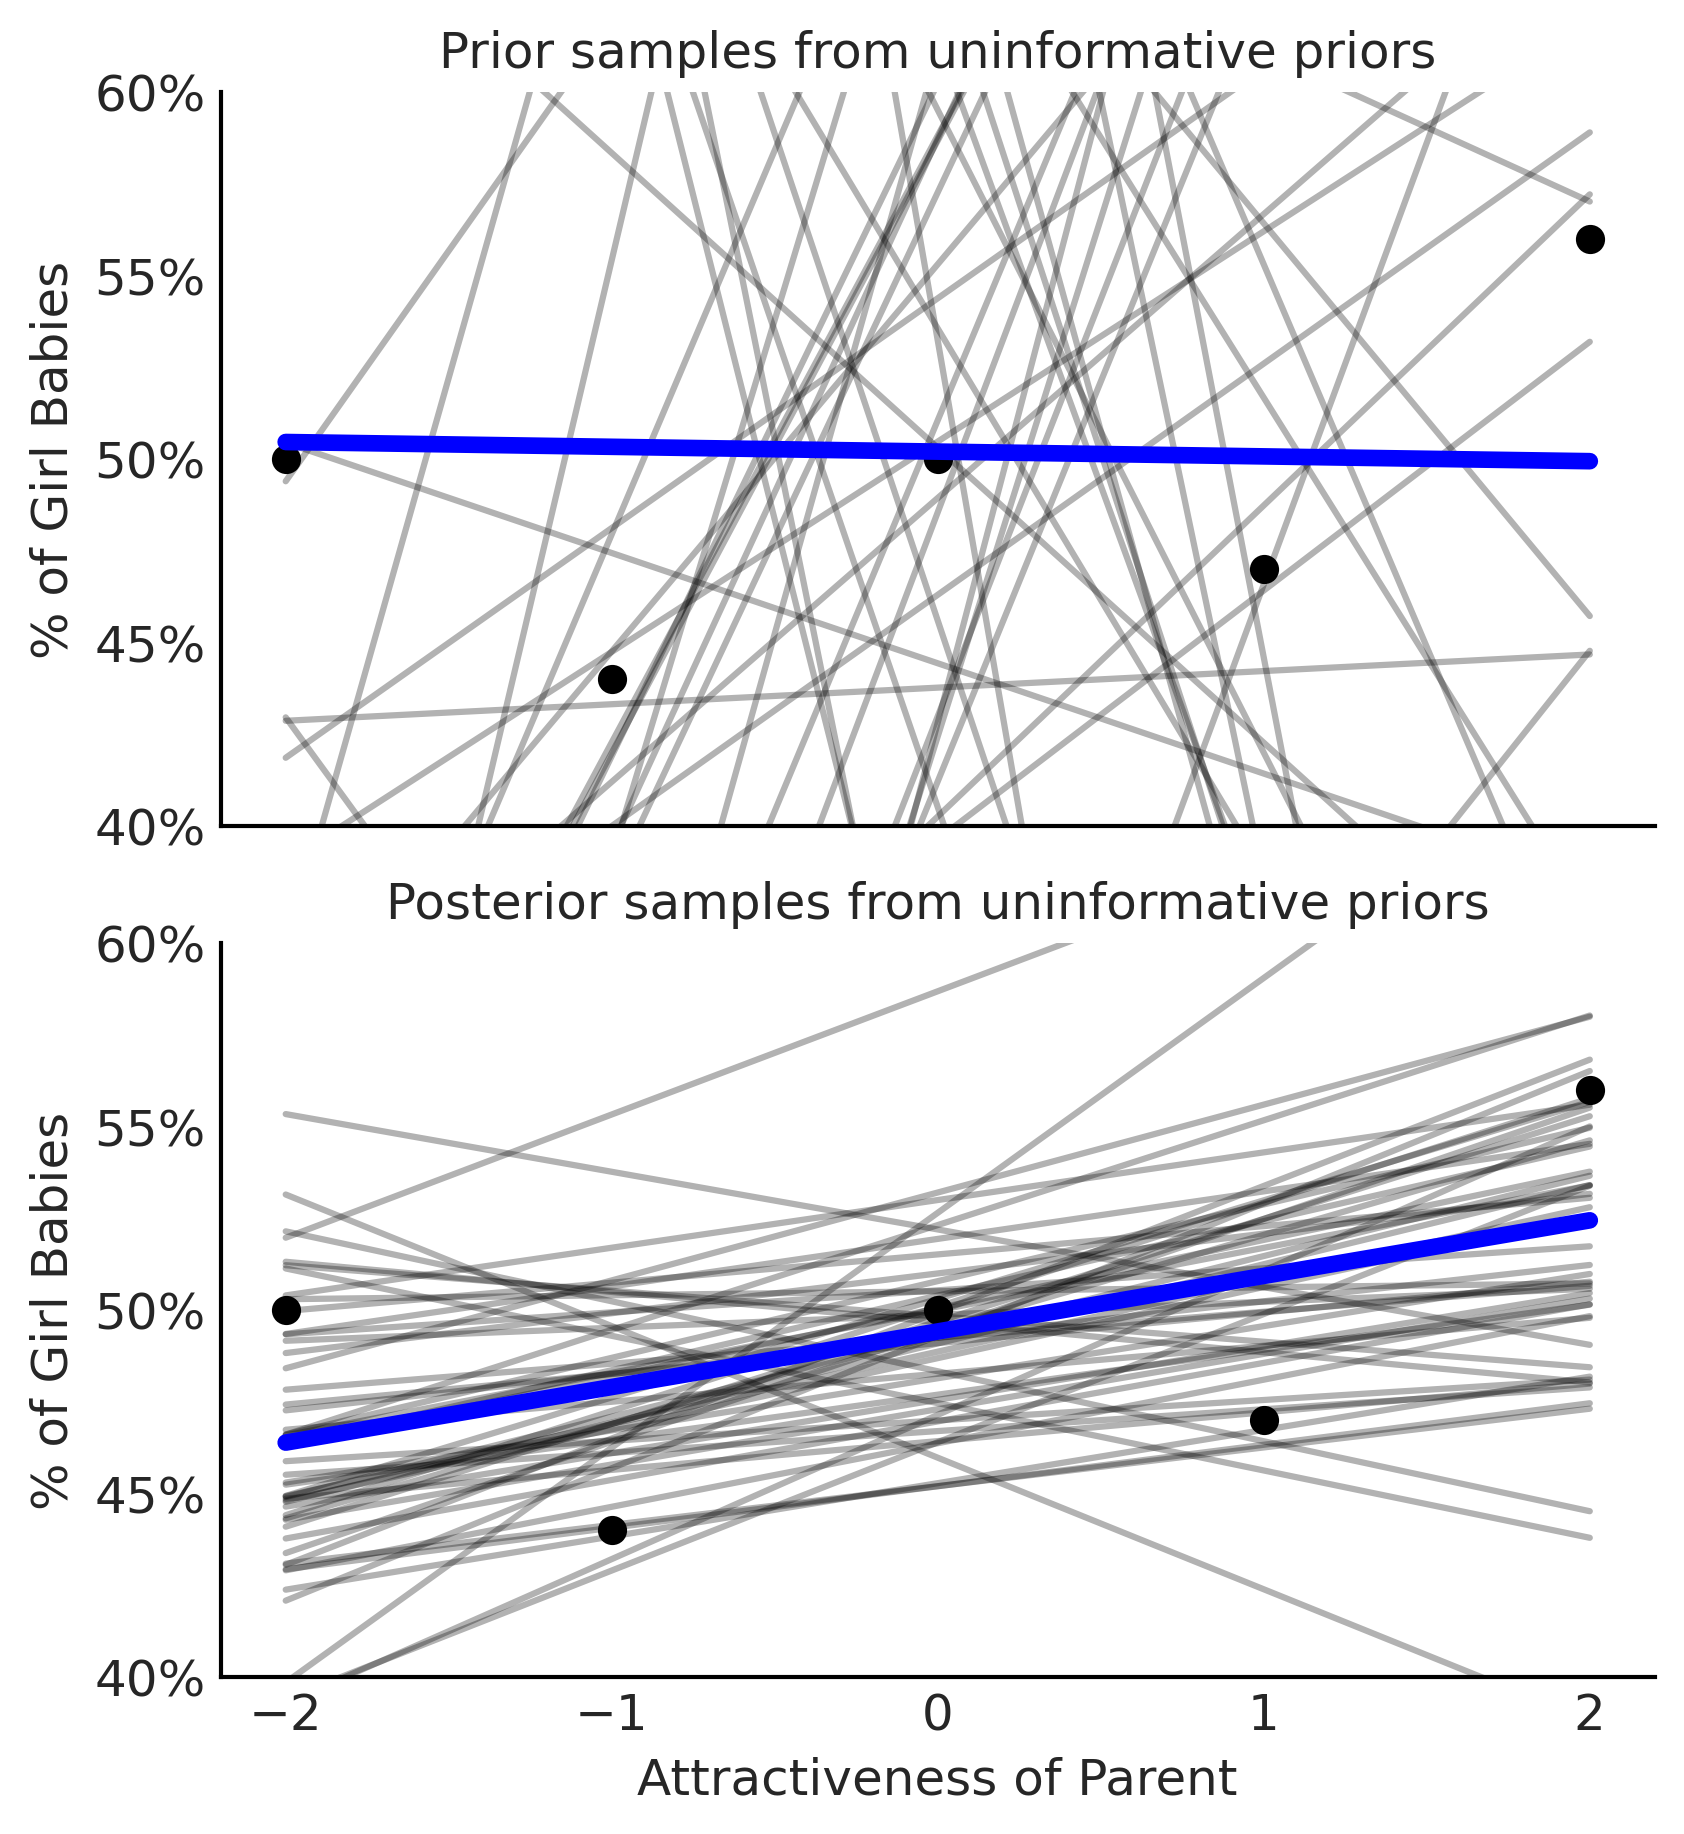

In [64]:
import matplotlib.ticker as mtick
fig, axes = plt.subplots(2,1, figsize=(5.5, 6), sharex=True)

np.random.seed(0)
# Take 50 samples from posterior
num_samples = 50
chain_sample = trace_uninformative_prior_sex_ratio.prior.chain.to_series().sample(num_samples, replace=True)
draw_sample = trace_uninformative_prior_sex_ratio.prior.draw.to_series().sample(num_samples, replace=True)

for chain, draw in zip(chain_sample, draw_sample):
    b_0_draw = trace_uninformative_prior_sex_ratio.prior[{"draw":draw, "chain":chain}]["β_0"].values
    b_1_draw = trace_uninformative_prior_sex_ratio.prior[{"draw":draw, "chain":chain}]["β_1"].values

    # Plot Line
    axes[0].plot(x, b_0_draw+b_1_draw*x, c="black", alpha=.3)

# Add median line later
b_0_hat = trace_uninformative_prior_sex_ratio.prior["β_0"].values.mean()
b_1_hat = trace_uninformative_prior_sex_ratio.prior["β_1"].values.mean()

axes[0].plot(x, b_0_hat+b_1_hat*x, c="blue", linewidth=4)


# Add scatter plot
axes[0].scatter(x, y)
axes[0].set_xticks(x)
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[0].set_ylim(40, 60)
axes[0].set_ylabel("% of Girl Babies")
axes[0].set_title("Prior samples from uninformative priors")
b_0_hat, b_1_hat

np.random.seed(0)
# Take 10 sample from posterior
num_samples = 50
chain_sample = trace_uninformative_prior_sex_ratio.posterior.chain.to_series().sample(num_samples, replace=True)
draw_sample = trace_uninformative_prior_sex_ratio.posterior.draw.to_series().sample(num_samples, replace=True)

for chain, draw in zip(chain_sample, draw_sample):
    b_0_draw = trace_uninformative_prior_sex_ratio.posterior[{"draw":draw, "chain":chain}]["β_0"].values
    b_1_draw = trace_uninformative_prior_sex_ratio.posterior[{"draw":draw, "chain":chain}]["β_1"].values

    # Plot Line
    axes[1].plot(x, b_0_draw+b_1_draw*x, c="black", alpha=.3)

# Add median line later
b_0_hat = trace_uninformative_prior_sex_ratio.posterior["β_0"].values.mean()
b_1_hat = trace_uninformative_prior_sex_ratio.posterior["β_1"].values.mean()

axes[1].plot(x, b_0_hat+b_1_hat*x, c="blue", linewidth=4)


# Add scatter plot
axes[1].scatter(x, y)
axes[1].set_xticks(x)
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[1].set_ylim(40, 60)
axes[1].set_xlabel("Attractiveness of Parent")
axes[1].set_ylabel("% of Girl Babies")
axes[1].set_title("Posterior samples from uninformative priors")
b_0_hat, b_1_hat

axes[1].title.set_fontsize(12)

for ax in axes:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

经评估，$\beta_1$ 的影响约1.4。从数学角度来看，这个结果是有效的。但从我们的常识和我们对本研究之外的出生性别比的理解来看，这些结果是值得怀疑的。据测算，出生时的“自然”性别比约为 105 比 100 名女孩（男孩约为 103 至 107 人），这意味着出生时性别比为女性 48.5%，标准差为 0.5。此外，即使是与人类生物学更本质相关的因素也不会对出生率产生如此大的影响，从而削弱了主观吸引力应该产生如此大影响的观念。    
    
让我们再次运行我们的模型，但这次先验与此常识一致。绘制我们的后验样本时，系数的集中度较小，并且在考虑可能的比率时，绘制的后验线落入更合理的范围内。

In [65]:
with pm.Model() as model_informative_prior_sex_ratio:
    σ = pm.Exponential("σ", .5)

    # Note the now more informative priors
    β_1 = pm.Normal("β_1", 0, .5)
    β_0 = pm.Normal("β_0", 48.5, .5)

    μ = pm.Deterministic("μ", β_0 + β_1 * x)
    ratio = pm.Normal("ratio", mu=μ, sigma=σ, observed=y)

    prior_predictive_informative_prior_sex_ratio = pm.sample_prior_predictive(
        samples=10000
    )
    trace_informative_prior_sex_ratio = pm.sample()
    trace_informative_prior_sex_ratio.extend(prior_predictive_informative_prior_sex_ratio)

Sampling: [ratio, β_0, β_1, σ]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_1, β_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


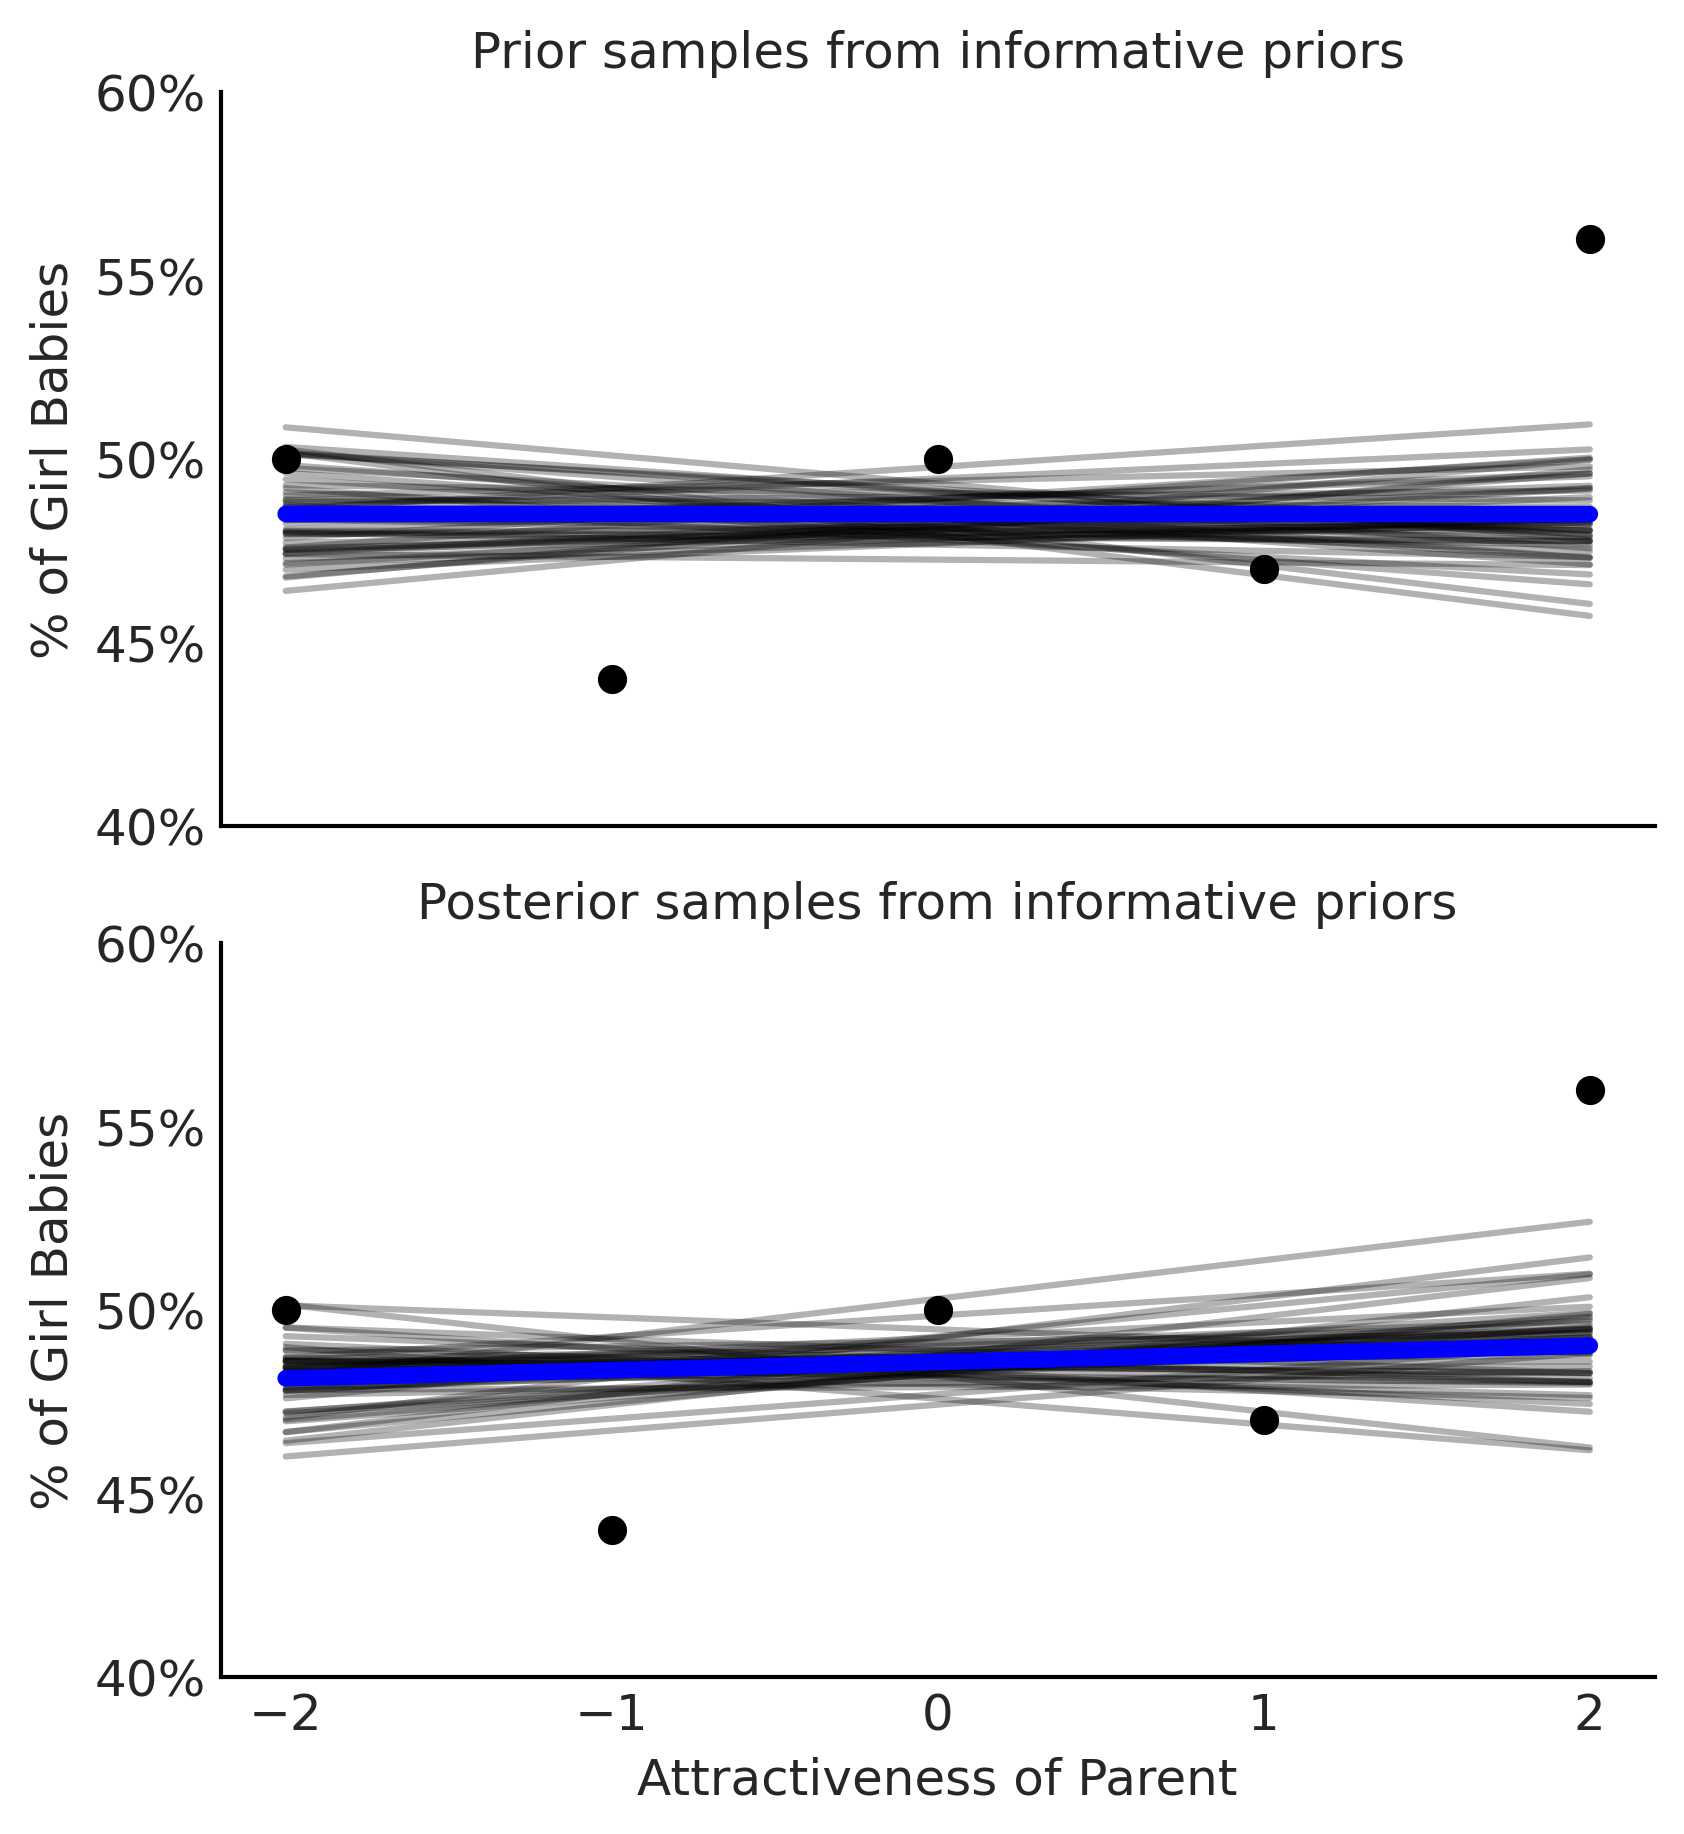

In [66]:
fig, axes = plt.subplots(2,1, figsize=(5.5, 6), sharex=True)

np.random.seed(0)
# Take 10 sample from posterior
num_samples = 50
chain_sample = trace_informative_prior_sex_ratio.prior.chain.to_series().sample(num_samples, replace=True)
draw_sample = trace_informative_prior_sex_ratio.prior.draw.to_series().sample(num_samples, replace=True)

for chain, draw in zip(chain_sample, draw_sample):
    b_0_draw = trace_informative_prior_sex_ratio.prior[{"draw":draw, "chain":chain}]["β_0"].values
    b_1_draw = trace_informative_prior_sex_ratio.prior[{"draw":draw, "chain":chain}]["β_1"].values

    # Plot Line
    axes[0].plot(x, b_0_draw+b_1_draw*x, c="black", alpha=.3)

# Add median line later
b_0_hat = trace_informative_prior_sex_ratio.prior["β_0"].values.mean()
b_1_hat = trace_informative_prior_sex_ratio.prior["β_1"].values.mean()

axes[0].plot(x, b_0_hat+b_1_hat*x, c="blue", linewidth=4)


# Add scatter plot
axes[0].scatter(x, y)
axes[0].set_xticks(x)
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[0].set_ylim(40, 60)
axes[0].set_ylabel("% of Girl Babies")
axes[0].set_title("Prior samples from informative priors");


np.random.seed(0)
num_samples = 50
chain_sample = trace_informative_prior_sex_ratio.posterior.chain.to_series().sample(num_samples, replace=True)
draw_sample = trace_informative_prior_sex_ratio.posterior.draw.to_series().sample(num_samples, replace=True)

for chain, draw in zip(chain_sample, draw_sample):
    b_0_draw = trace_informative_prior_sex_ratio.posterior[{"draw":draw, "chain":chain}]["β_0"].values
    b_1_draw = trace_informative_prior_sex_ratio.posterior[{"draw":draw, "chain":chain}]["β_1"].values

    # Plot Line
    axes[1].plot(x, b_0_draw+b_1_draw*x, c="black", alpha=.3)

# Add median line later
b_0_hat = trace_informative_prior_sex_ratio.posterior["β_0"].values.mean()
b_1_hat = trace_informative_prior_sex_ratio.posterior["β_1"].values.mean()

axes[1].plot(x, b_0_hat+b_1_hat*x, c="blue", linewidth=4)

# Add scatter plot
axes[1].scatter(x, y)
axes[1].set_xticks(x)
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[1].set_ylim(40, 60)

axes[1].set_xlabel("Attractiveness of Parent")
axes[1].set_ylabel("% of Girl Babies")
axes[1].set_title("Posterior samples from informative priors")

for ax in axes:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

这次我们看到吸引力对性别的估计影响可以忽略不计，根本没有足够的信息来影响后验。正如我们在第一章量化先验信息的几个选项中提到的，选择先验既是一种负担，也是一种祝福。无论您相信哪一种，重要的是要以可解释且有原则的选择来使用此统计工具。